In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def getCalibrationMatrix():

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )
    return (mtx, dist)

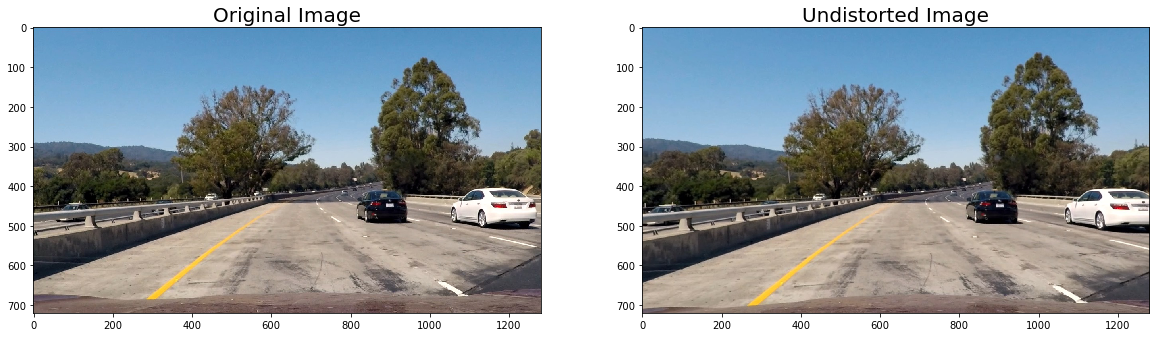

In [25]:
# Test undistortion on an image
img = mpimg.imread('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

mtx, dist = getCalibrationMatrix()
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

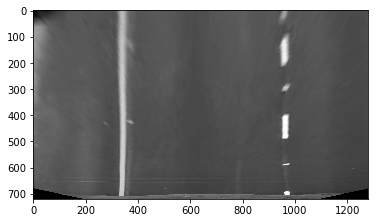

In [4]:
def getPerspectiveTransform():
    src = np.array([[582, 455], [700, 455], [1150, 720], [150, 720]], dtype = np.float32)
    dst = np.array([[300, 0], [1000, 0], [1000, 720], [300, 720]], dtype = np.float32)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


M, MInv = getPerspectiveTransform()


img = cv2.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
plt.imshow(warped, cmap='gray')

def undistort_image(image):
    global mtx, dist, M
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return cv2.warpPerspective(dst, M, (image.shape[1], image.shape[0]))

In [107]:
def togray(img):
#     img2 = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return (img[:,:,0])

def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    img = togray(img)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8(sobel * 255 / np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    img = togray(img)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel)
    # 3) Calculate the magnitude 
    sobel = (sobelx ** 2 + sobely ** 2) ** 0.5
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel = np.uint8(sobel * 255 / np.max(sobel))
    # 5) Create a binary mask where mag thresholds are met
    
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= mag_thresh[0]) & (sobel <= mag_thresh[1])] = 1
    return binary_output
    

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    img = togray(img)
#     img = img[:,:,1]
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel))
    dire = np.arctan2(sobely, sobelx)
    
    binary_output = np.zeros_like(dire)
    binary_output[(dire >= thresh[0]) & (dire <= thresh[1])] = 1
    binary_output[(dire >= -thresh[0]) & (dire <= -thresh[1])] = 1
    return binary_output

def color_threshold(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_channel, s_binary    

In [108]:
def plot_images(img1, img2, t1, t2):
    # Visualize undistortion
#     plt.figure()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,20))
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(t1, fontsize=20)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(t2, fontsize=20)

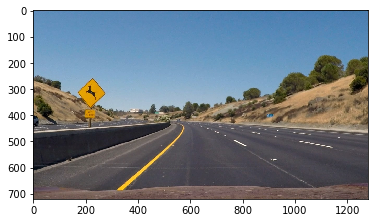

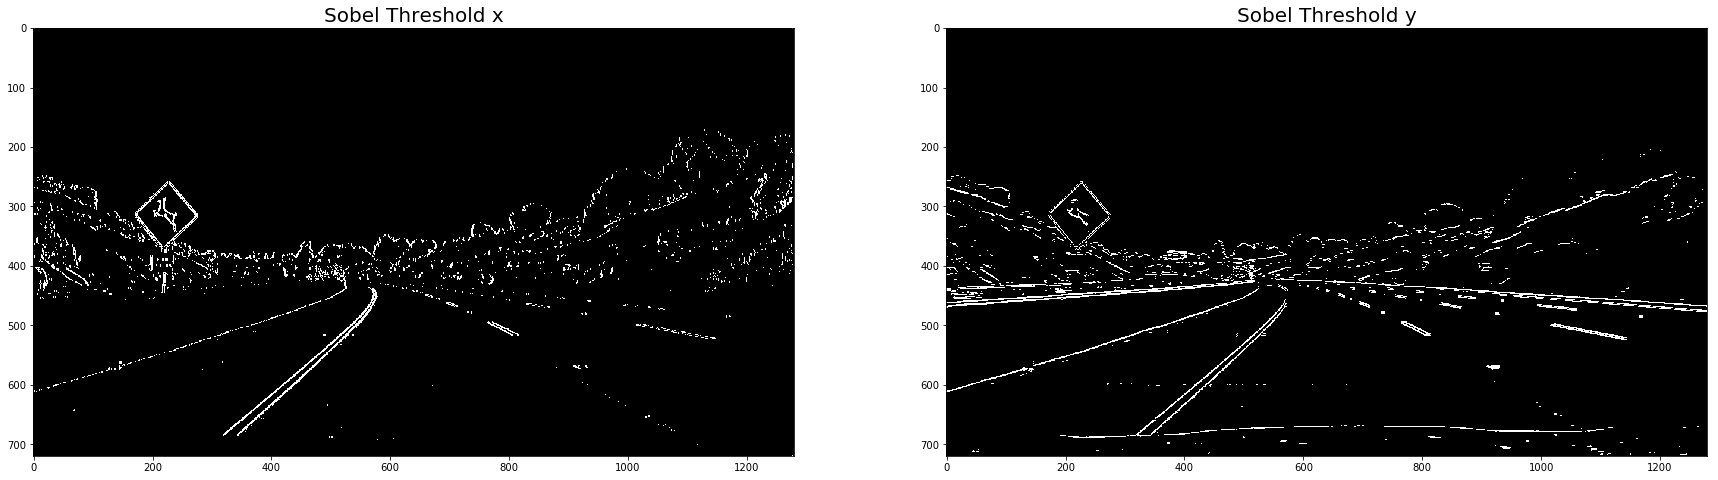

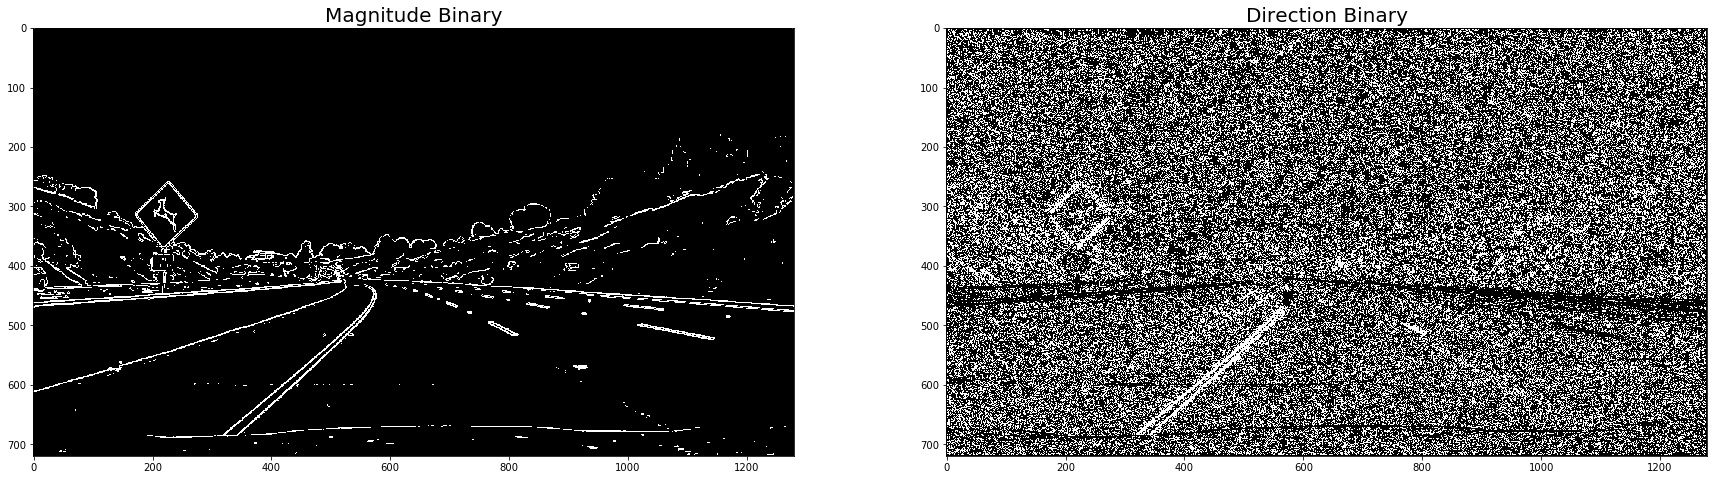

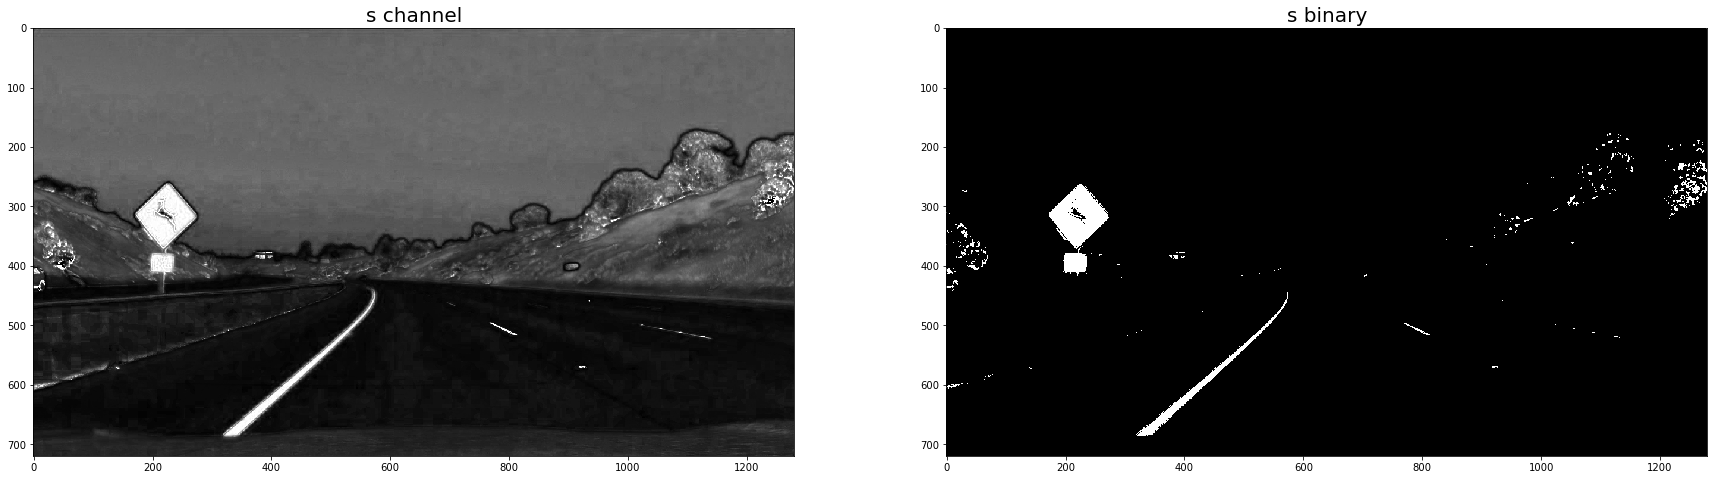

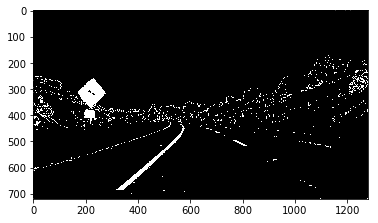

In [114]:

def show_image(image):
#     image = mpimg.imread(fname)
    plt.imshow(image)
    plt.figure()
    gradx = abs_sobel_thresh(image, orient='x', thresh=(40,250))
    grady = abs_sobel_thresh(image, orient='y', thresh=(50, 250))
    plot_images(gradx, grady, "Sobel Threshold x", "Sobel Threshold y")
    
    mag_binary = mag_thresh(image, sobel_kernel = ksize, mag_thresh=(50, 250))
    dir_binary = dir_threshold(image, thresh=(0.6, 1.2))
    
    plot_images(mag_binary, dir_binary, "Magnitude Binary", "Direction Binary")
    
    s_channel, s_binary = color_threshold(image, thresh=(160, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[(s_binary == 1) | ((dir_binary == 1) & (mag_binary == 1)) | ((gradx == 1))] = 1
    
    plot_images(s_channel, s_binary, "s channel", "s binary")
    
    plt.figure()
    plt.imshow(combined, cmap='gray')
    combined = undistort_image(combined)
    
image = mpimg.imread('test_images/test2.jpg')
show_image(image)

In [111]:
ksize = 5

# # Make a list of calibration images
# images = glob.glob('test_images/*.jpg')

# # Step through the list and search for chessboard corners
# for idx, fname in enumerate(images):
def process_image(image):
#     image = mpimg.imread(fname)
    # plt.imshow(image)
    gradx = abs_sobel_thresh(image, orient='x', thresh=(40,250))
    grady = abs_sobel_thresh(image, orient='y', thresh=(50, 250))
    mag_binary = mag_thresh(image, sobel_kernel = ksize, mag_thresh=(50, 250))
    dir_binary = dir_threshold(image, thresh=(0.6, 1.2))
    s_channel, s_binary = color_threshold(image, thresh=(160, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[(s_binary == 1) | ((dir_binary == 1) & (mag_binary == 1)) | ((gradx == 1))] = 1
    plt.figure()
    combined = undistort_image(combined)
#     plt.imshow(combined, cmap='gray')
#     plt.figure()
    binary_warped = combined
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
        # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
    return result

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


# %load_ext autoreload
# %autoreload 2
cnt = 0  # counter
output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

1797.79594346 1291.18788831
590.454959125 m 422.441274259 m
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



  0%|          | 1/1261 [00:00<06:54,  3.04it/s]

1797.79594346 1291.18788831
590.454959125 m 422.441274259 m



  0%|          | 2/1261 [00:00<07:27,  2.81it/s]

1487.79202951 1756.76721576
487.586909211 m 576.206375739 m



  0%|          | 3/1261 [00:01<07:19,  2.86it/s]

1566.83938461 2563.24803107
514.172170215 m 829.613273912 m



  0%|          | 4/1261 [00:01<07:12,  2.91it/s]

1519.16955918 3324.23519057
498.391206014 m 1063.64696755 m



  0%|          | 5/1261 [00:01<07:46,  2.69it/s]

1625.5799751 2959.07435494
533.904528145 m 950.909623396 m



  0%|          | 6/1261 [00:02<07:44,  2.70it/s]

1690.28988531 2490.17008784
555.159164323 m 803.596856758 m



  1%|          | 7/1261 [00:02<07:27,  2.80it/s]

1782.73779983 2496.16581994
585.183096936 m 805.897549876 m



  1%|          | 8/1261 [00:02<07:08,  2.93it/s]

1757.8931877 4804.68914864
576.980692021 m 1489.66628714 m



  1%|          | 9/1261 [00:03<06:47,  3.07it/s]

1835.12356469 7004.11359584
601.831079745 m 2161.21231952 m



  1%|          | 10/1261 [00:03<06:30,  3.20it/s]

1854.44679904 2122.20809278
607.865190319 m 688.268961797 m



  1%|          | 11/1261 [00:03<06:28,  3.22it/s]

1967.91062538 1509.31235289
643.921576775 m 494.845113035 m



  1%|          | 12/1261 [00:04<06:35,  3.16it/s]

2036.44415165 1840.39750338
665.125771528 m 602.811735114 m



  1%|          | 13/1261 [00:04<06:28,  3.21it/s]

2187.20894534 1436.06917922
712.224870043 m 471.633309729 m



  1%|          | 14/1261 [00:04<06:18,  3.30it/s]

2141.28815828 1932.08168351
698.016479237 m 629.594871285 m



  1%|          | 15/1261 [00:04<06:05,  3.41it/s]

2062.18978493 2862.90533953
673.565885948 m 908.771727619 m



  1%|▏         | 16/1261 [00:05<06:13,  3.33it/s]

2260.62302362 2511.46813351
736.447425805 m 798.146315641 m



  1%|▏         | 17/1261 [00:05<06:17,  3.30it/s]

2118.68411164 2585.1839404
691.399653678 m 819.877588666 m



  1%|▏         | 18/1261 [00:05<06:17,  3.30it/s]

2247.20733194 2166.9368621
731.787098507 m 693.419149538 m



  2%|▏         | 19/1261 [00:06<06:12,  3.34it/s]

2252.98836326 2303.91772667
733.488736259 m 739.338394125 m



  2%|▏         | 20/1261 [00:06<06:24,  3.22it/s]

2487.86275925 2329.69472706
807.074952952 m 749.97996477 m



  2%|▏         | 21/1261 [00:06<06:28,  3.19it/s]

2543.46952168 2873.63562132
824.590137158 m 920.861968359 m



  2%|▏         | 22/1261 [00:07<06:41,  3.08it/s]

2424.79998617 3007.05047763
787.355590297 m 967.166753423 m



  2%|▏         | 23/1261 [00:07<06:26,  3.20it/s]

2371.2436199 4672.92206799
771.253539325 m 1485.84051653 m



  2%|▏         | 24/1261 [00:07<06:16,  3.28it/s]

2286.25030518 1478.09736067
745.207873086 m 485.480570208 m



  2%|▏         | 25/1261 [00:07<06:06,  3.37it/s]

2062.2186022 1202.26890309
674.602190739 m 393.660397552 m



  2%|▏         | 26/1261 [00:08<06:08,  3.35it/s]

1939.4590661 1231.85075573
635.453605939 m 403.22026398 m



  2%|▏         | 27/1261 [00:08<06:20,  3.24it/s]

1867.52197601 1424.68289191
612.468625384 m 467.907454509 m



  2%|▏         | 28/1261 [00:08<06:18,  3.25it/s]

1955.79633281 1583.33590922
640.936205821 m 520.043296979 m



  2%|▏         | 29/1261 [00:09<06:13,  3.30it/s]

1973.70045205 1931.56430043
646.858748876 m 632.401360238 m



  2%|▏         | 30/1261 [00:09<06:03,  3.39it/s]

1738.03494365 2973.46608888
570.699736624 m 957.439056786 m



  2%|▏         | 31/1261 [00:09<06:07,  3.35it/s]

1644.8052014 3151.93940554
540.2404454 m 1006.74629363 m



  3%|▎         | 32/1261 [00:10<06:12,  3.30it/s]

1499.56098454 1915.55038909
492.222774083 m 621.523166224 m



  3%|▎         | 33/1261 [00:10<06:05,  3.36it/s]

1552.22905793 2014.26440591
509.718832367 m 654.471235821 m



  3%|▎         | 34/1261 [00:10<05:57,  3.43it/s]

1425.41199557 2872.66044432
467.527054436 m 913.156169998 m



  3%|▎         | 35/1261 [00:10<05:52,  3.48it/s]

1364.3779869 1657.78198645
447.199568505 m 541.763115042 m



  3%|▎         | 36/1261 [00:11<05:53,  3.47it/s]

1334.33446235 992.670400405
437.251249963 m 324.018961484 m



  3%|▎         | 37/1261 [00:11<06:04,  3.36it/s]

1303.26418854 1169.70432464
426.895273761 m 384.193379775 m



  3%|▎         | 38/1261 [00:11<06:13,  3.27it/s]

1253.17776664 1336.68132355
410.131046441 m 437.52431497 m



  3%|▎         | 39/1261 [00:12<06:10,  3.30it/s]

1182.36804625 1786.2185062
386.205722665 m 573.810171908 m



  3%|▎         | 40/1261 [00:12<05:57,  3.41it/s]

1212.96231382 2007.88439762
396.971619578 m 641.483825709 m



  3%|▎         | 41/1261 [00:12<05:54,  3.44it/s]

1225.55251796 1664.16535303
401.485335794 m 538.180133842 m



  3%|▎         | 42/1261 [00:13<06:04,  3.35it/s]

1243.03657752 1706.35904963
407.662641432 m 551.345431193 m



  3%|▎         | 43/1261 [00:13<06:06,  3.32it/s]

1333.63452818 1729.41198908
438.017043499 m 559.752911535 m



  3%|▎         | 44/1261 [00:13<06:03,  3.35it/s]

1389.56054826 1837.45894636
456.389202579 m 595.16519489 m



  4%|▎         | 45/1261 [00:13<05:57,  3.40it/s]

1500.22435724 1708.72600283
492.255836701 m 555.88632281 m



  4%|▎         | 46/1261 [00:14<05:59,  3.38it/s]

1548.50041158 1769.22418097
507.697452176 m 575.211557838 m



  4%|▎         | 47/1261 [00:14<06:00,  3.37it/s]

1572.03399108 2613.18716542
515.311377208 m 832.028730283 m



  4%|▍         | 48/1261 [00:14<06:13,  3.25it/s]

1652.01243573 1434.45031186
540.548988743 m 470.144664899 m



  4%|▍         | 49/1261 [00:15<06:13,  3.24it/s]

1773.56874715 1299.62003947
578.727456007 m 426.864420995 m



  4%|▍         | 50/1261 [00:15<06:13,  3.24it/s]

1812.30759701 1110.16011225
590.573468923 m 364.238835578 m



  4%|▍         | 51/1261 [00:15<06:18,  3.19it/s]

1924.37735125 1201.06656709
625.604471685 m 394.491148502 m



  4%|▍         | 52/1261 [00:16<06:31,  3.09it/s]

2029.99285726 1592.27372852
658.942424753 m 517.088491668 m



  4%|▍         | 53/1261 [00:16<06:23,  3.15it/s]

2045.55702691 1994.7109731
664.139114544 m 639.621734277 m



  4%|▍         | 54/1261 [00:16<06:30,  3.09it/s]

2082.82098883 1997.92618127
676.028403621 m 640.002153665 m



  4%|▍         | 55/1261 [00:17<06:46,  2.97it/s]

2395.78910059 1843.0058215
772.734086811 m 592.977404234 m



  4%|▍         | 56/1261 [00:17<06:46,  2.97it/s]

2477.8799069 2037.09454937
798.713034014 m 654.011037539 m



  5%|▍         | 57/1261 [00:17<06:48,  2.95it/s]

2490.60435141 2178.63317757
803.314011034 m 695.612937775 m



  5%|▍         | 58/1261 [00:18<06:23,  3.14it/s]

2405.48959015 3036.98739541
777.98148496 m 949.866036047 m



  5%|▍         | 59/1261 [00:18<06:29,  3.09it/s]

2119.40692687 1769.39563725
689.747864527 m 568.693604794 m



  5%|▍         | 60/1261 [00:18<06:29,  3.08it/s]

2027.81682025 1291.23827159
661.97571143 m 421.375793364 m



  5%|▍         | 61/1261 [00:19<06:31,  3.07it/s]

1852.12845363 1578.53887763
606.698621267 m 508.313648027 m



  5%|▍         | 62/1261 [00:19<06:29,  3.07it/s]

1810.95398392 2250.96161757
593.777905835 m 701.778679476 m



  5%|▍         | 63/1261 [00:19<06:24,  3.12it/s]

1864.53622629 2168.95441746
611.094995854 m 684.779026107 m



  5%|▌         | 64/1261 [00:20<06:15,  3.19it/s]

1733.13228563 2316.08744309
568.963042557 m 726.212729781 m



  5%|▌         | 65/1261 [00:20<06:05,  3.27it/s]

1811.11597608 2880.63864313
594.345531155 m 898.912780231 m



  5%|▌         | 66/1261 [00:20<06:22,  3.13it/s]

1810.12546004 2631.4474623
594.242925949 m 824.297869727 m



  5%|▌         | 67/1261 [00:21<06:34,  3.03it/s]

1880.22735749 2285.67665874
617.04978562 m 726.641307667 m



  5%|▌         | 68/1261 [00:21<06:37,  3.00it/s]

2075.94941684 2251.09571622
680.193964672 m 719.373724445 m



  5%|▌         | 69/1261 [00:21<06:30,  3.06it/s]

2047.73955899 2048.7115628
671.34764851 m 657.010800102 m



  6%|▌         | 70/1261 [00:22<06:22,  3.12it/s]

2165.92230314 1778.18002829
709.080305478 m 577.687224254 m



  6%|▌         | 71/1261 [00:22<06:31,  3.04it/s]

2208.46084623 1070.51393218
722.949826535 m 350.00376718 m



  6%|▌         | 72/1261 [00:22<06:33,  3.02it/s]

2444.8906275 936.959245423
798.388145862 m 302.035278594 m



  6%|▌         | 73/1261 [00:23<06:29,  3.05it/s]

2541.13742036 1044.02920213
829.15881181 m 340.51686235 m



  6%|▌         | 74/1261 [00:23<06:21,  3.11it/s]

2710.32989827 1162.63510087
883.101746215 m 381.481394039 m



  6%|▌         | 75/1261 [00:23<06:15,  3.16it/s]

2903.20078203 1300.06320221
943.59663932 m 427.007417634 m



  6%|▌         | 76/1261 [00:23<06:14,  3.16it/s]

2938.06759362 1547.96462153
955.722794054 m 506.407992877 m



  6%|▌         | 77/1261 [00:24<06:16,  3.15it/s]

3125.27341949 1514.95408681
1013.841945 m 497.180025266 m



  6%|▌         | 78/1261 [00:24<06:14,  3.16it/s]

3624.57566548 1865.06738128
1171.29705899 m 609.877837939 m



  6%|▋         | 79/1261 [00:24<06:11,  3.18it/s]

3320.163294 2183.24537526
1076.32639274 m 711.652023715 m



  6%|▋         | 80/1261 [00:25<06:13,  3.16it/s]

3134.64911623 2778.05547441
1018.89337742 m 899.178125436 m



  6%|▋         | 81/1261 [00:25<06:26,  3.05it/s]

3470.11845568 2320.02756016
1125.96961784 m 753.760716152 m



  7%|▋         | 82/1261 [00:25<06:26,  3.05it/s]

3332.90951105 2198.04908822
1083.55834621 m 716.248905541 m



  7%|▋         | 83/1261 [00:26<06:18,  3.12it/s]

3077.3496793 2394.28614886
1003.00495966 m 777.514194127 m



  7%|▋         | 84/1261 [00:26<06:06,  3.21it/s]

3389.19544345 2778.7899247
1101.51014762 m 901.279159181 m



  7%|▋         | 85/1261 [00:26<05:59,  3.27it/s]

3008.14762121 4042.58732244
981.55539422 m 1291.73358239 m



  7%|▋         | 86/1261 [00:27<06:06,  3.21it/s]

2647.21992496 5473.47803989
866.830836566 m 1740.74181435 m



  7%|▋         | 87/1261 [00:27<06:08,  3.19it/s]

2136.45063588 1306.77403254
701.68619946 m 428.75690316 m



  7%|▋         | 88/1261 [00:27<05:59,  3.26it/s]

1878.62443093 1554.00580884
616.601653765 m 509.427136227 m



  7%|▋         | 89/1261 [00:28<05:59,  3.26it/s]

1816.47760128 2137.13978194
595.754175291 m 690.35259158 m



  7%|▋         | 90/1261 [00:28<05:46,  3.38it/s]

1640.68104275 2155.74449158
536.491839285 m 692.398430089 m



  7%|▋         | 91/1261 [00:28<05:52,  3.32it/s]

1588.11326432 2091.88427
518.819178736 m 676.143105139 m



  7%|▋         | 92/1261 [00:28<06:08,  3.17it/s]

1760.12183549 2352.72880226
577.065633334 m 759.064464026 m



  7%|▋         | 93/1261 [00:29<06:06,  3.19it/s]

1650.13865253 2003.59300599
540.174075143 m 649.874978592 m



  7%|▋         | 94/1261 [00:29<06:04,  3.20it/s]

1692.33173565 1954.03267333
554.46927365 m 633.869845647 m



  8%|▊         | 95/1261 [00:29<05:57,  3.27it/s]

1662.91639718 2010.89979832
544.806999755 m 654.000374817 m



  8%|▊         | 96/1261 [00:30<06:03,  3.21it/s]

1685.24889436 1738.57611801
552.308918877 m 569.427798372 m



  8%|▊         | 97/1261 [00:30<06:09,  3.15it/s]

1690.63422612 1103.48825113
554.308778681 m 359.07733635 m



  8%|▊         | 98/1261 [00:30<06:06,  3.17it/s]

1775.4506437 1140.85837386
582.684197733 m 371.344770232 m



  8%|▊         | 99/1261 [00:31<06:06,  3.17it/s]

1681.71755374 1063.37535804
551.500230187 m 345.642029407 m



  8%|▊         | 100/1261 [00:31<05:54,  3.27it/s]

1729.47927013 1190.647572
567.445475241 m 389.537398435 m



  8%|▊         | 101/1261 [00:31<05:55,  3.27it/s]

1686.51739467 1445.60103561
553.171472867 m 474.786879049 m



  8%|▊         | 102/1261 [00:32<06:05,  3.17it/s]

1650.34792694 1861.00178361
541.08479331 m 607.799443931 m



  8%|▊         | 103/1261 [00:32<05:57,  3.24it/s]

1652.07914166 2274.67641202
541.692387616 m 738.461857159 m



  8%|▊         | 104/1261 [00:32<06:00,  3.21it/s]

1618.63491249 1865.11515857
530.550511095 m 610.160146779 m



  8%|▊         | 105/1261 [00:33<06:17,  3.07it/s]

1722.60530782 2450.21074693
565.371200627 m 797.648883223 m



  8%|▊         | 106/1261 [00:33<06:16,  3.07it/s]

1747.93025777 2389.36666812
573.933234314 m 780.043821745 m



  8%|▊         | 107/1261 [00:33<06:13,  3.09it/s]

1861.68948937 2153.126948
611.471671468 m 705.402666459 m



  9%|▊         | 108/1261 [00:33<06:08,  3.13it/s]

1724.71574645 2013.46883286
566.214354376 m 659.211800542 m



  9%|▊         | 109/1261 [00:34<06:13,  3.08it/s]

1715.72062429 2078.35617865
563.181890981 m 680.003927401 m



  9%|▊         | 110/1261 [00:34<06:02,  3.18it/s]

1659.82489945 1787.06106522
544.604106044 m 586.537558466 m



  9%|▉         | 111/1261 [00:34<06:02,  3.17it/s]

1597.3400944 1191.94428573
523.762569839 m 388.094724748 m



  9%|▉         | 112/1261 [00:35<06:02,  3.17it/s]

1700.35637366 1288.07747015
558.230203432 m 419.386595081 m



  9%|▉         | 113/1261 [00:35<05:56,  3.22it/s]

1579.59621682 1124.41483302
517.93577107 m 365.069934116 m



  9%|▉         | 114/1261 [00:35<05:52,  3.25it/s]

1570.64507235 1211.40761318
514.856896912 m 396.362998168 m



  9%|▉         | 115/1261 [00:36<05:48,  3.28it/s]

1458.20864063 1595.65548812
477.004120282 m 523.003944912 m



  9%|▉         | 116/1261 [00:36<05:50,  3.26it/s]

1418.16940867 1542.05707046
463.467316855 m 505.569515169 m



  9%|▉         | 117/1261 [00:36<05:53,  3.24it/s]

1441.66442135 1609.92352839
471.805295013 m 527.333851817 m



  9%|▉         | 118/1261 [00:37<05:57,  3.20it/s]

1460.14199252 1487.39680007
478.319927508 m 487.844471633 m



  9%|▉         | 119/1261 [00:37<05:51,  3.25it/s]

1482.74786316 1510.58040938
486.109657918 m 495.149422256 m



 10%|▉         | 120/1261 [00:37<05:53,  3.23it/s]

1436.16955069 1516.08424003
470.487281792 m 495.751841602 m



 10%|▉         | 121/1261 [00:38<06:00,  3.16it/s]

1413.1051323 1398.75175668
462.883887785 m 458.83274221 m



 10%|▉         | 122/1261 [00:38<06:05,  3.11it/s]

1411.45287604 995.688606868
462.429396547 m 324.589611607 m



 10%|▉         | 123/1261 [00:38<06:05,  3.12it/s]

1372.71660387 1013.16435573
449.484663137 m 331.743321435 m



 10%|▉         | 124/1261 [00:38<05:57,  3.18it/s]

1393.51891015 1161.65557312
456.528828977 m 381.537967144 m



 10%|▉         | 125/1261 [00:39<05:52,  3.23it/s]

1423.12061592 1327.23015819
466.604025425 m 434.212925906 m



 10%|▉         | 126/1261 [00:39<05:51,  3.23it/s]

1503.06324074 1206.16178518
493.440440191 m 396.129363337 m



 10%|█         | 127/1261 [00:39<06:01,  3.14it/s]

1466.60575848 1520.35105685
481.367046454 m 494.776229167 m



 10%|█         | 128/1261 [00:40<05:52,  3.22it/s]

1483.61861423 1772.49632017
487.106986047 m 574.512472958 m



 10%|█         | 129/1261 [00:40<05:45,  3.27it/s]

1465.23227449 1704.86023856
481.053149326 m 550.497407996 m



 10%|█         | 130/1261 [00:40<05:40,  3.32it/s]

1530.58689687 1633.4324197
502.689598225 m 529.856400208 m



 10%|█         | 131/1261 [00:41<05:44,  3.28it/s]

1664.27082466 1665.65899281
546.496878543 m 539.290595515 m



 10%|█         | 132/1261 [00:41<05:42,  3.29it/s]

1670.43848084 1500.71103568
548.495729311 m 487.576299777 m



 11%|█         | 133/1261 [00:41<05:40,  3.31it/s]

1680.07196605 1382.09003516
551.66556922 m 451.508961083 m



 11%|█         | 134/1261 [00:42<05:40,  3.31it/s]

1684.8277738 1155.19486254
553.198634024 m 379.403719367 m



 11%|█         | 135/1261 [00:42<05:34,  3.37it/s]

1762.28869658 1116.00735182
578.38367604 m 366.536330588 m



 11%|█         | 136/1261 [00:42<05:37,  3.33it/s]

1808.23299609 1162.19405152
593.275217241 m 381.723773103 m



 11%|█         | 137/1261 [00:42<05:40,  3.30it/s]

1836.85804183 1392.12037155
602.604998408 m 456.284512292 m



 11%|█         | 138/1261 [00:43<05:43,  3.27it/s]

1934.35060519 1471.04166989
634.18122443 m 482.393289041 m



 11%|█         | 139/1261 [00:43<05:41,  3.28it/s]

1984.18963386 1880.30620668
650.35505194 m 611.445180278 m



 11%|█         | 140/1261 [00:43<05:34,  3.35it/s]

2067.02438473 2113.57372796
676.887439267 m 686.982373292 m



 11%|█         | 141/1261 [00:44<05:44,  3.25it/s]

2144.49033865 2686.39208497
701.936091601 m 862.951815155 m



 11%|█▏        | 142/1261 [00:44<06:00,  3.11it/s]

2141.71699243 4121.38392944
701.432949992 m 1305.37471287 m



 11%|█▏        | 143/1261 [00:44<05:57,  3.12it/s]

2090.97277191 2501.29333741
685.272820881 m 804.086047027 m



 11%|█▏        | 144/1261 [00:45<05:57,  3.12it/s]

2074.68234405 2255.26514954
680.256765255 m 729.154071839 m



 11%|█▏        | 145/1261 [00:45<05:51,  3.17it/s]

2143.51183032 2310.80050356
702.669502714 m 746.618649541 m



 12%|█▏        | 146/1261 [00:45<05:54,  3.15it/s]

2088.16003106 1896.5072159
684.972063779 m 618.311278031 m



 12%|█▏        | 147/1261 [00:46<05:56,  3.13it/s]

2157.93551629 1357.66421015
707.599283604 m 445.852190448 m



 12%|█▏        | 148/1261 [00:46<05:46,  3.21it/s]

1912.52611549 1132.32885462
628.110454149 m 371.644516177 m



 12%|█▏        | 149/1261 [00:46<05:49,  3.18it/s]

1819.08009715 1516.92881171
597.466354099 m 495.344011588 m



 12%|█▏        | 150/1261 [00:47<05:45,  3.22it/s]

1889.28389121 1595.36682516
620.527532055 m 520.951808022 m



 12%|█▏        | 151/1261 [00:47<05:51,  3.15it/s]

1990.14326979 1932.92535394
653.445186069 m 627.704674203 m



 12%|█▏        | 152/1261 [00:47<05:53,  3.14it/s]

2087.65998802 2152.309574
685.144743464 m 696.617197006 m



 12%|█▏        | 153/1261 [00:47<05:44,  3.21it/s]

1904.70300127 3176.52052229
625.553459156 m 1005.81036934 m



 12%|█▏        | 154/1261 [00:48<05:42,  3.24it/s]

1927.27869631 2939.60219011
632.856962516 m 941.191987912 m



 12%|█▏        | 155/1261 [00:48<05:39,  3.26it/s]

2084.56001598 3298.10889701
683.732159047 m 1054.75746377 m



 12%|█▏        | 156/1261 [00:48<05:47,  3.18it/s]

2013.07295717 2882.12250993
660.5329977 m 926.875465749 m



 12%|█▏        | 157/1261 [00:49<05:53,  3.12it/s]

2042.26466841 2333.33374129
669.894287567 m 755.485774957 m



 13%|█▎        | 158/1261 [00:49<06:00,  3.06it/s]

1901.49732511 1827.0185983
624.338653749 m 594.080537457 m



 13%|█▎        | 159/1261 [00:49<05:50,  3.14it/s]

1853.44038905 1794.21873438
608.630209748 m 584.434782465 m



 13%|█▎        | 160/1261 [00:50<05:37,  3.26it/s]

1709.53294531 1358.86685088
561.501862089 m 446.073591368 m



 13%|█▎        | 161/1261 [00:50<05:44,  3.19it/s]

1716.5250327 1269.16281603
563.781618383 m 416.857230324 m



 13%|█▎        | 162/1261 [00:50<05:47,  3.16it/s]

1767.52390808 1288.33984883
580.377607048 m 423.159577756 m



 13%|█▎        | 163/1261 [00:51<05:39,  3.23it/s]

1757.23347057 1394.99637657
576.923206711 m 458.157451682 m



 13%|█▎        | 164/1261 [00:51<05:34,  3.28it/s]

1745.23706129 1831.70822126
573.035902777 m 595.44516197 m



 13%|█▎        | 165/1261 [00:51<05:29,  3.32it/s]

1740.11732962 2006.12193992
571.393629677 m 645.595198757 m



 13%|█▎        | 166/1261 [00:52<05:39,  3.22it/s]

1742.29611408 1831.0740337
572.023630767 m 592.840033059 m



 13%|█▎        | 167/1261 [00:52<05:40,  3.22it/s]

1688.66926008 1816.41390972
554.561120066 m 586.448138062 m



 13%|█▎        | 168/1261 [00:52<05:42,  3.19it/s]

1961.84581451 1860.16154871
642.546986099 m 603.257609963 m



 13%|█▎        | 169/1261 [00:52<05:45,  3.16it/s]

2015.01353772 2060.39939015
659.110679488 m 667.457744235 m



 13%|█▎        | 170/1261 [00:53<05:36,  3.25it/s]

2155.29520636 1711.70257497
703.407596751 m 560.042498488 m



 14%|█▎        | 171/1261 [00:53<05:43,  3.17it/s]

2117.37639608 1485.25975022
691.225445049 m 487.749972351 m



 14%|█▎        | 172/1261 [00:53<05:50,  3.11it/s]

2121.05929925 1104.00415841
692.47629355 m 359.698774545 m



 14%|█▎        | 173/1261 [00:54<05:42,  3.17it/s]

2007.7356703 840.995297543
656.865012883 m 265.391156887 m



 14%|█▍        | 174/1261 [00:54<05:46,  3.14it/s]

1760.97705785 890.30327456
577.793875751 m 288.623812234 m



 14%|█▍        | 175/1261 [00:54<05:33,  3.25it/s]

1622.35922797 1031.03058342
532.785070117 m 338.573580579 m



 14%|█▍        | 176/1261 [00:55<05:42,  3.17it/s]

1582.93836532 1002.0535405
519.908968419 m 329.084260883 m



 14%|█▍        | 177/1261 [00:55<05:46,  3.13it/s]

1698.22554911 1144.40117363
557.473753685 m 375.842018329 m



 14%|█▍        | 178/1261 [00:55<05:43,  3.15it/s]

1690.40404848 1292.26987122
554.917056782 m 423.567991201 m



 14%|█▍        | 179/1261 [00:56<05:38,  3.19it/s]

1642.05548823 1157.17389209
539.23331212 m 379.98958791 m



 14%|█▍        | 180/1261 [00:56<05:36,  3.21it/s]

1664.69692694 1100.27762939
546.636866538 m 361.384194701 m



 14%|█▍        | 181/1261 [00:56<05:47,  3.11it/s]

1556.47636653 1197.88927931
511.210129837 m 392.763128975 m



 14%|█▍        | 182/1261 [00:57<05:50,  3.08it/s]

1566.01758978 1396.7083166
514.331172493 m 456.454372072 m



 15%|█▍        | 183/1261 [00:57<05:43,  3.14it/s]

1401.73618843 1316.77047635
459.479250657 m 429.211494755 m



 15%|█▍        | 184/1261 [00:57<05:47,  3.10it/s]

1336.33692525 954.71097813
437.207491103 m 313.564759516 m



 15%|█▍        | 185/1261 [00:58<05:36,  3.20it/s]

1234.59543598 1032.53036083
402.03488214 m 338.433600848 m



 15%|█▍        | 186/1261 [00:58<05:40,  3.15it/s]

1125.44939124 1358.79936179
363.778103067 m 431.982352079 m



 15%|█▍        | 187/1261 [00:58<05:38,  3.17it/s]

1119.75996115 1696.34214287
361.869047429 m 528.457946397 m



 15%|█▍        | 188/1261 [00:58<05:32,  3.23it/s]

1117.43691482 1096.72284457
361.695699123 m 354.847315542 m



 15%|█▍        | 189/1261 [00:59<05:26,  3.29it/s]

1123.73365337 1153.84642054
364.11457169 m 372.392652802 m



 15%|█▌        | 190/1261 [00:59<05:25,  3.29it/s]

1147.74633691 1670.13382918
373.005990741 m 521.274714621 m



 15%|█▌        | 191/1261 [00:59<05:25,  3.29it/s]

1133.37327727 1494.52017232
368.39390194 m 471.092264583 m



 15%|█▌        | 192/1261 [01:00<05:31,  3.23it/s]

1244.62235195 1460.18678807
407.16174206 m 463.987030973 m



 15%|█▌        | 193/1261 [01:00<05:30,  3.23it/s]

1237.42300414 1300.33271402
404.95652677 m 415.940854172 m



 15%|█▌        | 194/1261 [01:00<05:26,  3.27it/s]

1262.94466978 1419.65856701
413.736988727 m 452.830589932 m



 15%|█▌        | 195/1261 [01:01<05:22,  3.30it/s]

1264.08153453 1226.75214152
414.204109673 m 396.956773719 m



 16%|█▌        | 196/1261 [01:01<05:25,  3.27it/s]

1472.16014257 1051.40133682
483.535689774 m 345.335605818 m



 16%|█▌        | 197/1261 [01:01<05:39,  3.14it/s]

1704.09544541 1642.40748324
558.856262144 m 534.669207332 m



 16%|█▌        | 198/1261 [01:02<05:32,  3.20it/s]

1902.03673599 2028.32972562
621.792191927 m 659.937603011 m



 16%|█▌        | 199/1261 [01:02<05:33,  3.18it/s]

2046.40623427 3026.90618648
666.81034524 m 978.77940844 m



 16%|█▌        | 200/1261 [01:02<05:24,  3.27it/s]

2027.58768435 1697.98734886
660.945115605 m 556.950964639 m



 16%|█▌        | 201/1261 [01:02<05:28,  3.23it/s]

2085.47404262 1297.71904247
679.336549441 m 425.316470559 m



 16%|█▌        | 202/1261 [01:03<05:38,  3.13it/s]

1872.83261468 1317.41931106
612.613312372 m 432.710671979 m



 16%|█▌        | 203/1261 [01:03<05:30,  3.20it/s]

1770.78001433 1574.2359774
580.33207306 m 514.682817131 m



 16%|█▌        | 204/1261 [01:03<05:29,  3.21it/s]

1806.06444044 1842.28665148
591.639929529 m 598.476724962 m



 16%|█▋        | 205/1261 [01:04<05:21,  3.29it/s]

1760.39152908 1787.36995064
577.181695718 m 578.319606579 m



 16%|█▋        | 206/1261 [01:04<05:22,  3.27it/s]

1709.63108016 1540.82945196
560.862961844 m 501.500283029 m



 16%|█▋        | 207/1261 [01:04<05:30,  3.19it/s]

1516.37763991 1657.47347825
498.058838851 m 532.016037094 m



 16%|█▋        | 208/1261 [01:05<05:24,  3.24it/s]

1429.34177325 985.124742262
469.323627869 m 323.54375859 m



 17%|█▋        | 209/1261 [01:05<05:25,  3.23it/s]

1432.17717198 1097.46067665
470.335684244 m 360.3671073 m



 17%|█▋        | 210/1261 [01:05<05:16,  3.32it/s]

1485.20463894 1004.61189913
487.819750833 m 329.636605939 m



 17%|█▋        | 211/1261 [01:06<05:25,  3.22it/s]

1565.18205919 1190.88036976
513.93005704 m 391.133080755 m



 17%|█▋        | 212/1261 [01:06<05:28,  3.19it/s]

1504.0344205 1234.46152
493.975514608 m 405.062466252 m



 17%|█▋        | 213/1261 [01:06<05:26,  3.21it/s]

1510.15390984 1465.07386975
495.964108581 m 477.726058479 m



 17%|█▋        | 214/1261 [01:06<05:21,  3.26it/s]

1452.07021192 1821.19188292
476.936877866 m 585.710625034 m



 17%|█▋        | 215/1261 [01:07<05:34,  3.13it/s]

1455.35356452 2378.59555508
478.01268012 m 752.091370491 m



 17%|█▋        | 216/1261 [01:07<05:34,  3.12it/s]

1468.08531501 2952.55545062
482.157674412 m 925.04623514 m



 17%|█▋        | 217/1261 [01:07<05:38,  3.09it/s]

1549.08812114 2289.9162443
508.40813644 m 725.489297118 m



 17%|█▋        | 218/1261 [01:08<05:34,  3.12it/s]

1637.64744629 2518.21510527
536.748607653 m 799.692434463 m



 17%|█▋        | 219/1261 [01:08<05:27,  3.18it/s]

1580.17492685 2317.02177063
518.306667308 m 733.48516966 m



 17%|█▋        | 220/1261 [01:08<05:29,  3.16it/s]

1687.37722693 2447.96167514
552.299876743 m 779.380738333 m



 18%|█▊        | 221/1261 [01:09<05:25,  3.20it/s]

1741.39076601 4221.64951877
569.192282455 m 1299.30567505 m



 18%|█▊        | 222/1261 [01:09<05:23,  3.21it/s]

1789.39133528 1961.35818199
584.455318575 m 634.041731571 m



 18%|█▊        | 223/1261 [01:09<05:24,  3.20it/s]

1876.76192391 1404.80423614
611.938031685 m 460.571038703 m



 18%|█▊        | 224/1261 [01:10<05:21,  3.23it/s]

1794.66462903 1475.56813935
586.427807424 m 481.246397629 m



 18%|█▊        | 225/1261 [01:10<05:21,  3.22it/s]

1844.59636426 1639.49521632
602.396233402 m 532.231325801 m



 18%|█▊        | 226/1261 [01:10<05:21,  3.22it/s]

1855.54656235 2347.1301892
606.308693637 m 741.9567605 m



 18%|█▊        | 227/1261 [01:11<05:26,  3.16it/s]

1932.8459531 2069.29822838
630.790180691 m 661.777060948 m



 18%|█▊        | 228/1261 [01:11<05:23,  3.19it/s]

1976.52056852 2128.12317328
644.475630185 m 682.236821941 m



 18%|█▊        | 229/1261 [01:11<05:25,  3.17it/s]

2139.46079037 2042.53927632
695.569156944 m 657.421638672 m



 18%|█▊        | 230/1261 [01:12<05:19,  3.23it/s]

2390.33848921 1970.68126879
773.234402147 m 638.643137109 m



 18%|█▊        | 231/1261 [01:12<05:23,  3.18it/s]

2305.30194936 1831.25031907
747.223841479 m 594.237788243 m



 18%|█▊        | 232/1261 [01:12<05:24,  3.17it/s]

2387.59502664 1804.46651614
772.483745047 m 588.318333864 m



 18%|█▊        | 233/1261 [01:12<05:24,  3.17it/s]

2405.7683331 2154.3931588
778.312445829 m 696.703606163 m



 19%|█▊        | 234/1261 [01:13<05:18,  3.23it/s]

2334.73024757 1447.57051472
756.915173698 m 475.016459799 m



 19%|█▊        | 235/1261 [01:13<05:10,  3.31it/s]

2190.97132625 1001.87642164
712.590552508 m 326.347298856 m



 19%|█▊        | 236/1261 [01:13<05:16,  3.24it/s]

1990.68589303 1182.06928255
650.311412486 m 388.116347391 m



 19%|█▉        | 237/1261 [01:14<05:19,  3.20it/s]

1985.85932099 1310.47863297
648.886051516 m 428.975147834 m



 19%|█▉        | 238/1261 [01:14<05:38,  3.02it/s]

1837.02238075 1129.26084694
601.588711022 m 370.644882003 m



 19%|█▉        | 239/1261 [01:14<05:20,  3.19it/s]

1694.55801026 1491.8241822
556.071297733 m 483.378470824 m



 19%|█▉        | 240/1261 [01:15<05:10,  3.28it/s]

1688.11634047 1340.08623247
554.013313758 m 436.885570424 m



 19%|█▉        | 241/1261 [01:15<05:10,  3.29it/s]

1818.34908973 1440.71395342
596.007219699 m 468.517894558 m



 19%|█▉        | 242/1261 [01:15<05:10,  3.29it/s]

1885.7345222 1467.24655202
617.530847095 m 478.517017358 m



 19%|█▉        | 243/1261 [01:16<05:05,  3.33it/s]

1753.15676779 1136.69728855
575.217092317 m 372.792941708 m



 19%|█▉        | 244/1261 [01:16<05:01,  3.37it/s]

1778.60000095 1365.28997671
583.388768562 m 445.7774833 m



 19%|█▉        | 245/1261 [01:16<04:56,  3.43it/s]

1760.79141528 1387.51393097
577.987535399 m 451.803247401 m



 20%|█▉        | 246/1261 [01:16<04:45,  3.56it/s]

1681.44969107 1037.51367288
552.219383044 m 340.753472387 m



 20%|█▉        | 247/1261 [01:17<04:55,  3.43it/s]

1737.70479406 1203.587742
570.572181467 m 393.866765393 m



 20%|█▉        | 248/1261 [01:17<05:01,  3.36it/s]

1628.76932075 1437.34541146
534.973491898 m 464.008383986 m



 20%|█▉        | 249/1261 [01:17<04:53,  3.45it/s]

1694.1652105 1362.0693992
556.408566348 m 443.113678349 m



 20%|█▉        | 250/1261 [01:18<04:56,  3.41it/s]

1709.23150033 1384.60857279
561.350201619 m 449.965721855 m



 20%|█▉        | 251/1261 [01:18<04:55,  3.41it/s]

1758.4298327 1415.40761207
577.439360463 m 460.467559464 m



 20%|█▉        | 252/1261 [01:18<04:56,  3.40it/s]

1791.86527052 1566.49373379
588.337267576 m 508.091998829 m



 20%|██        | 253/1261 [01:18<04:52,  3.44it/s]

1875.37576575 1439.33763041
615.514714838 m 469.305403961 m



 20%|██        | 254/1261 [01:19<04:47,  3.50it/s]

1967.45609326 1621.78826183
645.254814284 m 527.984684846 m



 20%|██        | 255/1261 [01:19<04:47,  3.50it/s]

1935.84250875 1577.60924408
635.362315763 m 513.214990489 m



 20%|██        | 256/1261 [01:19<04:47,  3.50it/s]

2027.18655013 1416.32602953
665.192622875 m 463.482978921 m



 20%|██        | 257/1261 [01:20<04:44,  3.52it/s]

1914.9732975 937.819146367
628.887999874 m 304.304222096 m



 20%|██        | 258/1261 [01:20<04:44,  3.53it/s]

1934.4623593 943.453140116
635.363439428 m 307.017985247 m



 21%|██        | 259/1261 [01:20<04:45,  3.51it/s]

1916.86618083 1207.45828442
629.600117877 m 396.575722912 m



 21%|██        | 260/1261 [01:20<05:04,  3.29it/s]

1849.76529087 1496.90227696
607.448906443 m 488.542615522 m



 21%|██        | 261/1261 [01:21<05:13,  3.19it/s]

1950.76951858 1500.2604581
640.736194515 m 491.644090098 m



 21%|██        | 262/1261 [01:21<05:19,  3.12it/s]

1927.25398962 1541.98502777
632.965556564 m 504.512403364 m



 21%|██        | 263/1261 [01:21<05:12,  3.20it/s]

1945.58244225 1663.53586979
638.97057968 m 543.732076563 m



 21%|██        | 264/1261 [01:22<05:15,  3.16it/s]

2003.17454483 1661.78556929
657.90377805 m 543.987393741 m



 21%|██        | 265/1261 [01:22<05:06,  3.25it/s]

2126.13773582 1790.58392235
698.316189327 m 585.368666781 m



 21%|██        | 266/1261 [01:22<05:05,  3.25it/s]

2048.66627315 1833.03412531
672.891429905 m 600.440190941 m



 21%|██        | 267/1261 [01:23<04:56,  3.35it/s]

2021.40815409 1845.82094014
663.887496367 m 604.003550899 m



 21%|██▏       | 268/1261 [01:23<04:52,  3.40it/s]

2055.46092371 1887.33981967
675.089344754 m 618.026462353 m



 21%|██▏       | 269/1261 [01:23<04:47,  3.46it/s]

2123.20628106 2042.20081879
697.369981466 m 668.591930693 m



 21%|██▏       | 270/1261 [01:24<04:52,  3.39it/s]

2103.10625308 1459.90686779
690.699093913 m 479.230561552 m



 21%|██▏       | 271/1261 [01:24<05:02,  3.28it/s]

2042.54978586 1173.84652336
670.587322214 m 383.10289169 m



 22%|██▏       | 272/1261 [01:24<04:55,  3.35it/s]

1948.00151394 1679.23895491
638.739861536 m 549.061675825 m



 22%|██▏       | 273/1261 [01:24<05:00,  3.29it/s]

2020.50978344 2115.19571659
662.880406049 m 686.257531949 m



 22%|██▏       | 274/1261 [01:25<04:56,  3.33it/s]

2100.14756258 2449.00717217
689.022444686 m 785.446419807 m



 22%|██▏       | 275/1261 [01:25<04:49,  3.41it/s]

2162.8821113 3151.01230033
709.897910334 m 1004.39063491 m



 22%|██▏       | 276/1261 [01:25<04:43,  3.47it/s]

2197.21072863 2907.48198498
721.299780865 m 935.924436904 m



 22%|██▏       | 277/1261 [01:26<04:40,  3.51it/s]

2603.96671193 2578.71240833
855.23259186 m 836.512157559 m



 22%|██▏       | 278/1261 [01:26<04:44,  3.46it/s]

2554.70506782 2376.54654138
839.0722642 m 775.066638778 m



 22%|██▏       | 279/1261 [01:26<04:44,  3.45it/s]

2612.38454781 2247.86372354
858.046474099 m 733.101394646 m



 22%|██▏       | 280/1261 [01:26<04:47,  3.42it/s]

2541.81240647 2257.44995806
834.841484687 m 736.855149337 m



 22%|██▏       | 281/1261 [01:27<04:42,  3.47it/s]

2797.80663096 1370.09644333
918.934117988 m 448.83979582 m



 22%|██▏       | 282/1261 [01:27<04:39,  3.51it/s]

2842.70033384 1342.45962852
933.693522956 m 439.999582664 m



 22%|██▏       | 283/1261 [01:27<04:44,  3.43it/s]

2869.001417 1419.64615315
942.332442694 m 465.281498013 m



 23%|██▎       | 284/1261 [01:28<04:40,  3.49it/s]

2951.61800356 1792.78703091
969.468866255 m 588.558265109 m



 23%|██▎       | 285/1261 [01:28<04:40,  3.48it/s]

3086.628287 2123.69656271
1013.78852126 m 696.458585851 m



 23%|██▎       | 286/1261 [01:28<04:35,  3.54it/s]

3422.33395142 2705.37915515
1123.71356091 m 884.581491847 m



 23%|██▎       | 287/1261 [01:28<04:35,  3.54it/s]

3359.30078436 3744.26502738
1103.27436988 m 1216.52976575 m



 23%|██▎       | 288/1261 [01:29<04:35,  3.53it/s]

3505.96598465 3889.61002529
1151.3359032 m 1267.39396231 m



 23%|██▎       | 289/1261 [01:29<04:30,  3.59it/s]

3457.51385763 3099.07592698
1135.62823829 m 1012.7177753 m



 23%|██▎       | 290/1261 [01:29<04:42,  3.44it/s]

3872.88743824 2884.42159887
1271.89448015 m 944.695202924 m



 23%|██▎       | 291/1261 [01:30<04:44,  3.40it/s]

3795.90711545 1975.52986743
1246.76603219 m 648.758707933 m



 23%|██▎       | 292/1261 [01:30<04:40,  3.45it/s]

3897.71839917 1649.610009
1280.18431283 m 541.443607705 m



 23%|██▎       | 293/1261 [01:30<04:46,  3.38it/s]

4131.46299306 1314.4486489
1356.98608307 m 426.409062738 m



 23%|██▎       | 294/1261 [01:30<04:38,  3.47it/s]

3624.05698043 1457.52980442
1190.02731913 m 476.572774318 m



 23%|██▎       | 295/1261 [01:31<04:38,  3.47it/s]

3885.52638699 1642.47738572
1276.14937698 m 538.713711497 m



 23%|██▎       | 296/1261 [01:31<04:32,  3.55it/s]

3547.16548564 2774.33575029
1164.57724943 m 904.254527709 m



 24%|██▎       | 297/1261 [01:31<04:28,  3.58it/s]

3905.65702464 3285.19229032
1282.75356535 m 1067.99241868 m



 24%|██▎       | 298/1261 [01:32<04:32,  3.54it/s]

4158.50059276 4659.54596926
1365.86613143 m 1504.51455914 m



 24%|██▎       | 299/1261 [01:32<04:30,  3.56it/s]

4413.21824237 5254.32938353
1449.42559149 m 1696.68617767 m



 24%|██▍       | 300/1261 [01:32<04:26,  3.61it/s]

4314.61652996 7128.85181556
1416.94693543 m 2299.13795476 m



 24%|██▍       | 301/1261 [01:32<04:30,  3.55it/s]

4346.14931751 6000.51283521
1427.28297234 m 1938.41940727 m



 24%|██▍       | 302/1261 [01:33<04:29,  3.56it/s]

5191.14264376 13367.0981123
1702.48463045 m 4299.0145852 m



 24%|██▍       | 303/1261 [01:33<04:26,  3.60it/s]

5705.94500988 4932.64675896
1870.83485821 m 1603.83085549 m



 24%|██▍       | 304/1261 [01:33<04:23,  3.64it/s]

5940.7553408 5023.67898242
1948.12207619 m 1629.93570236 m



 24%|██▍       | 305/1261 [01:34<04:22,  3.64it/s]

6800.02818836 6940.01761546
2227.42320694 m 2243.54434402 m



 24%|██▍       | 306/1261 [01:34<04:22,  3.64it/s]

6626.38389641 3272.64178813
2173.99620845 m 1068.57342735 m



 24%|██▍       | 307/1261 [01:34<04:24,  3.61it/s]

6632.59089497 3642.88770491
2175.24540682 m 1191.17224568 m



 24%|██▍       | 308/1261 [01:34<04:19,  3.67it/s]

7131.59109816 7381.53956272
2341.32029162 m 2368.99739653 m



 25%|██▍       | 309/1261 [01:35<04:24,  3.61it/s]

7221.22018908 11954.4664061
2370.98701854 m 3826.11473649 m



 25%|██▍       | 310/1261 [01:35<04:21,  3.63it/s]

8512.3695344 91290.1122755
2795.15825057 m 28831.3062668 m



 25%|██▍       | 311/1261 [01:35<04:28,  3.53it/s]

9969.20282621 24855.5325288
3273.91986117 m 7826.87740426 m



 25%|██▍       | 312/1261 [01:35<04:23,  3.60it/s]

11780.4178738 113746.884203
3868.8453611 m 36162.2517609 m



 25%|██▍       | 313/1261 [01:36<04:21,  3.63it/s]

16085.7500221 4156.73020004
5283.39557291 m 1351.21869949 m



 25%|██▍       | 314/1261 [01:36<04:18,  3.66it/s]

29024.8397803 3692.54163311
9530.83584317 m 1207.18327652 m



 25%|██▍       | 315/1261 [01:36<04:34,  3.45it/s]

29166.967115 3036.64640568
9578.14789142 m 996.17513489 m



 25%|██▌       | 316/1261 [01:37<04:34,  3.45it/s]

207257.674915 3101.68882176
68034.871453 m 1018.47199312 m



 25%|██▌       | 317/1261 [01:37<05:03,  3.11it/s]

124340.179343 2057.6877438
40814.43104 m 669.679777665 m



 25%|██▌       | 318/1261 [01:37<05:05,  3.08it/s]

95390.4766003 3553.20108132
31325.1448463 m 1165.99538446 m



 25%|██▌       | 319/1261 [01:38<04:55,  3.18it/s]

1166339.12742 4632.77099291
383060.183226 m 1518.53049974 m



 25%|██▌       | 320/1261 [01:38<04:49,  3.25it/s]

108718.997852 7754.65993913
35709.1288414 m 2525.48551663 m



 25%|██▌       | 321/1261 [01:38<04:41,  3.34it/s]

59011.9326574 7500.83705258
19381.7312603 m 2449.59681986 m



 26%|██▌       | 322/1261 [01:38<04:33,  3.43it/s]

63283.0874567 7200.02982224
20785.2042019 m 2353.28628614 m



 26%|██▌       | 323/1261 [01:39<04:32,  3.45it/s]

64169.6059064 5670.01696788
21076.5712855 m 1857.26574967 m



 26%|██▌       | 324/1261 [01:39<04:34,  3.42it/s]

33412.475763 7141.74765329
10970.9117201 m 2341.35074817 m



 26%|██▌       | 325/1261 [01:39<04:33,  3.43it/s]

28076.2291863 7232.7195098
9220.34826678 m 2369.67906239 m



 26%|██▌       | 326/1261 [01:40<04:32,  3.43it/s]

18152.4354875 4732.07415812
5959.92897303 m 1553.50025421 m



 26%|██▌       | 327/1261 [01:40<04:30,  3.45it/s]

19674.0570464 6096.43334383
6459.21511297 m 2000.80618604 m



 26%|██▌       | 328/1261 [01:40<04:24,  3.53it/s]

23380.8804769 4235.3934162
7677.74443985 m 1391.12283104 m



 26%|██▌       | 329/1261 [01:40<04:24,  3.53it/s]

51531.6180714 7913.0606681
16921.5836444 m 2597.32909674 m



 26%|██▌       | 330/1261 [01:41<04:24,  3.51it/s]

970473.385105 2671.98304781
318754.777375 m 873.368640271 m



 26%|██▌       | 331/1261 [01:41<04:38,  3.34it/s]

599355.225838 3891.29083943
196831.338249 m 1278.07487203 m



 26%|██▋       | 332/1261 [01:41<04:40,  3.31it/s]

89579.0376939 19229.6266793
29402.4236802 m 6159.0150112 m



 26%|██▋       | 333/1261 [01:42<04:28,  3.45it/s]

176613.976176 14821.5693603
57936.2829546 m 4735.65546394 m



 26%|██▋       | 334/1261 [01:42<04:26,  3.48it/s]

101100.934595 778828.716986
33174.0070047 m 251960.172393 m



 27%|██▋       | 335/1261 [01:42<04:19,  3.57it/s]

192344.797876 15245.7522719
63096.7865211 m 4962.1021895 m



 27%|██▋       | 336/1261 [01:43<04:18,  3.58it/s]

167453.348412 13976.2770749
54985.7072958 m 4529.21468105 m



 27%|██▋       | 337/1261 [01:43<04:13,  3.64it/s]

386289.941869 54907.3312479
126847.648344 m 17925.0573916 m



 27%|██▋       | 338/1261 [01:43<04:17,  3.58it/s]

23084.413184 41134.4563208
7581.65477647 m 13404.4545563 m



 27%|██▋       | 339/1261 [01:43<04:16,  3.59it/s]

16398.6589382 11777.9395817
5385.60488558 m 3859.32831293 m



 27%|██▋       | 340/1261 [01:44<04:17,  3.58it/s]

17003.5900064 5746.93214703
5584.84650601 m 1886.50293314 m



 27%|██▋       | 341/1261 [01:44<04:15,  3.61it/s]

18744.0865575 4198.78964523
6156.38741949 m 1378.94306186 m



 27%|██▋       | 342/1261 [01:44<04:17,  3.56it/s]

27628.3985772 12712.7236847
9067.78059072 m 4140.45541913 m



 27%|██▋       | 343/1261 [01:44<04:17,  3.56it/s]

34093.4773654 21578.2017319
11192.996125 m 7033.73269767 m



 27%|██▋       | 344/1261 [01:45<04:17,  3.57it/s]

24307.3593246 29668.9047044
7983.23273093 m 9681.9120398 m



 27%|██▋       | 345/1261 [01:45<04:18,  3.55it/s]

67749.4721686 37694.0987703
22249.480685 m 12310.0765032 m



 27%|██▋       | 346/1261 [01:45<04:14,  3.60it/s]

167611.513098 29946.4780265
55050.1423422 m 9760.50499709 m



 28%|██▊       | 347/1261 [01:46<04:17,  3.56it/s]

42976.1125458 80239.890868
14107.9347069 m 26173.1643991 m



 28%|██▊       | 348/1261 [01:46<04:10,  3.65it/s]

28861.5527974 18029.5212883
9476.31330162 m 5881.11202531 m



 28%|██▊       | 349/1261 [01:46<04:06,  3.70it/s]

18031.4353464 215345.263257
5915.51530134 m 70375.1014013 m



 28%|██▊       | 350/1261 [01:46<04:05,  3.70it/s]

25165.118412 48680.1128968
8262.39310057 m 15954.133764 m



 28%|██▊       | 351/1261 [01:47<04:03,  3.73it/s]

18143.8135928 1401934.10451
5954.78307536 m 458963.881352 m



 28%|██▊       | 352/1261 [01:47<04:09,  3.65it/s]

12789.4618469 4824.15541524
4194.64516046 m 1583.15055592 m



 28%|██▊       | 353/1261 [01:47<04:07,  3.67it/s]

8971.84354396 5376.26118388
2941.69537612 m 1761.78057086 m



 28%|██▊       | 354/1261 [01:47<04:10,  3.61it/s]

9017.11381661 2174.12136301
2955.40151253 m 695.054655254 m



 28%|██▊       | 355/1261 [01:48<04:06,  3.67it/s]

8707.89517933 3386.06045323
2854.37939201 m 1103.97473851 m



 28%|██▊       | 356/1261 [01:48<04:11,  3.60it/s]

11661.104276 2834.71530274
3825.05971558 m 921.191988391 m



 28%|██▊       | 357/1261 [01:48<04:08,  3.64it/s]

27342.2392602 8085.26257576
8975.05969544 m 2655.18347574 m



 28%|██▊       | 358/1261 [01:49<04:16,  3.53it/s]

57373.8353304 15565.5949941
18842.7747572 m 5106.84192524 m



 28%|██▊       | 359/1261 [01:49<04:11,  3.59it/s]

15539.9659069 9837.02122744
5103.1057579 m 3188.41206626 m



 29%|██▊       | 360/1261 [01:49<04:16,  3.51it/s]

11692.4097352 56015.15627
3837.91282172 m 18342.3400444 m



 29%|██▊       | 361/1261 [01:49<04:22,  3.43it/s]

7942.91139985 15392.645404
2603.7831919 m 5050.74430516 m



 29%|██▊       | 362/1261 [01:50<04:20,  3.46it/s]

5013.12118897 5983.20729663
1639.48032295 m 1965.20169515 m



 29%|██▉       | 363/1261 [01:50<04:16,  3.50it/s]

4099.36725172 6202.67191355
1336.45316867 m 2037.25393234 m



 29%|██▉       | 364/1261 [01:50<04:09,  3.59it/s]

3717.02561076 4168.54237899
1213.7926673 m 1369.08916637 m



 29%|██▉       | 365/1261 [01:51<04:14,  3.52it/s]

3561.62939776 4113.30672529
1161.74303301 m 1349.65100049 m



 29%|██▉       | 366/1261 [01:51<04:17,  3.48it/s]

3395.04214345 8044.36530707
1107.17296254 m 2639.35701922 m



 29%|██▉       | 367/1261 [01:51<04:21,  3.42it/s]

3571.28569822 8185.70602189
1166.08144339 m 2686.73816086 m



 29%|██▉       | 368/1261 [01:51<04:18,  3.45it/s]

3491.07260344 11826.6174768
1138.46957926 m 3881.02496135 m



 29%|██▉       | 369/1261 [01:52<04:20,  3.42it/s]

4201.30132141 10117.0641678
1376.75661692 m 3276.18656698 m



 29%|██▉       | 370/1261 [01:52<04:15,  3.49it/s]

4116.17752495 9361.64213394
1348.19235955 m 3036.36810766 m



 29%|██▉       | 371/1261 [01:52<04:19,  3.43it/s]

5205.72469789 11416.5104231
1708.70838975 m 3707.91257739 m



 30%|██▉       | 372/1261 [01:53<04:19,  3.43it/s]

5893.20193412 8739.14465933
1934.66889346 m 2843.39674318 m



 30%|██▉       | 373/1261 [01:53<04:21,  3.40it/s]

6730.9509061 35467.69492
2210.28418922 m 11610.1353019 m



 30%|██▉       | 374/1261 [01:53<04:21,  3.39it/s]

9695.54124672 89449.5029944
3184.18633792 m 29266.4191889 m



 30%|██▉       | 375/1261 [01:54<04:20,  3.40it/s]

15098.2723872 11035.9032496
4953.7998947 m 3621.96672601 m



 30%|██▉       | 376/1261 [01:54<04:14,  3.48it/s]

41992.7170633 7930.56265505
13729.7642607 m 2602.09646132 m



 30%|██▉       | 377/1261 [01:54<04:09,  3.54it/s]

283167.892767 5784.87522938
92462.0223605 m 1900.05268199 m



 30%|██▉       | 378/1261 [01:54<04:08,  3.56it/s]

46594.8318025 11919.3947284
15185.0422912 m 3905.32122904 m



 30%|███       | 379/1261 [01:55<04:03,  3.62it/s]

19938.477039 8598.71459033
6493.15598692 m 2822.81193247 m



 30%|███       | 380/1261 [01:55<04:03,  3.61it/s]

12218.5216536 14929.1629454
3976.38870756 m 4896.78126237 m



 30%|███       | 381/1261 [01:55<04:02,  3.63it/s]

10430.6384564 19424.7118368
3396.21048403 m 6373.55745853 m



 30%|███       | 382/1261 [01:55<04:05,  3.58it/s]

12112.7728048 522901.416073
3951.14555903 m 171358.76221 m



 30%|███       | 383/1261 [01:56<04:04,  3.59it/s]

10051.3689878 8407.520531
3274.33317429 m 2732.78538375 m



 30%|███       | 384/1261 [01:56<04:02,  3.62it/s]

10401.2588367 43027.6442293
3390.11055402 m 14077.8977989 m



 31%|███       | 385/1261 [01:56<04:01,  3.63it/s]

8341.16028565 12705.4372164
2717.57889207 m 4145.22997215 m



 31%|███       | 386/1261 [01:57<04:04,  3.58it/s]

14245.7462651 14726.1331381
4662.50048375 m 4811.25803054 m



 31%|███       | 387/1261 [01:57<04:00,  3.63it/s]

16139.2109418 1597453.9807
5291.7303699 m 524082.638418 m



 31%|███       | 388/1261 [01:57<03:58,  3.66it/s]

13226.8480114 44228.8600333
4335.28604139 m 14485.0659695 m



 31%|███       | 389/1261 [01:57<03:58,  3.65it/s]

15179.5708842 19145.5442748
4980.09640284 m 6268.17875817 m



 31%|███       | 390/1261 [01:58<03:59,  3.64it/s]

22088.1758169 5278.67393319
7253.50331561 m 1711.39149937 m



 31%|███       | 391/1261 [01:58<04:02,  3.59it/s]

13955.0538731 45702.5643662
4580.87992442 m 15004.7487176 m



 31%|███       | 392/1261 [01:58<03:59,  3.62it/s]

13538.5828906 8646.22549117
4445.69973756 m 2838.37949978 m



 31%|███       | 393/1261 [01:58<03:59,  3.63it/s]

12177.6683776 8276.96927102
3997.64592108 m 2718.57632345 m



 31%|███       | 394/1261 [01:59<04:04,  3.55it/s]

11538.0131861 6050.58090514
3788.67737198 m 1985.49623034 m



 31%|███▏      | 395/1261 [01:59<04:06,  3.52it/s]

13184.1705101 36884.8190038
4329.91765665 m 12096.9990196 m



 31%|███▏      | 396/1261 [01:59<04:05,  3.52it/s]

11865.0847415 18162.5949258
3896.71345714 m 5938.40863714 m



 31%|███▏      | 397/1261 [02:00<04:10,  3.45it/s]

13549.7625063 10610.0093642
4450.45839062 m 3464.25116677 m



 32%|███▏      | 398/1261 [02:00<04:05,  3.51it/s]

21242.9724426 6451.22673626
6976.07127055 m 2098.92444606 m



 32%|███▏      | 399/1261 [02:00<04:02,  3.55it/s]

15643.496043 4795.75024057
5137.51139105 m 1555.56903761 m



 32%|███▏      | 400/1261 [02:01<04:07,  3.48it/s]

28613.9660915 5012.41015205
9394.84359237 m 1625.29760644 m



 32%|███▏      | 401/1261 [02:01<04:02,  3.55it/s]

28836.6703656 7083.2037664
9467.14609575 m 2310.1405978 m



 32%|███▏      | 402/1261 [02:01<04:02,  3.54it/s]

30969.4698082 39212.0180768
10165.8601488 m 12879.0809502 m



 32%|███▏      | 403/1261 [02:01<04:05,  3.49it/s]

88427.3644828 5467.62331042
29022.3411421 m 1775.04447514 m



 32%|███▏      | 404/1261 [02:02<04:01,  3.54it/s]

483747.287157 46873.7219091
158656.049319 m 15395.4434299 m



 32%|███▏      | 405/1261 [02:02<04:02,  3.52it/s]

37611.1649723 4896.18571218
12332.1393829 m 1603.22740019 m



 32%|███▏      | 406/1261 [02:02<04:01,  3.54it/s]

49947.7461079 4866.82239854
16372.2418732 m 1591.92199295 m



 32%|███▏      | 407/1261 [02:02<03:55,  3.63it/s]

69307.8216874 6039.80052878
22716.8848881 m 1980.32496448 m



 32%|███▏      | 408/1261 [02:03<03:57,  3.59it/s]

60612.5664608 14147.4837147
19867.7560778 m 4646.78519082 m



 32%|███▏      | 409/1261 [02:03<03:58,  3.57it/s]

50245.7821302 1802756.63978
16467.8719031 m 591676.274232 m



 33%|███▎      | 410/1261 [02:03<04:04,  3.48it/s]

70099.3930585 11258.0620397
22988.3595658 m 3680.60238262 m



 33%|███▎      | 411/1261 [02:04<04:02,  3.51it/s]

42776.3918036 5496.79096794
14025.5517632 m 1786.79642167 m



 33%|███▎      | 412/1261 [02:04<04:02,  3.50it/s]

7472537.93198 6917.96496963
2452106.24499 m 2253.84815499 m



 33%|███▎      | 413/1261 [02:04<04:01,  3.51it/s]

90451.9782268 13614.3165486
29693.0967838 m 4455.99372695 m



 33%|███▎      | 414/1261 [02:04<04:00,  3.52it/s]

33418.6639049 12730.1037209
10974.2606478 m 4163.01832706 m



 33%|███▎      | 415/1261 [02:05<03:59,  3.54it/s]

14366.2900103 38891.8270955
4717.18434509 m 12741.8247351 m



 33%|███▎      | 416/1261 [02:05<03:54,  3.60it/s]

10344.4750393 61686.3550971
3396.89288454 m 20241.962123 m



 33%|███▎      | 417/1261 [02:05<03:56,  3.57it/s]

8348.63917567 6835.75904962
2739.72991769 m 2244.28865264 m



 33%|███▎      | 418/1261 [02:06<03:52,  3.63it/s]

7864.60040916 7094.1536309
2580.98016144 m 2329.01878265 m



 33%|███▎      | 419/1261 [02:06<03:48,  3.69it/s]

9827.87476772 11263.9642887
3227.48286164 m 3699.68386063 m



 33%|███▎      | 420/1261 [02:06<03:43,  3.76it/s]

9928.93381598 228800.118941
3260.10877728 m 75006.1697417 m



 33%|███▎      | 421/1261 [02:06<03:47,  3.70it/s]

8696.44785926 11368.7315112
2855.00749805 m 3710.93097014 m



 33%|███▎      | 422/1261 [02:07<03:52,  3.61it/s]

15152.7900126 9172.99721473
4976.52004008 m 2984.10404837 m



 34%|███▎      | 423/1261 [02:07<03:52,  3.60it/s]

12556.3182538 7783.30706676
4123.95977689 m 2534.77197413 m



 34%|███▎      | 424/1261 [02:07<03:59,  3.50it/s]

11931.4342187 13757.4332886
3918.8102915 m 4497.71217074 m



 34%|███▎      | 425/1261 [02:08<03:59,  3.49it/s]

12241.3997424 9256.90372337
4020.70046982 m 3019.22588889 m



 34%|███▍      | 426/1261 [02:08<04:07,  3.37it/s]

15404.1830174 62053.6437432
5058.05063134 m 20370.8639694 m



 34%|███▍      | 427/1261 [02:08<04:06,  3.39it/s]

13241.6821673 25028.8717142
4348.83827379 m 8209.13253747 m



 34%|███▍      | 428/1261 [02:08<04:05,  3.40it/s]

16916.4573818 13114.1700035
5554.81712632 m 4306.88198985 m



 34%|███▍      | 429/1261 [02:09<04:09,  3.33it/s]

20404.3788912 4394.31232881
6700.28240682 m 1438.06243281 m



 34%|███▍      | 430/1261 [02:09<04:03,  3.42it/s]

25869.799331 4613.99573182
8493.52900999 m 1509.89997612 m



 34%|███▍      | 431/1261 [02:09<04:00,  3.45it/s]

30659.6671137 5743.84406726
10057.6672593 m 1882.07485144 m



 34%|███▍      | 432/1261 [02:10<03:59,  3.46it/s]

109387.941162 12471.6645454
35851.8691814 m 4096.34790952 m



 34%|███▍      | 433/1261 [02:10<04:01,  3.43it/s]

125160.168335 15196.3155772
40969.5877714 m 4990.10846503 m



 34%|███▍      | 434/1261 [02:10<03:55,  3.52it/s]

18455.4233276 23696.3438896
6031.89850099 m 7773.0265882 m



 34%|███▍      | 435/1261 [02:10<03:54,  3.52it/s]

10493.4294933 8678.25450968
3421.9922898 m 2839.58008139 m



 35%|███▍      | 436/1261 [02:11<03:54,  3.52it/s]

8238.79692001 22405.7302414
2688.17986592 m 7358.94018805 m



 35%|███▍      | 437/1261 [02:11<03:55,  3.49it/s]

8460.29749912 23120.3061541
2767.76947429 m 7564.11743875 m



 35%|███▍      | 438/1261 [02:11<03:51,  3.55it/s]

7767.9026883 11253.2756637
2537.58655731 m 3678.94842623 m



 35%|███▍      | 439/1261 [02:12<03:52,  3.54it/s]

6952.44625234 3400.88893737
2275.73460887 m 1110.55210706 m



 35%|███▍      | 440/1261 [02:12<03:54,  3.50it/s]

7174.46430089 4592.90543184
2352.95036305 m 1507.79478615 m



 35%|███▍      | 441/1261 [02:12<03:52,  3.52it/s]

6741.1471216 5859.70387059
2209.34037166 m 1924.58198392 m



 35%|███▌      | 442/1261 [02:12<03:50,  3.55it/s]

8239.67316713 10723.6805146
2702.8911262 m 3519.76197415 m



 35%|███▌      | 443/1261 [02:13<03:48,  3.57it/s]

8709.60817416 5890.82081927
2851.9457743 m 1932.2358928 m



 35%|███▌      | 444/1261 [02:13<03:49,  3.56it/s]

7832.29907735 11297.807079
2565.58380299 m 3710.77228844 m



 35%|███▌      | 445/1261 [02:13<03:48,  3.58it/s]

8095.98300693 72064.9378564
2651.33802688 m 23656.7609586 m



 35%|███▌      | 446/1261 [02:14<03:48,  3.56it/s]

6844.34600839 33376.5511978
2241.3153439 m 10942.0236697 m



 35%|███▌      | 447/1261 [02:14<03:50,  3.53it/s]

7153.3578276 11842.9934828
2346.56663724 m 3888.62597683 m



 36%|███▌      | 448/1261 [02:14<03:51,  3.51it/s]

7492.59924657 22655.9949047
2458.64414593 m 7435.98652589 m



 36%|███▌      | 449/1261 [02:14<03:47,  3.58it/s]

8117.56815766 4830.56982291
2665.78935772 m 1584.78849704 m



 36%|███▌      | 450/1261 [02:15<03:46,  3.58it/s]

10232.3435269 3861.96907784
3360.83863672 m 1263.10517381 m



 36%|███▌      | 451/1261 [02:15<03:46,  3.58it/s]

13440.8835044 3107.3226844
4413.94576788 m 1013.77287231 m



 36%|███▌      | 452/1261 [02:15<03:41,  3.65it/s]

22949.1933883 3758.09992512
7532.36497939 m 1230.39677918 m



 36%|███▌      | 453/1261 [02:15<03:40,  3.67it/s]

22857.511701 4649.23108774
7503.19670167 m 1524.50312398 m



 36%|███▌      | 454/1261 [02:16<03:38,  3.69it/s]

61886.5566723 23477.270179
20279.927328 m 7697.07234954 m



 36%|███▌      | 455/1261 [02:16<03:41,  3.64it/s]

94833.1582065 106570.727257
31034.0298389 m 34867.0046337 m



 36%|███▌      | 456/1261 [02:16<03:47,  3.54it/s]

33079.5470411 11252.9202071
10808.8604479 m 3667.62831395 m



 36%|███▌      | 457/1261 [02:17<03:47,  3.54it/s]

26982.8899588 24972.1769276
8812.37113268 m 8169.5635449 m



 36%|███▋      | 458/1261 [02:17<03:48,  3.52it/s]

39012.1159844 91779.4771239
12755.8987986 m 30101.9261315 m



 36%|███▋      | 459/1261 [02:17<03:48,  3.50it/s]

16358.0723458 13031.6762435
5325.78449044 m 4252.76638479 m



 36%|███▋      | 460/1261 [02:17<03:53,  3.43it/s]

13506.3064409 8699.22445093
4398.53043573 m 2835.71468278 m



 37%|███▋      | 461/1261 [02:18<03:53,  3.42it/s]

10540.499195 10120.6735849
3429.20851195 m 3296.98241374 m



 37%|███▋      | 462/1261 [02:18<03:54,  3.41it/s]

9415.72862808 10840.8146819
3064.88668489 m 3545.39531969 m



 37%|███▋      | 463/1261 [02:18<03:51,  3.45it/s]

8756.34990494 14673.6269734
2855.15633916 m 4812.07298901 m



 37%|███▋      | 464/1261 [02:19<03:47,  3.50it/s]

8178.38535034 97584.8402536
2659.94289827 m 32027.6783806 m



 37%|███▋      | 465/1261 [02:19<03:46,  3.51it/s]

7615.09191375 32182.1840367
2476.9092901 m 10569.6838187 m



 37%|███▋      | 466/1261 [02:19<03:44,  3.54it/s]

9003.92099186 10805.403041
2929.69371588 m 3532.5044154 m



 37%|███▋      | 467/1261 [02:19<03:47,  3.49it/s]

7763.72468754 5178.14183438
2525.64627394 m 1683.19917952 m



 37%|███▋      | 468/1261 [02:20<03:48,  3.47it/s]

8708.46970878 4929.14049936
2838.44758983 m 1602.82584894 m



 37%|███▋      | 469/1261 [02:20<03:49,  3.45it/s]

10696.0237712 4610.7235395
3493.16855671 m 1499.61166273 m



 37%|███▋      | 470/1261 [02:20<03:46,  3.49it/s]

12504.3460107 4363.66786875
4097.39613869 m 1423.58563784 m



 37%|███▋      | 471/1261 [02:21<03:43,  3.53it/s]

26159.6542442 8193.34967682
8577.82800902 m 2683.86656146 m



 37%|███▋      | 472/1261 [02:21<03:42,  3.54it/s]

26273.2537818 10433.9988596
8620.1052671 m 3423.84487038 m



 38%|███▊      | 473/1261 [02:21<03:40,  3.57it/s]

252093.051418 10097.2442712
82778.6667308 m 3313.85704416 m



 38%|███▊      | 474/1261 [02:21<03:40,  3.57it/s]

85221.7879246 42098.961462
27985.256191 m 13827.4948012 m



 38%|███▊      | 475/1261 [02:22<03:38,  3.60it/s]

534483.272194 1483156.9044
175548.004131 m 486606.829621 m



 38%|███▊      | 476/1261 [02:22<03:44,  3.50it/s]

194757.077389 5406.60239849
63967.6321886 m 1756.48756348 m



 38%|███▊      | 477/1261 [02:22<03:57,  3.30it/s]

49060.7437993 6265.92233318
16111.8756717 m 2034.27198542 m



 38%|███▊      | 478/1261 [02:23<03:59,  3.27it/s]

29975.3495573 4488.62315574
9840.71031621 m 1448.98076312 m



 38%|███▊      | 479/1261 [02:23<03:59,  3.26it/s]

29127.6607673 7405.14484724
9560.66415004 m 2410.67630491 m



 38%|███▊      | 480/1261 [02:23<04:06,  3.16it/s]

21519.9503058 8425.21971816
7058.75675426 m 2742.09971578 m



 38%|███▊      | 481/1261 [02:24<04:07,  3.15it/s]

25856.2027164 46145.3368982
8487.6306763 m 15120.2140342 m



 38%|███▊      | 482/1261 [02:24<04:06,  3.16it/s]

17883.5336909 25448.5388326
5863.69494354 m 8348.29552368 m



 38%|███▊      | 483/1261 [02:24<03:59,  3.25it/s]

16233.1278426 13137.1768556
5321.38547091 m 4312.58198722 m



 38%|███▊      | 484/1261 [02:25<04:00,  3.23it/s]

20596.2608697 5742.12743391
6759.81976872 m 1884.2588059 m



 38%|███▊      | 485/1261 [02:25<04:03,  3.19it/s]

26805.2654513 75070.214593
8801.69849601 m 24625.7211303 m



 39%|███▊      | 486/1261 [02:25<04:00,  3.23it/s]

30308.6295005 6347.75816
9954.94239218 m 2080.46401172 m



 39%|███▊      | 487/1261 [02:25<03:49,  3.37it/s]

83612.2310533 7420.47609708
27456.922406 m 2419.34027461 m



 39%|███▊      | 488/1261 [02:26<03:52,  3.33it/s]

82412.2944967 3869.59075964
27048.1507934 m 1252.24372122 m



 39%|███▉      | 489/1261 [02:26<03:51,  3.33it/s]

268549.423153 5201.51948147
88076.1773363 m 1699.37599398 m



 39%|███▉      | 490/1261 [02:26<03:50,  3.34it/s]

115271.126338 6231.00182441
37788.210142 m 2040.00044694 m



 39%|███▉      | 491/1261 [02:27<03:48,  3.36it/s]

125368.689962 16385.4835542
41118.5396586 m 5381.13614695 m



 39%|███▉      | 492/1261 [02:27<03:49,  3.35it/s]

6697974.43607 15124.6284652
2198118.63761 m 4963.72651009 m



 39%|███▉      | 493/1261 [02:27<03:48,  3.36it/s]

117329.222666 29563.9931749
38514.5560007 m 9708.7000078 m



 39%|███▉      | 494/1261 [02:28<03:47,  3.37it/s]

65285.8081305 18879.1945627
21442.1315058 m 6200.61930756 m



 39%|███▉      | 495/1261 [02:28<03:42,  3.44it/s]

28836.6079561 28650.9039987
9471.18461154 m 9410.47838174 m



 39%|███▉      | 496/1261 [02:28<03:42,  3.44it/s]

57171.6558037 19510.8605927
18777.9156758 m 6403.42252924 m



 39%|███▉      | 497/1261 [02:28<03:40,  3.46it/s]

149861.728802 20353.7062441
49218.4977616 m 6682.17173948 m



 39%|███▉      | 498/1261 [02:29<03:41,  3.45it/s]

1268666.0215 4611.25394551
416540.309259 m 1497.0536064 m



 40%|███▉      | 499/1261 [02:29<03:38,  3.49it/s]

82744.1663344 10096.1425459
27169.5746208 m 3309.46798884 m



 40%|███▉      | 500/1261 [02:29<03:38,  3.48it/s]

44652.5690246 10582.4836251
14665.5665667 m 3473.54725948 m



 40%|███▉      | 501/1261 [02:30<03:37,  3.50it/s]

21968.153094 83209.9164748
7215.29743731 m 27320.9957983 m



 40%|███▉      | 502/1261 [02:30<03:56,  3.21it/s]

30713.8889974 424903.63651
10086.3142624 m 139351.346955 m



 40%|███▉      | 503/1261 [02:30<04:08,  3.05it/s]

17877.0291198 5963.91406641
5871.54306692 m 1944.57768946 m



 40%|███▉      | 504/1261 [02:31<04:07,  3.05it/s]

14770.3210542 7870.29207663
4850.84918748 m 2572.63348331 m



 40%|████      | 505/1261 [02:31<03:59,  3.16it/s]

14745.6501508 13006.6793602
4842.88229719 m 4262.96086016 m



 40%|████      | 506/1261 [02:31<03:53,  3.23it/s]

16723.5305421 62330.4573294
5492.80329038 m 20471.1608341 m



 40%|████      | 507/1261 [02:31<03:48,  3.30it/s]

26558.4014226 14102.5675079
8722.07304957 m 4631.57435272 m



 40%|████      | 508/1261 [02:32<03:50,  3.26it/s]

24413.4240315 5348.32114344
8018.06954009 m 1749.20288323 m



 40%|████      | 509/1261 [02:32<03:47,  3.31it/s]

28536.4739761 2581.0813234
9370.43908211 m 822.018315882 m



 40%|████      | 510/1261 [02:32<03:44,  3.35it/s]

19169.0554785 30230.4062375
6295.69109711 m 9919.49251472 m



 41%|████      | 511/1261 [02:33<03:45,  3.33it/s]

14190.401109 356423.030322
4660.8760775 m 117024.543695 m



 41%|████      | 512/1261 [02:33<03:41,  3.38it/s]

19499.3791934 10951.746706
6404.30466316 m 3593.71278288 m



 41%|████      | 513/1261 [02:33<03:38,  3.42it/s]

358754.49777 3453.04765898
117810.001602 m 1119.38528925 m



 41%|████      | 514/1261 [02:34<03:34,  3.48it/s]

56612.9336225 3375.35934114
18578.4375691 m 1094.89778104 m



 41%|████      | 515/1261 [02:34<03:42,  3.36it/s]

141450.111743 3639.5022766
46442.9728269 m 1185.50049915 m



 41%|████      | 516/1261 [02:34<03:44,  3.31it/s]

13417.4760799 4854.3150621
4392.96468601 m 1586.8863097 m



 41%|████      | 517/1261 [02:35<03:58,  3.12it/s]

10504.2730971 6339.61420371
3432.18547375 m 2075.2958703 m



 41%|████      | 518/1261 [02:35<03:57,  3.13it/s]

12855.1732712 15647.4671081
4207.06332786 m 5137.7187031 m



 41%|████      | 519/1261 [02:35<04:00,  3.08it/s]

10652.2827327 29487.0236676
3480.55679234 m 9680.4612758 m



 41%|████      | 520/1261 [02:35<03:52,  3.18it/s]

15157.4779982 8842.98005563
4968.52530311 m 2896.02825947 m



 41%|████▏     | 521/1261 [02:36<03:49,  3.23it/s]

86873.9881955 3498.36994003
28521.3562239 m 1123.05301465 m



 41%|████▏     | 522/1261 [02:36<03:49,  3.22it/s]

760317.402686 14615.0408312
249678.763813 m 4795.76181884 m



 41%|████▏     | 523/1261 [02:36<03:46,  3.25it/s]

46085.2696228 3330.42297398
15135.2325873 m 1072.51522594 m



 42%|████▏     | 524/1261 [02:37<03:48,  3.22it/s]

57401.7369419 5050.64685686
18853.654904 m 1647.20455578 m



 42%|████▏     | 525/1261 [02:37<03:46,  3.25it/s]

25650.8702472 9537.7919727
8415.51145938 m 3129.4888038 m



 42%|████▏     | 526/1261 [02:37<03:44,  3.27it/s]

37546.8201802 5172.19865425
12332.0496178 m 1685.11792368 m



 42%|████▏     | 527/1261 [02:38<03:43,  3.28it/s]

25848.3687986 4065.58059323
8488.33119122 m 1318.51377426 m



 42%|████▏     | 528/1261 [02:38<03:35,  3.40it/s]

27449.8065267 6505.30613598
9015.97891618 m 2117.14124424 m



 42%|████▏     | 529/1261 [02:38<03:33,  3.43it/s]

11298.4528539 26445.7498423
3708.60446631 m 8669.77949264 m



 42%|████▏     | 530/1261 [02:38<03:34,  3.41it/s]

16347.0962129 5428.97041708
5363.96588083 m 1774.32692226 m



 42%|████▏     | 531/1261 [02:39<03:43,  3.27it/s]

9990.41663604 5473.27326837
3272.54300502 m 1789.69522128 m



 42%|████▏     | 532/1261 [02:39<03:37,  3.35it/s]

3825.30816177 9037.41432231
1239.86436606 m 2968.17605324 m



 42%|████▏     | 533/1261 [02:39<03:35,  3.37it/s]

3205.06985265 7958.70328861
1034.99938916 m 2583.20512264 m



 42%|████▏     | 534/1261 [02:40<03:37,  3.34it/s]

7453.48451559 7068.48897467
2434.87650904 m 2291.8790635 m



 42%|████▏     | 535/1261 [02:40<03:40,  3.29it/s]

2287.53338057 10342.2615025
736.059934425 m 3393.0656589 m



 43%|████▎     | 536/1261 [02:40<03:42,  3.25it/s]

5866.08130673 9419.56914378
1920.80532362 m 3081.91122048 m



 43%|████▎     | 537/1261 [02:41<03:40,  3.28it/s]

3139.64621329 9751.17564241
1019.83317842 m 3199.33908595 m



 43%|████▎     | 538/1261 [02:41<03:41,  3.26it/s]

4596.39820697 29453.3228003
1503.96921316 m 9668.84808766 m



 43%|████▎     | 539/1261 [02:41<03:39,  3.29it/s]

4351.93648792 11380.7397204
1425.21346606 m 3738.01097891 m



 43%|████▎     | 540/1261 [02:41<03:34,  3.36it/s]

3729.77300701 5601.27697352
1217.23158315 m 1836.95674901 m



 43%|████▎     | 541/1261 [02:42<03:30,  3.43it/s]

4124.83293982 8184.39245566
1345.34861297 m 2686.86563219 m



 43%|████▎     | 542/1261 [02:42<03:30,  3.41it/s]

3653.37288952 6506.49285167
1189.93255256 m 2135.10642835 m



 43%|████▎     | 543/1261 [02:42<03:28,  3.45it/s]

15023.5601777 15980.8484971
4930.41985308 m 5248.83034018 m



 43%|████▎     | 544/1261 [02:43<03:29,  3.42it/s]

8003.33077455 23648.3424223
2624.87375853 m 7766.0490125 m



 43%|████▎     | 545/1261 [02:43<03:36,  3.30it/s]

4716.47052898 166844.785092
1544.85250133 m 54800.5852815 m



 43%|████▎     | 546/1261 [02:43<03:46,  3.16it/s]

5668.84514654 13254.151774
1858.4985086 m 4350.97127788 m



 43%|████▎     | 547/1261 [02:44<03:45,  3.17it/s]

10371.4391209 37501.134812
3406.22825048 m 12312.2661003 m



 43%|████▎     | 548/1261 [02:44<03:37,  3.27it/s]

5680.65488342 11715.5129096
1865.02138119 m 3847.99636258 m



 44%|████▎     | 549/1261 [02:44<03:33,  3.34it/s]

4824.96681424 7746.35529626
1581.809408 m 2544.03706993 m



 44%|████▎     | 550/1261 [02:44<03:25,  3.46it/s]

12635.0016339 6794.51864206
4149.04970073 m 2231.64414974 m



 44%|████▎     | 551/1261 [02:45<03:28,  3.41it/s]

3360.45491529 5040.42399182
1097.37562058 m 1655.27484778 m



 44%|████▍     | 552/1261 [02:45<03:22,  3.50it/s]

59121.3609269 3516.26116898
19397.89213 m 1153.79654502 m



 44%|████▍     | 553/1261 [02:45<03:27,  3.42it/s]

34664.8660979 4338.66095338
11378.1463882 m 1424.888888 m



 44%|████▍     | 554/1261 [02:46<03:31,  3.34it/s]

28520.8073303 9688.14762062
9342.12885657 m 3159.96836892 m



 44%|████▍     | 555/1261 [02:46<03:31,  3.34it/s]

15603.0054316 3898.35362348
5111.64251617 m 1280.42637348 m



 44%|████▍     | 556/1261 [02:46<03:31,  3.34it/s]

28629.3597386 17909.0752972
9401.81737803 m 5841.29119957 m



 44%|████▍     | 557/1261 [02:47<03:28,  3.38it/s]

43291.8252211 5241.63503615
14211.5528551 m 1669.94204969 m



 44%|████▍     | 558/1261 [02:47<03:28,  3.37it/s]

32183.9901656 3121.91157098
10566.4916653 m 967.571017927 m



 44%|████▍     | 559/1261 [02:47<03:26,  3.40it/s]

28542.4638495 5559.95491938
9345.63880311 m 1818.34953381 m



 44%|████▍     | 560/1261 [02:47<03:34,  3.27it/s]

122734.841479 3601.24170354
39670.7435165 m 1171.95713571 m



 44%|████▍     | 561/1261 [02:48<03:37,  3.21it/s]

16637.5665563 2659.3072528
5386.31952254 m 864.801628059 m



 45%|████▍     | 562/1261 [02:48<03:31,  3.31it/s]

8568.46881087 5052.7097568
2771.20729019 m 1607.77295173 m



 45%|████▍     | 563/1261 [02:48<03:26,  3.38it/s]

4571.42583613 6781.22559414
1499.49414842 m 2143.32265225 m



 45%|████▍     | 564/1261 [02:49<03:25,  3.40it/s]

11711.2714982 4014.05718871
3845.80678594 m 1317.21367379 m



 45%|████▍     | 565/1261 [02:49<03:22,  3.44it/s]

4403.61223679 1887.74903002
1444.867516 m 594.582036715 m



 45%|████▍     | 566/1261 [02:49<03:23,  3.42it/s]

3171.51414491 2907.72722638
1033.87388965 m 934.93522211 m



 45%|████▍     | 567/1261 [02:49<03:18,  3.49it/s]

4331.01458382 2166.73606183
1416.12089808 m 689.286508866 m



 45%|████▌     | 568/1261 [02:50<03:26,  3.36it/s]

672287.681668 2959.72887069
220709.092379 m 958.186355789 m



 45%|████▌     | 569/1261 [02:50<03:23,  3.41it/s]

79808.8093898 2204.48627692
26213.4177239 m 696.370252903 m



 45%|████▌     | 570/1261 [02:50<03:21,  3.43it/s]

6783.3080477 2676.82951808
2227.05410136 m 853.8332444 m



 45%|████▌     | 571/1261 [02:51<03:20,  3.45it/s]

185553.278251 2585.1538678
60911.9751147 m 813.973893611 m



 45%|████▌     | 572/1261 [02:51<03:22,  3.40it/s]

3876.29388538 3654.56863196
1272.45597954 m 1174.41083636 m



 45%|████▌     | 573/1261 [02:51<03:21,  3.42it/s]

5035.3826481 5245.68669844
1653.87918473 m 1696.96350173 m



 46%|████▌     | 574/1261 [02:52<03:23,  3.37it/s]

2795.33314695 13369.0579628
917.328242922 m 4375.72960302 m



 46%|████▌     | 575/1261 [02:52<03:23,  3.37it/s]

3569.68721138 23272.160358
1171.99416 m 7630.75375582 m



 46%|████▌     | 576/1261 [02:52<03:20,  3.41it/s]

2412.93742582 50367.4186811
791.677958198 m 16542.5629192 m



 46%|████▌     | 577/1261 [02:52<03:19,  3.43it/s]

136276.245727 8375.85859339
44727.6280722 m 2736.53646009 m



 46%|████▌     | 578/1261 [02:53<03:23,  3.36it/s]

3144.85939713 5894.68763772
1028.58758348 m 1911.3479944 m



 46%|████▌     | 579/1261 [02:53<03:24,  3.33it/s]

8760.43905795 8070.19333128
2877.13723196 m 2650.67044322 m



 46%|████▌     | 580/1261 [02:53<03:21,  3.38it/s]

4652.94303206 32038.2160591
1527.80096636 m 10504.4611307 m



 46%|████▌     | 581/1261 [02:54<03:20,  3.40it/s]

85538.7780677 15891.8956153
28091.0450114 m 5189.56403032 m



 46%|████▌     | 582/1261 [02:54<03:18,  3.42it/s]

15923.5838865 7350.93005041
5229.69005675 m 2393.44966026 m



 46%|████▌     | 583/1261 [02:54<03:14,  3.48it/s]

86674.8988021 4243.95445665
28464.971652 m 1371.22987153 m



 46%|████▋     | 584/1261 [02:54<03:11,  3.54it/s]

6857.55517227 3673.3585089
2247.31454238 m 1181.15646325 m



 46%|████▋     | 585/1261 [02:55<03:09,  3.56it/s]

5306.2301956 3399.19941254
1742.22029628 m 1095.10438348 m



 46%|████▋     | 586/1261 [02:55<03:14,  3.46it/s]

96539.8249939 4035.81316837
31706.0429138 m 1301.40277765 m



 47%|████▋     | 587/1261 [02:55<03:11,  3.51it/s]

14629.4016073 3406.41633277
4805.04437095 m 1098.50081078 m



 47%|████▋     | 588/1261 [02:56<03:06,  3.61it/s]

47614.8385585 3529.96769901
15638.3255925 m 1137.0396681 m



 47%|████▋     | 589/1261 [02:56<03:03,  3.66it/s]

2209.24906856 2213.15515977
721.12599689 m 690.974269363 m



 47%|████▋     | 590/1261 [02:56<03:05,  3.61it/s]

1853.71413234 3061.30766216
602.935531025 m 989.910794603 m



 47%|████▋     | 591/1261 [02:56<03:06,  3.59it/s]

4958.71072613 1807.83266914
1628.6699421 m 569.661080739 m



 47%|████▋     | 592/1261 [02:57<03:06,  3.59it/s]

1534.72696991 1951.79099876
500.735814325 m 624.690364453 m



 47%|████▋     | 593/1261 [02:57<03:05,  3.61it/s]

1688.35024395 2292.89705393
552.791466538 m 746.68358594 m



 47%|████▋     | 594/1261 [02:57<03:02,  3.65it/s]

3192.35122341 8842.50483429
1042.64692358 m 2900.43772124 m



 47%|████▋     | 595/1261 [02:58<03:03,  3.63it/s]

10011.2005965 11672.5207736
3286.97913786 m 3830.86236275 m



 47%|████▋     | 596/1261 [02:58<03:07,  3.55it/s]

11888.460426 16862.103589
3872.72072215 m 5523.1008096 m



 47%|████▋     | 597/1261 [02:58<03:06,  3.55it/s]

15030.4295431 10994.2770475
4929.38141808 m 3603.14486897 m



 47%|████▋     | 598/1261 [02:58<03:03,  3.60it/s]

21673.4826782 6794.95561961
7118.66853659 m 2230.84325478 m



 48%|████▊     | 599/1261 [02:59<03:03,  3.61it/s]

3853.44136694 28166.9518922
1253.50976132 m 9196.11632036 m



 48%|████▊     | 600/1261 [02:59<03:03,  3.61it/s]

10662.2911944 10266.0853217
3501.09744853 m 3365.13853943 m



 48%|████▊     | 601/1261 [02:59<03:01,  3.64it/s]

2155.67237968 4374.9260152
648.449446972 m 1360.98658134 m



 48%|████▊     | 602/1261 [02:59<02:59,  3.66it/s]

3345.15588511 6799.81901832
1055.04112036 m 2148.08566865 m



 48%|████▊     | 603/1261 [03:00<02:59,  3.66it/s]

4212.77065725 13229.209056
1349.46316436 m 4309.53596631 m



 48%|████▊     | 604/1261 [03:00<02:59,  3.65it/s]

8232.5088437 2774.04817286
2681.60947161 m 909.830453561 m



 48%|████▊     | 605/1261 [03:00<03:00,  3.64it/s]

1728.98678867 1524.55211564
535.801537746 m 482.699653613 m



 48%|████▊     | 606/1261 [03:01<03:05,  3.53it/s]

1254.88707657 1561.03638644
379.746477872 m 495.467129862 m



 48%|████▊     | 607/1261 [03:01<03:08,  3.47it/s]

1450.10112334 1744.27465822
459.448074581 m 559.572965117 m



 48%|████▊     | 608/1261 [03:01<03:11,  3.42it/s]

1620.7205886 1907.66136422
519.481904074 m 619.293745455 m



 48%|████▊     | 609/1261 [03:01<03:10,  3.43it/s]

1568.2308453 1845.51445844
500.135414462 m 599.360891269 m



 48%|████▊     | 610/1261 [03:02<03:05,  3.50it/s]

1867.60437225 1982.9812795
603.324588405 m 647.363827339 m



 48%|████▊     | 611/1261 [03:02<03:06,  3.48it/s]

2100.12245841 1903.90523404
683.379713723 m 621.289967836 m



 49%|████▊     | 612/1261 [03:02<03:12,  3.38it/s]

1604.69546264 1562.91317625
518.71001095 m 503.158651061 m



 49%|████▊     | 613/1261 [03:03<03:12,  3.37it/s]

1404.88800771 1363.82094168
451.215664893 m 434.163369458 m



 49%|████▊     | 614/1261 [03:03<03:11,  3.38it/s]

1424.78146528 1494.44161841
462.08102619 m 483.40292036 m



 49%|████▉     | 615/1261 [03:03<03:26,  3.13it/s]

1402.46259411 1586.65931141
454.647907951 m 515.540102515 m



 49%|████▉     | 616/1261 [03:04<03:26,  3.13it/s]

1183.26449932 2114.34676056
383.199791164 m 694.435904425 m



 49%|████▉     | 617/1261 [03:04<03:23,  3.16it/s]

1281.02550916 5492.72332897
418.95147406 m 1761.31010995 m



 49%|████▉     | 618/1261 [03:04<03:21,  3.19it/s]

1289.21990633 3829.15264878
422.373462565 m 1243.11485969 m



 49%|████▉     | 619/1261 [03:05<03:21,  3.18it/s]

1399.86138494 2468.45443123
459.62406576 m 809.815390245 m



 49%|████▉     | 620/1261 [03:05<03:28,  3.08it/s]

1498.19345837 2718.88345418
491.508369146 m 889.602981011 m



 49%|████▉     | 621/1261 [03:05<03:27,  3.09it/s]

1395.1648851 2167.14449278
457.059858614 m 711.365207707 m



 49%|████▉     | 622/1261 [03:06<03:22,  3.16it/s]

1381.00451233 2717.42618492
453.385960703 m 886.921549954 m



 49%|████▉     | 623/1261 [03:06<03:19,  3.20it/s]

1360.44030099 2758.66290386
446.697450429 m 898.79873113 m



 49%|████▉     | 624/1261 [03:06<03:15,  3.26it/s]

1297.12357938 2362.32538177
425.91059809 m 771.354483239 m



 50%|████▉     | 625/1261 [03:06<03:14,  3.26it/s]

1182.54201243 2199.96244133
386.366417255 m 721.169334745 m



 50%|████▉     | 626/1261 [03:07<03:15,  3.25it/s]

1233.39521121 2298.32577021
401.574229938 m 752.000988122 m



 50%|████▉     | 627/1261 [03:07<03:19,  3.18it/s]

1242.43283025 2236.83474292
403.847736278 m 731.930796025 m



 50%|████▉     | 628/1261 [03:07<03:13,  3.27it/s]

1358.36499348 1799.98790159
435.167231977 m 591.149396519 m



 50%|████▉     | 629/1261 [03:08<03:08,  3.35it/s]

1731.43944441 1603.63389323
546.822180886 m 526.399720935 m



 50%|████▉     | 630/1261 [03:08<03:06,  3.38it/s]

1852.75362412 1999.95598536
595.349769275 m 654.999148683 m



 50%|█████     | 631/1261 [03:08<03:10,  3.30it/s]

2061.15958178 1873.43574325
666.600233194 m 612.936083468 m



 50%|█████     | 632/1261 [03:09<03:10,  3.30it/s]

2245.98372084 2279.49705082
729.716244531 m 738.672427175 m



 50%|█████     | 633/1261 [03:09<03:04,  3.41it/s]

2198.36965601 1973.20194022
715.154835151 m 642.956217619 m



 50%|█████     | 634/1261 [03:09<03:04,  3.40it/s]

2138.16719365 2868.02219548
691.715442504 m 925.200670521 m



 50%|█████     | 635/1261 [03:09<03:03,  3.42it/s]

2161.64199572 1744.24564909
688.43608126 m 572.717836547 m



 50%|█████     | 636/1261 [03:10<03:04,  3.39it/s]

2453.336217 1587.81532555
760.97397726 m 521.301818633 m



 51%|█████     | 637/1261 [03:10<03:03,  3.39it/s]

2321.81588224 1387.86087045
707.105534569 m 453.506713891 m



 51%|█████     | 638/1261 [03:10<03:02,  3.41it/s]

2401.62237666 1427.59483868
731.129530233 m 467.280990803 m



 51%|█████     | 639/1261 [03:11<03:03,  3.39it/s]

2266.344285 1640.46393962
702.638838573 m 538.743680545 m



 51%|█████     | 640/1261 [03:11<03:04,  3.37it/s]

2724.86559389 1756.39009531
854.901656617 m 576.520540175 m



 51%|█████     | 641/1261 [03:11<03:03,  3.37it/s]

3484.36786993 1960.85832375
1105.91474434 m 641.188968329 m



 51%|█████     | 642/1261 [03:12<03:05,  3.34it/s]

3546.01483379 1888.97737005
1132.11751923 m 618.053207658 m



 51%|█████     | 643/1261 [03:12<03:01,  3.40it/s]

3453.97611555 1407.6727994
1100.47534287 m 461.999219342 m



 51%|█████     | 644/1261 [03:12<02:58,  3.45it/s]

2816.39179365 2343.7536688
899.653710361 m 762.784241456 m



 51%|█████     | 645/1261 [03:12<02:57,  3.47it/s]

2802.00099577 2189.56430746
894.053469317 m 715.278610611 m



 51%|█████     | 646/1261 [03:13<02:53,  3.55it/s]

2553.15831427 1887.48247516
814.353267298 m 619.122630326 m



 51%|█████▏    | 647/1261 [03:13<02:52,  3.56it/s]

2354.13093642 1705.35240406
755.529064607 m 560.055784592 m



 51%|█████▏    | 648/1261 [03:13<02:50,  3.60it/s]

2294.89817182 1750.83545972
738.934265568 m 574.888646414 m



 51%|█████▏    | 649/1261 [03:13<02:51,  3.58it/s]

2231.78798507 1789.51068328
720.8667255 m 587.430361885 m



 52%|█████▏    | 650/1261 [03:14<02:50,  3.59it/s]

2392.59913983 1877.14168682
774.169139359 m 615.651767302 m



 52%|█████▏    | 651/1261 [03:14<02:50,  3.57it/s]

1950.66073871 1982.02463656
636.339268351 m 649.64919269 m



 52%|█████▏    | 652/1261 [03:14<03:03,  3.32it/s]

1919.9878355 2036.83442429
627.076194294 m 667.340155573 m



 52%|█████▏    | 653/1261 [03:15<03:01,  3.34it/s]

1883.36711248 2146.625933
615.176372127 m 703.192934565 m



 52%|█████▏    | 654/1261 [03:15<02:58,  3.40it/s]

1728.33835253 3749.27354168
566.125239317 m 1205.74104371 m



 52%|█████▏    | 655/1261 [03:15<03:05,  3.27it/s]

1606.83269006 3650.00520488
527.034228809 m 1176.14111905 m



 52%|█████▏    | 656/1261 [03:16<02:59,  3.36it/s]

1719.7244262 3000.98780162
563.380538494 m 975.038867909 m



 52%|█████▏    | 657/1261 [03:16<02:58,  3.38it/s]

1690.98847898 2787.8717189
554.205729759 m 907.951459281 m



 52%|█████▏    | 658/1261 [03:16<02:56,  3.42it/s]

1620.51919291 2398.13689554
531.119577555 m 784.952273083 m



 52%|█████▏    | 659/1261 [03:16<02:52,  3.49it/s]

1556.46828221 2559.74300212
510.852593993 m 836.157165032 m



 52%|█████▏    | 660/1261 [03:17<02:54,  3.45it/s]

1626.77985468 2117.80842038
533.296617541 m 694.635900069 m



 52%|█████▏    | 661/1261 [03:17<02:53,  3.45it/s]

1718.04195408 2144.7499504
562.945737385 m 703.042951924 m



 52%|█████▏    | 662/1261 [03:17<02:52,  3.47it/s]

1855.45550452 2274.22343184
607.497303909 m 744.79813277 m



 53%|█████▎    | 663/1261 [03:18<02:50,  3.50it/s]

1851.44925857 2567.81504159
606.149087522 m 838.863580308 m



 53%|█████▎    | 664/1261 [03:18<02:51,  3.47it/s]

1876.85005289 2577.89416823
614.323550394 m 842.629379441 m



 53%|█████▎    | 665/1261 [03:18<02:50,  3.49it/s]

1906.28265062 2573.19437648
623.147605659 m 842.316948147 m



 53%|█████▎    | 666/1261 [03:18<02:51,  3.46it/s]

1985.35779886 2408.50764123
647.442535324 m 789.642320647 m



 53%|█████▎    | 667/1261 [03:19<02:49,  3.50it/s]

2069.38684195 2844.82068216
673.335269143 m 930.767147655 m



 53%|█████▎    | 668/1261 [03:19<02:47,  3.55it/s]

2218.21292569 3138.60347577
721.559500994 m 1023.98795468 m



 53%|█████▎    | 669/1261 [03:19<02:50,  3.48it/s]

2445.81378252 3134.5928663
794.091352757 m 1023.13003373 m



 53%|█████▎    | 670/1261 [03:20<02:50,  3.46it/s]

2687.95540732 3632.70754837
870.038705227 m 1182.17254608 m



 53%|█████▎    | 671/1261 [03:20<02:47,  3.52it/s]

2879.67355467 3387.32523847
930.782446979 m 1103.36333962 m



 53%|█████▎    | 672/1261 [03:20<02:45,  3.56it/s]

2508.91024393 2269.16533618
812.221377083 m 745.127262344 m



 53%|█████▎    | 673/1261 [03:20<02:55,  3.35it/s]

2603.47690512 2210.69391636
842.807555374 m 725.811684357 m



 53%|█████▎    | 674/1261 [03:21<03:02,  3.22it/s]

2799.01041291 1999.44255186
903.215087562 m 656.718799185 m



 54%|█████▎    | 675/1261 [03:21<02:56,  3.32it/s]

3116.38047527 2243.54072145
1001.2690806 m 736.644634311 m



 54%|█████▎    | 676/1261 [03:21<02:59,  3.26it/s]

2932.61074088 2180.5301885
943.778169779 m 716.142659994 m



 54%|█████▎    | 677/1261 [03:22<02:53,  3.36it/s]

2874.17319728 1970.2560359
925.626227114 m 647.07163744 m



 54%|█████▍    | 678/1261 [03:22<02:53,  3.37it/s]

2940.59838175 1936.61260422
949.152679633 m 635.959708424 m



 54%|█████▍    | 679/1261 [03:22<02:50,  3.41it/s]

2404.2248929 2105.944493
781.412476119 m 691.699840951 m



 54%|█████▍    | 680/1261 [03:23<02:46,  3.48it/s]

2936.51191717 3054.2326389
949.556270294 m 998.652844382 m



 54%|█████▍    | 681/1261 [03:23<02:49,  3.42it/s]

2302.65732812 2965.40468388
750.083747661 m 971.112851492 m



 54%|█████▍    | 682/1261 [03:23<02:50,  3.39it/s]

3083.6596745 3091.4028482
997.104918396 m 1011.35087606 m



 54%|█████▍    | 683/1261 [03:23<02:53,  3.34it/s]

2513.54558365 2405.97271067
818.439246242 m 789.931160557 m



 54%|█████▍    | 684/1261 [03:24<02:53,  3.32it/s]

2478.85533859 2332.39412686
808.767158738 m 765.845864891 m



 54%|█████▍    | 685/1261 [03:24<02:56,  3.26it/s]

2302.39377113 2288.49102475
752.328167753 m 751.556321734 m



 54%|█████▍    | 686/1261 [03:24<02:58,  3.23it/s]

2348.94811748 2070.45747114
766.188391704 m 679.969899349 m



 54%|█████▍    | 687/1261 [03:25<03:02,  3.15it/s]

2263.56557728 2150.0326657
739.500168625 m 706.182460031 m



 55%|█████▍    | 688/1261 [03:25<02:58,  3.20it/s]

2153.33388321 2344.72455196
704.790144746 m 769.943813996 m



 55%|█████▍    | 689/1261 [03:25<02:56,  3.24it/s]

2150.32665497 2407.99691793
705.08578072 m 790.282035359 m



 55%|█████▍    | 690/1261 [03:26<02:54,  3.27it/s]

2029.22602139 2257.5872064
665.747947366 m 741.328176967 m



 55%|█████▍    | 691/1261 [03:26<02:53,  3.29it/s]

1733.26293324 2472.07563785
569.294131033 m 810.987416364 m



 55%|█████▍    | 692/1261 [03:26<02:51,  3.31it/s]

1586.14990431 3258.27542322
520.940436294 m 1064.00431456 m



 55%|█████▍    | 693/1261 [03:26<02:49,  3.36it/s]

1617.16393892 3685.11314574
531.14959894 m 1200.12578041 m



 55%|█████▌    | 694/1261 [03:27<02:53,  3.28it/s]

1700.05847283 3430.46409409
558.3567037 m 1119.48766039 m



 55%|█████▌    | 695/1261 [03:27<02:49,  3.34it/s]

1718.40967381 2611.06651338
564.271407857 m 856.616834286 m



 55%|█████▌    | 696/1261 [03:27<02:47,  3.37it/s]

1653.3100976 2399.11372629
543.008953072 m 787.638493445 m



 55%|█████▌    | 697/1261 [03:28<02:48,  3.35it/s]

1552.78803539 2117.75868692
510.002830303 m 695.56958318 m



 55%|█████▌    | 698/1261 [03:28<02:45,  3.41it/s]

1549.72540806 2078.29943262
508.879225643 m 682.529124705 m



 55%|█████▌    | 699/1261 [03:28<02:44,  3.42it/s]

1561.96562317 2054.63812859
512.844361242 m 674.740442873 m



 56%|█████▌    | 700/1261 [03:29<02:44,  3.41it/s]

1561.10668442 1941.04254258
511.955206166 m 636.871685121 m



 56%|█████▌    | 701/1261 [03:29<02:41,  3.48it/s]

1582.91226272 1927.98609716
518.741672787 m 632.55472244 m



 56%|█████▌    | 702/1261 [03:29<02:41,  3.46it/s]

1633.28444284 1925.96939164
535.165191546 m 632.001721894 m



 56%|█████▌    | 703/1261 [03:29<02:46,  3.36it/s]

1632.54836883 2028.08448049
535.028452815 m 665.832038563 m



 56%|█████▌    | 704/1261 [03:30<02:42,  3.43it/s]

1744.74000948 1927.08859635
570.661293796 m 632.077599693 m



 56%|█████▌    | 705/1261 [03:30<02:42,  3.41it/s]

1726.93465535 1743.16846811
564.456197603 m 570.352606684 m



 56%|█████▌    | 706/1261 [03:30<02:39,  3.49it/s]

1879.92388745 1882.07256964
613.355266725 m 617.246234067 m



 56%|█████▌    | 707/1261 [03:31<02:39,  3.47it/s]

1827.11966386 1700.11108865
596.97078288 m 556.154491919 m



 56%|█████▌    | 708/1261 [03:31<02:36,  3.54it/s]

1870.534934 1632.35525046
610.568395775 m 533.613773231 m



 56%|█████▌    | 709/1261 [03:31<02:34,  3.57it/s]

1899.03302813 1565.53772073
618.877196885 m 510.611094209 m



 56%|█████▋    | 710/1261 [03:31<02:37,  3.51it/s]

1858.304115 1633.17135268
605.694355431 m 534.079178547 m



 56%|█████▋    | 711/1261 [03:32<02:37,  3.49it/s]

2189.39002468 1697.07401312
710.099430498 m 555.97390115 m



 56%|█████▋    | 712/1261 [03:32<02:36,  3.52it/s]

2035.47934158 1756.01282702
663.116164887 m 575.97366675 m



 57%|█████▋    | 713/1261 [03:32<02:37,  3.49it/s]

2025.06572715 1780.6720531
660.247012439 m 584.459302958 m



 57%|█████▋    | 714/1261 [03:33<02:42,  3.36it/s]

1957.92519917 1772.07573934
638.200960135 m 581.568817554 m



 57%|█████▋    | 715/1261 [03:33<02:43,  3.34it/s]

1754.85541913 1869.30062562
573.481832694 m 613.84751506 m



 57%|█████▋    | 716/1261 [03:33<02:42,  3.36it/s]

1905.87552107 2046.42250722
621.369942029 m 672.133837245 m



 57%|█████▋    | 717/1261 [03:33<02:37,  3.46it/s]

1892.29674211 2471.01672953
618.202784444 m 809.549983392 m



 57%|█████▋    | 718/1261 [03:34<02:43,  3.32it/s]

1986.04528273 2418.77611253
648.538283969 m 792.238370739 m



 57%|█████▋    | 719/1261 [03:34<02:42,  3.33it/s]

2005.63499565 2283.99618492
654.484918653 m 748.623943219 m



 57%|█████▋    | 720/1261 [03:34<02:39,  3.38it/s]

2007.84005659 2116.9501205
655.603887347 m 694.366691241 m



 57%|█████▋    | 721/1261 [03:35<02:46,  3.24it/s]

2058.56045064 2135.15552876
671.482816926 m 700.10951953 m



 57%|█████▋    | 722/1261 [03:35<02:41,  3.34it/s]

2043.01485782 2042.22774707
666.653410767 m 669.710733174 m



 57%|█████▋    | 723/1261 [03:35<02:37,  3.41it/s]

2158.45101658 2052.59863281
702.991472515 m 672.823482744 m



 57%|█████▋    | 724/1261 [03:36<02:35,  3.46it/s]

2078.47284467 2020.20116084
677.571359539 m 662.130489722 m



 57%|█████▋    | 725/1261 [03:36<02:34,  3.47it/s]

2125.39735843 1881.72632633
693.485569064 m 616.757464931 m



 58%|█████▊    | 726/1261 [03:36<02:37,  3.41it/s]

1869.41955008 2318.67650827
611.487344188 m 756.89467371 m



 58%|█████▊    | 727/1261 [03:36<02:37,  3.39it/s]

1813.50592111 2287.65870692
593.047867903 m 746.973359795 m



 58%|█████▊    | 728/1261 [03:37<02:38,  3.37it/s]

1666.58111321 1775.65305584
546.005763993 m 583.012757217 m



 58%|█████▊    | 729/1261 [03:37<02:36,  3.40it/s]

1841.87387232 2526.65684744
601.244107419 m 822.447790142 m



 58%|█████▊    | 730/1261 [03:37<02:36,  3.39it/s]

1763.39091338 2746.08435148
576.453559039 m 891.100930784 m



 58%|█████▊    | 731/1261 [03:38<02:34,  3.44it/s]

1735.46172516 2710.27690815
566.694162734 m 880.699179542 m



 58%|█████▊    | 732/1261 [03:38<02:35,  3.40it/s]

1749.12162292 2060.22431515
569.650663085 m 675.08959617 m



 58%|█████▊    | 733/1261 [03:38<02:32,  3.46it/s]

1797.26753356 1721.19271298
582.877441186 m 565.315424677 m



 58%|█████▊    | 734/1261 [03:38<02:32,  3.46it/s]

1808.78263385 1657.6462345
586.025803537 m 544.458935111 m



 58%|█████▊    | 735/1261 [03:39<02:35,  3.38it/s]

1817.25893241 1948.10299495
589.132518564 m 638.941603389 m



 58%|█████▊    | 736/1261 [03:39<02:45,  3.16it/s]

1792.92642878 1837.2466106
581.406576301 m 602.937833773 m



 58%|█████▊    | 737/1261 [03:39<02:39,  3.28it/s]

1850.56079551 1920.55598264
599.599006707 m 629.606213904 m



 59%|█████▊    | 738/1261 [03:40<02:35,  3.37it/s]

1827.99142154 1877.00450482
591.634227251 m 615.804071462 m



 59%|█████▊    | 739/1261 [03:40<02:32,  3.43it/s]

1708.08815584 1722.65282444
555.473883826 m 565.64627924 m



 59%|█████▊    | 740/1261 [03:40<02:30,  3.46it/s]

1730.85761441 1634.78435531
561.405493859 m 536.894214454 m



 59%|█████▉    | 741/1261 [03:41<02:31,  3.42it/s]

1801.77107303 1820.26346139
583.267046666 m 597.587064617 m



 59%|█████▉    | 742/1261 [03:41<02:30,  3.45it/s]

1881.99051409 1682.47052314
606.878618317 m 552.611275836 m



 59%|█████▉    | 743/1261 [03:41<02:31,  3.42it/s]

1966.54297487 1582.80820846
633.400075021 m 519.806313334 m



 59%|█████▉    | 744/1261 [03:41<02:29,  3.46it/s]

1851.72665419 1504.61998689
597.478095871 m 493.927041413 m



 59%|█████▉    | 745/1261 [03:42<02:29,  3.45it/s]

2016.88524385 1486.26331341
649.289617785 m 487.985440883 m



 59%|█████▉    | 746/1261 [03:42<02:26,  3.53it/s]

2035.07044675 1552.63213422
655.814463613 m 509.965675047 m



 59%|█████▉    | 747/1261 [03:42<02:27,  3.47it/s]

2197.58062692 1608.29669169
706.677068998 m 528.154931593 m



 59%|█████▉    | 748/1261 [03:43<02:28,  3.47it/s]

2480.80191588 1681.49042248
794.457799557 m 551.812653784 m



 59%|█████▉    | 749/1261 [03:43<02:28,  3.44it/s]

2327.86221202 1733.37511243
749.134182528 m 567.950445353 m



 59%|█████▉    | 750/1261 [03:43<02:30,  3.40it/s]

2357.48415145 1807.8846333
757.690903687 m 591.916240376 m



 60%|█████▉    | 751/1261 [03:43<02:31,  3.37it/s]

2437.27015518 1643.51459727
781.876731881 m 538.789360465 m



 60%|█████▉    | 752/1261 [03:44<02:32,  3.33it/s]

2390.9611553 1813.06526947
769.377590343 m 592.720232425 m



 60%|█████▉    | 753/1261 [03:44<02:29,  3.40it/s]

2339.20759934 2839.63238369
752.35737554 m 908.116340554 m



 60%|█████▉    | 754/1261 [03:44<02:30,  3.38it/s]

2268.36033871 2684.81932052
728.1969086 m 862.374304753 m



 60%|█████▉    | 755/1261 [03:45<02:32,  3.33it/s]

1976.37096384 2316.85225359
638.446180463 m 749.95267121 m



 60%|█████▉    | 756/1261 [03:45<02:28,  3.40it/s]

2154.77922048 2600.74916697
694.749170688 m 835.917858766 m



 60%|██████    | 757/1261 [03:45<02:26,  3.45it/s]

2515.89455952 2494.53654461
807.647677168 m 803.246414053 m



 60%|██████    | 758/1261 [03:46<02:28,  3.38it/s]

2299.66993368 2125.77164236
741.919653109 m 688.871547774 m



 60%|██████    | 759/1261 [03:46<02:27,  3.41it/s]

2008.62166731 2017.3736468
652.754032141 m 655.054020478 m



 60%|██████    | 760/1261 [03:46<02:30,  3.33it/s]

1877.22258115 2092.91925121
611.66015731 m 679.241821142 m



 60%|██████    | 761/1261 [03:46<02:26,  3.40it/s]

1865.76606769 2103.03740544
608.21202488 m 682.798461058 m



 60%|██████    | 762/1261 [03:47<02:28,  3.37it/s]

1877.63827804 2619.80676126
613.260177308 m 843.070400799 m



 61%|██████    | 763/1261 [03:47<02:30,  3.31it/s]

1845.0080379 2493.34919039
602.979667356 m 804.206604951 m



 61%|██████    | 764/1261 [03:47<02:30,  3.30it/s]

1756.21028753 2244.59481943
575.436334807 m 729.333464409 m



 61%|██████    | 765/1261 [03:48<02:25,  3.41it/s]

1709.16611462 2790.73505967
560.454074517 m 898.235558942 m



 61%|██████    | 766/1261 [03:48<02:22,  3.47it/s]

1636.21540273 4797.25056764
536.577758467 m 1512.72345235 m



 61%|██████    | 767/1261 [03:48<02:21,  3.49it/s]

1597.69344609 5089.1893226
524.32890698 m 1607.907387 m



 61%|██████    | 768/1261 [03:48<02:22,  3.45it/s]

1612.55427136 3384.56978183
528.824507763 m 1088.15129229 m



 61%|██████    | 769/1261 [03:49<02:21,  3.47it/s]

1733.80000442 2539.84555472
566.920966954 m 827.206051204 m



 61%|██████    | 770/1261 [03:49<02:27,  3.33it/s]

1668.56318106 2255.60818216
545.841648398 m 737.288614213 m



 61%|██████    | 771/1261 [03:49<02:27,  3.31it/s]

1741.5602774 2304.18454217
569.049968717 m 752.981931731 m



 61%|██████    | 772/1261 [03:50<02:30,  3.26it/s]

1832.91773575 2088.25703932
599.042822462 m 683.290324145 m



 61%|██████▏   | 773/1261 [03:50<02:27,  3.30it/s]

2059.26185748 2333.29218716
670.725721149 m 761.26771483 m



 61%|██████▏   | 774/1261 [03:50<02:30,  3.24it/s]

1997.02970012 2463.74561274
651.091390826 m 803.742238361 m



 61%|██████▏   | 775/1261 [03:51<02:26,  3.31it/s]

1965.81068037 2102.16039767
641.317621819 m 688.566561241 m



 62%|██████▏   | 776/1261 [03:51<02:28,  3.27it/s]

1884.16086563 2044.88503897
614.961120913 m 671.310767774 m



 62%|██████▏   | 777/1261 [03:51<02:32,  3.18it/s]

1917.6668704 2895.78824884
624.911407326 m 945.135220256 m



 62%|██████▏   | 778/1261 [03:52<02:27,  3.28it/s]

1982.56697373 2706.8390222
643.869095373 m 886.517647108 m



 62%|██████▏   | 779/1261 [03:52<02:23,  3.36it/s]

2121.39463142 2175.22011041
687.425870646 m 714.413372186 m



 62%|██████▏   | 780/1261 [03:52<02:23,  3.34it/s]

2148.92781674 2055.16864285
697.26240596 m 675.017664792 m



 62%|██████▏   | 781/1261 [03:52<02:26,  3.28it/s]

2281.57775085 1887.64045592
740.180010632 m 619.636481275 m



 62%|██████▏   | 782/1261 [03:53<02:25,  3.29it/s]

2480.45495319 2033.26386342
805.57788913 m 667.82033507 m



 62%|██████▏   | 783/1261 [03:53<02:24,  3.31it/s]

2549.77154942 1755.18948739
827.442415368 m 576.00252807 m



 62%|██████▏   | 784/1261 [03:53<02:22,  3.35it/s]

2412.30491889 1744.57463864
785.922379194 m 572.509455859 m



 62%|██████▏   | 785/1261 [03:54<02:24,  3.29it/s]

2551.92736425 2124.72938632
831.899184313 m 697.724706645 m



 62%|██████▏   | 786/1261 [03:54<02:22,  3.34it/s]

2669.27059458 2046.90251634
868.420252075 m 672.312197202 m



 62%|██████▏   | 787/1261 [03:54<02:23,  3.30it/s]

2683.13282846 2259.85020038
873.425284393 m 742.052673619 m



 62%|██████▏   | 788/1261 [03:55<02:23,  3.30it/s]

2686.11372197 2275.42323077
874.085604402 m 747.298949112 m



 63%|██████▎   | 789/1261 [03:55<02:20,  3.36it/s]

2586.16915729 3244.96969293
841.78989422 m 1061.30730935 m



 63%|██████▎   | 790/1261 [03:55<02:24,  3.26it/s]

2799.89392237 3818.06402598
909.423969557 m 1246.22253577 m



 63%|██████▎   | 791/1261 [03:56<02:28,  3.17it/s]

2982.07480757 3742.12708083
968.285339652 m 1222.52346185 m



 63%|██████▎   | 792/1261 [03:56<02:33,  3.06it/s]

3311.85848217 3961.84042616
1074.31963504 m 1292.09329695 m



 63%|██████▎   | 793/1261 [03:56<02:34,  3.02it/s]

3276.84382812 2572.50934281
1062.25784499 m 844.740754353 m



 63%|██████▎   | 794/1261 [03:57<02:32,  3.05it/s]

3391.27326076 2384.4173112
1098.85228732 m 783.169951549 m



 63%|██████▎   | 795/1261 [03:57<02:26,  3.17it/s]

3541.24697735 2584.83491023
1145.73961512 m 848.963575879 m



 63%|██████▎   | 796/1261 [03:57<02:22,  3.27it/s]

3165.13079651 2944.53907527
1027.56423315 m 967.015613668 m



 63%|██████▎   | 797/1261 [03:57<02:22,  3.25it/s]

3470.22926076 2934.88736629
1126.20041527 m 963.810978949 m



 63%|██████▎   | 798/1261 [03:58<02:20,  3.28it/s]

3611.79952082 4086.07799804
1172.52992463 m 1339.34025961 m



 63%|██████▎   | 799/1261 [03:58<02:18,  3.33it/s]

3825.35881613 5306.33720035
1245.20535423 m 1731.89294881 m



 63%|██████▎   | 800/1261 [03:58<02:16,  3.38it/s]

3540.04518048 6480.20098975
1156.91236873 m 2104.0532695 m



 64%|██████▎   | 801/1261 [03:59<02:15,  3.38it/s]

3418.06640805 30405.5612302
1119.03261612 m 9766.28215366 m



 64%|██████▎   | 802/1261 [03:59<02:14,  3.42it/s]

3551.11659345 38132.3534312
1163.54306517 m 12153.1341744 m



 64%|██████▎   | 803/1261 [03:59<02:14,  3.40it/s]

3250.45855324 69234.030257
1065.89213222 m 22296.699239 m



 64%|██████▍   | 804/1261 [03:59<02:17,  3.33it/s]

2745.57266215 5518.84001737
900.923426364 m 1809.76601842 m



 64%|██████▍   | 805/1261 [04:00<02:18,  3.28it/s]

2326.94597069 2937.53075346
764.066205621 m 963.189236786 m



 64%|██████▍   | 806/1261 [04:00<02:17,  3.31it/s]

2181.8531895 2855.46966305
716.632509725 m 935.652028592 m



 64%|██████▍   | 807/1261 [04:00<02:15,  3.35it/s]

2218.42122148 2926.01329032
728.645023331 m 958.928291717 m



 64%|██████▍   | 808/1261 [04:01<02:13,  3.40it/s]

1995.20405159 3042.68473785
655.113967476 m 997.11717752 m



 64%|██████▍   | 809/1261 [04:01<02:09,  3.50it/s]

2076.08474297 2866.72371718
681.405278824 m 939.361383082 m



 64%|██████▍   | 810/1261 [04:01<02:07,  3.54it/s]

2142.76764977 2854.15824087
703.103505257 m 935.629430106 m



 64%|██████▍   | 811/1261 [04:02<02:08,  3.50it/s]

1956.09991389 2443.42800355
640.132833433 m 797.583194879 m



 64%|██████▍   | 812/1261 [04:02<02:15,  3.31it/s]

2139.58479643 1818.91058723
700.230230313 m 584.98774987 m



 64%|██████▍   | 813/1261 [04:02<02:16,  3.28it/s]

2028.50195465 1979.48150593
662.831914055 m 641.121886323 m



 65%|██████▍   | 814/1261 [04:02<02:14,  3.32it/s]

2031.54053961 2179.09938237
663.853451625 m 709.974366014 m



 65%|██████▍   | 815/1261 [04:03<02:14,  3.33it/s]

2075.72915379 2672.9201254
679.418812862 m 875.795314389 m



 65%|██████▍   | 816/1261 [04:03<02:12,  3.37it/s]

2091.32842843 1925.11135663
685.947295805 m 621.440092263 m



 65%|██████▍   | 817/1261 [04:03<02:12,  3.36it/s]

2168.87723488 1589.79857289
712.356505125 m 504.204947227 m



 65%|██████▍   | 818/1261 [04:04<02:09,  3.43it/s]

2165.15629367 1545.5934669
711.15214834 m 489.460882883 m



 65%|██████▍   | 819/1261 [04:04<02:08,  3.43it/s]

2273.76959152 1560.64258934
746.826808627 m 497.626268112 m



 65%|██████▌   | 820/1261 [04:04<02:05,  3.50it/s]

2327.41987774 1700.57299034
764.4426768 m 548.185231998 m



 65%|██████▌   | 821/1261 [04:04<02:08,  3.42it/s]

2484.93566571 1755.1473364
816.150978272 m 568.266143608 m



 65%|██████▌   | 822/1261 [04:05<02:09,  3.40it/s]

2659.94042472 1845.48439659
873.663419184 m 601.259712028 m



 65%|██████▌   | 823/1261 [04:05<02:12,  3.32it/s]

2871.78463555 1800.23876704
943.167952975 m 586.892867501 m



 65%|██████▌   | 824/1261 [04:05<02:10,  3.35it/s]

2981.41956486 1596.08841754
978.947115555 m 517.199719283 m



 65%|██████▌   | 825/1261 [04:06<02:08,  3.39it/s]

2841.59765047 1682.53826495
932.904952407 m 548.233840629 m



 66%|██████▌   | 826/1261 [04:06<02:09,  3.35it/s]

2626.48668765 2013.34193431
862.357119439 m 659.817043446 m



 66%|██████▌   | 827/1261 [04:06<02:15,  3.20it/s]

2748.23646217 2017.06580527
901.941133534 m 661.051352595 m



 66%|██████▌   | 828/1261 [04:07<02:13,  3.23it/s]

3028.6210803 1953.9852089
992.671232004 m 640.143058074 m



 66%|██████▌   | 829/1261 [04:07<02:13,  3.24it/s]

2839.56720297 1761.77756802
931.309664463 m 575.512632952 m



 66%|██████▌   | 830/1261 [04:07<02:14,  3.21it/s]

2431.25773126 1729.14568772
798.416966926 m 565.452165323 m



 66%|██████▌   | 831/1261 [04:08<02:09,  3.32it/s]

2434.06577579 1635.78121554
799.424721977 m 534.466820262 m



 66%|██████▌   | 832/1261 [04:08<02:05,  3.40it/s]

2121.39572864 1680.2855717
696.575364537 m 549.970624865 m



 66%|██████▌   | 833/1261 [04:08<02:03,  3.46it/s]

2172.91072907 1753.6724653
713.541599041 m 574.956226737 m



 66%|██████▌   | 834/1261 [04:08<02:01,  3.52it/s]

2188.15085153 1880.82438283
718.023594958 m 617.496772017 m



 66%|██████▌   | 835/1261 [04:09<02:03,  3.45it/s]

1975.52895132 2065.14328173
646.882692683 m 678.286750264 m



 66%|██████▋   | 836/1261 [04:09<02:02,  3.47it/s]

1968.814508 2065.18388624
643.493125987 m 678.236642505 m



 66%|██████▋   | 837/1261 [04:09<02:03,  3.42it/s]

1957.99640603 2079.05600426
638.78915985 m 682.629543215 m



 66%|██████▋   | 838/1261 [04:10<02:04,  3.40it/s]

1799.47939846 1719.88743879
586.462104185 m 564.686706797 m



 67%|██████▋   | 839/1261 [04:10<02:05,  3.35it/s]

1755.11127565 2605.59474183
572.094691864 m 852.695543377 m



 67%|██████▋   | 840/1261 [04:10<02:06,  3.33it/s]

1674.06447661 2570.0825309
546.117888592 m 841.65186569 m



 67%|██████▋   | 841/1261 [04:10<02:08,  3.28it/s]

1804.88511477 2656.80029274
590.255230609 m 869.332275935 m



 67%|██████▋   | 842/1261 [04:11<02:05,  3.35it/s]

1774.01674355 2814.21711899
578.289986161 m 918.568756167 m



 67%|██████▋   | 843/1261 [04:11<02:05,  3.34it/s]

1906.1250199 2555.17914149
623.079382631 m 835.593670635 m



 67%|██████▋   | 844/1261 [04:11<02:02,  3.41it/s]

1870.31963294 2408.82986236
610.706881684 m 788.483317905 m



 67%|██████▋   | 845/1261 [04:12<02:07,  3.25it/s]

1926.48933792 2095.63825764
630.467105935 m 687.267916959 m



 67%|██████▋   | 846/1261 [04:12<02:08,  3.24it/s]

1990.16228942 1926.24759955
652.815800059 m 632.517067571 m



 67%|██████▋   | 847/1261 [04:12<02:09,  3.21it/s]

1925.30576441 2759.71440776
631.465263901 m 898.965499937 m



 67%|██████▋   | 848/1261 [04:13<02:08,  3.22it/s]

2235.40939945 3273.48808521
733.944258101 m 1058.75453577 m



 67%|██████▋   | 849/1261 [04:13<02:10,  3.16it/s]

2344.83741961 3723.42852854
770.145185981 m 1199.13565823 m



 67%|██████▋   | 850/1261 [04:13<02:08,  3.21it/s]

2424.10768493 2248.44172128
796.108656131 m 735.097543205 m



 67%|██████▋   | 851/1261 [04:14<02:07,  3.23it/s]

2482.91897206 3476.44933248
814.981591023 m 1121.38157053 m



 68%|██████▊   | 852/1261 [04:14<02:04,  3.30it/s]

2897.94969733 4121.65664192
949.425501067 m 1320.66526514 m



 68%|██████▊   | 853/1261 [04:14<02:09,  3.14it/s]

3374.95296878 3887.55929733
1100.72851088 m 1250.30594796 m



 68%|██████▊   | 854/1261 [04:15<02:08,  3.17it/s]

2949.13640641 3537.87801134
965.517730725 m 1139.62358412 m



 68%|██████▊   | 855/1261 [04:15<02:12,  3.07it/s]

3518.99384674 3171.08045842
1149.25713433 m 1024.38146854 m



 68%|██████▊   | 856/1261 [04:15<02:06,  3.21it/s]

4073.16314968 2662.27321451
1325.57747165 m 864.656429851 m



 68%|██████▊   | 857/1261 [04:15<02:06,  3.19it/s]

3887.87394271 2304.67595381
1266.15920547 m 752.189209659 m



 68%|██████▊   | 858/1261 [04:16<02:03,  3.26it/s]

3401.57768838 1650.58026618
1110.07711748 m 542.138606116 m



 68%|██████▊   | 859/1261 [04:16<02:04,  3.22it/s]

3042.79137069 1968.37764594
994.484135165 m 646.143507316 m



 68%|██████▊   | 860/1261 [04:16<02:04,  3.22it/s]

3082.21207516 2161.45100145
1007.70705312 m 707.668849297 m



 68%|██████▊   | 861/1261 [04:17<02:06,  3.15it/s]

2997.82068987 1788.07255508
980.261511503 m 587.173267988 m



 68%|██████▊   | 862/1261 [04:17<02:03,  3.22it/s]

3037.4113898 1729.3605946
994.595463207 m 567.94632724 m



 68%|██████▊   | 863/1261 [04:17<02:00,  3.29it/s]

3027.8230636 2263.33666572
991.87944519 m 739.199856938 m



 69%|██████▊   | 864/1261 [04:18<02:00,  3.30it/s]

3102.9596462 2578.70613621
1017.51520326 m 837.827401093 m



 69%|██████▊   | 865/1261 [04:18<02:00,  3.27it/s]

3087.59777979 2707.00141608
1013.28132275 m 876.260767872 m



 69%|██████▊   | 866/1261 [04:18<02:02,  3.22it/s]

3139.42556914 2646.55392625
1029.62025579 m 858.706640578 m



 69%|██████▉   | 867/1261 [04:19<02:01,  3.25it/s]

3382.63285525 2745.83427955
1110.03462487 m 887.764238898 m



 69%|██████▉   | 868/1261 [04:19<02:05,  3.13it/s]

3961.75475603 2432.11261101
1297.02390432 m 788.973455659 m



 69%|██████▉   | 869/1261 [04:19<02:06,  3.11it/s]

3519.98654326 2039.89531375
1152.9735086 m 665.817135558 m



 69%|██████▉   | 870/1261 [04:20<02:08,  3.05it/s]

3420.05375182 1849.29795542
1121.3477761 m 604.938144181 m



 69%|██████▉   | 871/1261 [04:20<02:04,  3.13it/s]

3169.72758876 1553.98660672
1039.53995792 m 510.24362826 m



 69%|██████▉   | 872/1261 [04:20<02:04,  3.13it/s]

2855.41158665 1516.20747317
937.788259372 m 497.818507543 m



 69%|██████▉   | 873/1261 [04:20<02:01,  3.18it/s]

2673.42700683 2404.43875056
878.088060498 m 775.056787827 m



 69%|██████▉   | 874/1261 [04:21<02:01,  3.18it/s]

2783.72804508 2950.78645591
914.324704112 m 940.377618838 m



 69%|██████▉   | 875/1261 [04:21<02:02,  3.16it/s]

2725.12278633 2437.86568585
895.07398566 m 784.066767494 m



 69%|██████▉   | 876/1261 [04:21<02:01,  3.18it/s]

2351.92213743 2660.70851575
772.488838507 m 854.027997863 m



 70%|██████▉   | 877/1261 [04:22<01:58,  3.23it/s]

2336.08710212 4426.48315961
767.126620103 m 1391.37497159 m



 70%|██████▉   | 878/1261 [04:22<01:58,  3.22it/s]

2251.83682929 5346.20100675
739.358753707 m 1674.03615102 m



 70%|██████▉   | 879/1261 [04:22<02:00,  3.17it/s]

2292.21211769 4565.5378634
752.864195818 m 1442.87672996 m



 70%|██████▉   | 880/1261 [04:23<01:58,  3.21it/s]

2408.70789908 3826.15703592
791.113254275 m 1217.11176105 m



 70%|██████▉   | 881/1261 [04:23<02:04,  3.06it/s]

2831.36713125 3099.82981482
928.428332074 m 995.95080261 m



 70%|██████▉   | 882/1261 [04:23<02:02,  3.11it/s]

3032.97354431 2734.80156057
995.31277713 m 883.244985821 m



 70%|███████   | 883/1261 [04:24<02:01,  3.12it/s]

3010.38519263 1704.88356652
987.124504292 m 559.680064438 m



 70%|███████   | 884/1261 [04:24<02:01,  3.11it/s]

2836.2184314 1994.61927986
929.823560557 m 652.114496107 m



 70%|███████   | 885/1261 [04:24<02:02,  3.07it/s]

3021.01157638 3466.85990283
988.552578045 m 1110.98104661 m



 70%|███████   | 886/1261 [04:25<02:00,  3.12it/s]

3175.76013118 2137.79269891
1034.43145556 m 698.656386928 m



 70%|███████   | 887/1261 [04:25<01:59,  3.12it/s]

3087.15105672 3837.84621169
1007.80124048 m 1232.59083957 m



 70%|███████   | 888/1261 [04:25<01:56,  3.20it/s]

3590.49592102 4616.74425997
1166.12578751 m 1481.19397775 m



 70%|███████   | 889/1261 [04:26<01:55,  3.23it/s]

4266.7485062 5063.73432884
1379.69987829 m 1625.89100517 m



 71%|███████   | 890/1261 [04:26<01:55,  3.22it/s]

4901.23659101 3966.01608721
1586.06544414 m 1279.24688358 m



 71%|███████   | 891/1261 [04:26<01:57,  3.15it/s]

6456.00833214 3702.56282676
2083.49055532 m 1195.81869974 m



 71%|███████   | 892/1261 [04:27<01:57,  3.13it/s]

6036.36429543 3517.97582845
1956.93488353 m 1137.31085727 m



 71%|███████   | 893/1261 [04:27<01:54,  3.23it/s]

6293.74191399 2596.69581052
2037.88800248 m 847.057696657 m



 71%|███████   | 894/1261 [04:27<01:52,  3.26it/s]

5010.28571844 1684.9737639
1628.5698867 m 553.067057021 m



 71%|███████   | 895/1261 [04:27<01:53,  3.23it/s]

5236.50372343 3645.67241496
1697.64563303 m 1178.17915848 m



 71%|███████   | 896/1261 [04:28<01:52,  3.24it/s]

4318.86910649 2773.86785888
1404.77419679 m 904.079285285 m



 71%|███████   | 897/1261 [04:28<01:52,  3.24it/s]

4572.02668001 3058.10920461
1488.3466057 m 992.635164272 m



 71%|███████   | 898/1261 [04:28<01:50,  3.28it/s]

5002.90934382 2589.01458168
1626.72890553 m 844.016182918 m



 71%|███████▏  | 899/1261 [04:29<01:49,  3.29it/s]

4596.96416338 3205.75124964
1498.83942932 m 1038.14433077 m



 71%|███████▏  | 900/1261 [04:29<01:47,  3.36it/s]

4336.14694057 3201.20101546
1413.15665739 m 1038.07464374 m



 71%|███████▏  | 901/1261 [04:29<01:48,  3.33it/s]

4032.5610366 2810.86083474
1314.22138271 m 916.315273258 m



 72%|███████▏  | 902/1261 [04:30<01:48,  3.30it/s]

4568.33504519 2651.30864336
1489.13298764 m 864.586786558 m



 72%|███████▏  | 903/1261 [04:30<01:50,  3.25it/s]

4544.09267589 2233.6706223
1483.65481089 m 730.901682777 m



 72%|███████▏  | 904/1261 [04:30<01:46,  3.34it/s]

5145.58986398 2182.41627583
1681.06713813 m 714.29944695 m



 72%|███████▏  | 905/1261 [04:30<01:45,  3.38it/s]

4202.99054175 1808.96806577
1377.57856658 m 593.994922777 m



 72%|███████▏  | 906/1261 [04:31<01:44,  3.39it/s]

3438.05465264 1253.5322254
1128.62059414 m 406.366031695 m



 72%|███████▏  | 907/1261 [04:31<01:47,  3.30it/s]

3508.43265431 1664.64315307
1152.15123777 m 546.75759408 m



 72%|███████▏  | 908/1261 [04:31<01:45,  3.35it/s]

2658.69643833 1933.74174969
873.177877102 m 634.287023056 m



 72%|███████▏  | 909/1261 [04:32<01:45,  3.35it/s]

2596.78808756 1701.22513272
852.791397979 m 558.74096932 m



 72%|███████▏  | 910/1261 [04:32<01:46,  3.31it/s]

2312.0902879 1825.98871777
759.262645709 m 599.319994988 m



 72%|███████▏  | 911/1261 [04:32<01:46,  3.27it/s]

2129.89733047 2390.58758301
698.943927518 m 780.344164712 m



 72%|███████▏  | 912/1261 [04:33<01:46,  3.27it/s]

2350.00439348 2619.01939196
771.669261348 m 852.254564627 m



 72%|███████▏  | 913/1261 [04:33<01:46,  3.28it/s]

2014.05410977 2287.35804694
660.951217886 m 747.516411135 m



 72%|███████▏  | 914/1261 [04:33<01:44,  3.32it/s]

2107.87610278 2059.02903347
692.054660984 m 674.176299365 m



 73%|███████▎  | 915/1261 [04:33<01:44,  3.31it/s]

2164.34691331 2069.90255122
710.50799236 m 677.301751903 m



 73%|███████▎  | 916/1261 [04:34<01:44,  3.30it/s]

1979.77304877 1790.94971065
649.640496439 m 587.572075172 m



 73%|███████▎  | 917/1261 [04:34<01:52,  3.07it/s]

2066.90464745 1702.41442433
678.120536848 m 558.810918213 m



 73%|███████▎  | 918/1261 [04:34<01:49,  3.14it/s]

1937.83869089 2674.9877664
635.707443641 m 865.054071054 m



 73%|███████▎  | 919/1261 [04:35<01:46,  3.21it/s]

2048.39015243 3399.7197395
672.33804252 m 1087.33693318 m



 73%|███████▎  | 920/1261 [04:35<01:45,  3.22it/s]

2138.08353541 2426.34775961
702.260792991 m 788.402961232 m



 73%|███████▎  | 921/1261 [04:35<01:46,  3.19it/s]

1949.92965241 3086.19653976
640.43731764 m 995.897175757 m



 73%|███████▎  | 922/1261 [04:36<01:48,  3.12it/s]

2280.92006251 4328.40154475
748.667611017 m 1380.73364823 m



 73%|███████▎  | 923/1261 [04:36<01:52,  3.00it/s]

2220.19083013 4647.8838865
728.526339291 m 1485.53333752 m



 73%|███████▎  | 924/1261 [04:36<01:51,  3.01it/s]

2350.57132714 4510.46460631
770.782572767 m 1443.82085629 m



 73%|███████▎  | 925/1261 [04:37<01:54,  2.92it/s]

2755.83519741 2921.54768502
899.094676798 m 949.925082749 m



 73%|███████▎  | 926/1261 [04:37<01:51,  3.00it/s]

2933.63729919 2357.56108546
954.343363842 m 771.262694618 m



 74%|███████▎  | 927/1261 [04:37<01:48,  3.07it/s]

3290.06751703 2275.66349522
1069.00560364 m 744.842956837 m



 74%|███████▎  | 928/1261 [04:38<01:46,  3.12it/s]

3367.03848095 2125.15543873
1093.60705429 m 696.387254056 m



 74%|███████▎  | 929/1261 [04:38<01:47,  3.08it/s]

3501.69686395 2153.09642891
1139.45088637 m 705.36220548 m



 74%|███████▍  | 930/1261 [04:38<01:51,  2.98it/s]

3207.19583781 2336.71195751
1043.97256227 m 764.499385297 m



 74%|███████▍  | 931/1261 [04:39<01:47,  3.06it/s]

3398.99579731 1733.96559704
1104.1731213 m 569.520145659 m



 74%|███████▍  | 932/1261 [04:39<01:51,  2.94it/s]

3623.3487318 1533.51075184
1176.06614674 m 503.218737117 m



 74%|███████▍  | 933/1261 [04:39<01:54,  2.87it/s]

3070.26062655 2163.50293051
998.931014685 m 708.831021892 m



 74%|███████▍  | 934/1261 [04:40<01:56,  2.82it/s]

3250.11566655 2396.24496398
1057.14196653 m 783.085284019 m



 74%|███████▍  | 935/1261 [04:40<01:58,  2.75it/s]

3466.00452944 2039.32500229
1123.79131032 m 668.771640471 m



 74%|███████▍  | 936/1261 [04:41<01:56,  2.79it/s]

2790.68850275 1844.00697022
909.840036499 m 605.330972432 m



 74%|███████▍  | 937/1261 [04:41<01:51,  2.89it/s]

2539.70353748 1711.31513177
830.167543713 m 561.914152042 m



 74%|███████▍  | 938/1261 [04:41<01:49,  2.96it/s]

2417.29827593 1642.55533287
790.401188934 m 539.449080525 m



 74%|███████▍  | 939/1261 [04:42<01:53,  2.83it/s]

2420.75873542 1588.91543861
792.045509606 m 521.822006676 m



 75%|███████▍  | 940/1261 [04:42<01:42,  3.15it/s]

2303.71231597 1605.23611401
754.168226657 m 527.122098044 m



 75%|███████▍  | 941/1261 [04:42<01:43,  3.09it/s]

2107.53542425 1861.56231191
691.299601614 m 609.324997552 m



 75%|███████▍  | 942/1261 [04:42<01:47,  2.96it/s]

2106.9600734 1847.12607119
691.278552002 m 604.649042742 m



 75%|███████▍  | 943/1261 [04:43<01:48,  2.94it/s]

1946.13868666 1624.12036304
638.794254891 m 532.95796327 m



 75%|███████▍  | 944/1261 [04:43<01:48,  2.91it/s]

2133.06072072 1759.50387804
700.129607839 m 575.51876457 m



 75%|███████▍  | 945/1261 [04:44<01:48,  2.92it/s]

2079.03861034 2529.14318516
681.825319046 m 816.65268859 m



 75%|███████▌  | 946/1261 [04:44<01:47,  2.94it/s]

2070.17853181 2869.14315594
678.94059756 m 921.601086242 m



 75%|███████▌  | 947/1261 [04:44<01:46,  2.95it/s]

2126.26492726 3369.59734273
697.440376357 m 1075.18150865 m



 75%|███████▌  | 948/1261 [04:45<01:46,  2.93it/s]

2403.06783573 2624.76665714
785.089112618 m 847.345819723 m



 75%|███████▌  | 949/1261 [04:45<01:45,  2.96it/s]

2537.17807787 2738.89126677
828.655093244 m 882.282514119 m



 75%|███████▌  | 950/1261 [04:45<01:51,  2.80it/s]

3138.36515532 2439.94912889
1019.05686138 m 788.97976665 m



 75%|███████▌  | 951/1261 [04:46<01:47,  2.88it/s]

3059.75134826 2200.70551541
995.000477857 m 713.989068394 m



 75%|███████▌  | 952/1261 [04:46<01:49,  2.83it/s]

3489.86551712 2319.93374164
1135.47679925 m 750.145918224 m



 76%|███████▌  | 953/1261 [04:46<01:49,  2.80it/s]

3261.78345376 2930.58976019
1060.15181819 m 938.823514084 m



 76%|███████▌  | 954/1261 [04:47<01:46,  2.88it/s]

3139.94544584 3495.82943384
1023.86638722 m 1108.59932969 m



 76%|███████▌  | 955/1261 [04:47<01:44,  2.92it/s]

2889.65706231 3593.99025342
941.418025129 m 1140.89493096 m



 76%|███████▌  | 956/1261 [04:47<01:40,  3.03it/s]

2561.08982441 4537.16473068
834.644159904 m 1431.42128071 m



 76%|███████▌  | 957/1261 [04:48<01:43,  2.93it/s]

2664.73043677 6112.66670061
868.410315751 m 1906.13799768 m



 76%|███████▌  | 958/1261 [04:48<01:43,  2.93it/s]

2871.2162256 9089.37329667
931.213394946 m 2825.04908118 m



 76%|███████▌  | 959/1261 [04:48<01:43,  2.90it/s]

2999.19797129 6799.68305116
973.606681995 m 2125.89973611 m



 76%|███████▌  | 960/1261 [04:49<01:40,  3.00it/s]

2692.20178332 4352.67559199
872.788080617 m 1387.33854193 m



 76%|███████▌  | 961/1261 [04:49<01:37,  3.07it/s]

2892.51868009 3421.83390649
935.474311332 m 1099.16882459 m



 76%|███████▋  | 962/1261 [04:49<01:38,  3.04it/s]

2997.7310752 2894.80131402
968.544365486 m 935.889872881 m



 76%|███████▋  | 963/1261 [04:50<01:39,  3.01it/s]

3406.19408146 2264.27206696
1093.88129358 m 738.880185277 m



 76%|███████▋  | 964/1261 [04:50<01:36,  3.07it/s]

3287.32029901 2329.74536071
1059.31139011 m 759.782964654 m



 77%|███████▋  | 965/1261 [04:50<01:37,  3.05it/s]

3308.44121195 2707.93124164
1064.06972667 m 881.112502654 m



 77%|███████▋  | 966/1261 [04:51<01:34,  3.11it/s]

4419.5232315 3392.6178552
1406.85012414 m 1097.30834994 m



 77%|███████▋  | 967/1261 [04:51<01:30,  3.23it/s]

5238.47881399 3865.26837566
1660.97165126 m 1246.57153725 m



 77%|███████▋  | 968/1261 [04:51<01:30,  3.23it/s]

6676.77330249 4655.50800208
2101.1523622 m 1497.79535845 m



 77%|███████▋  | 969/1261 [04:51<01:30,  3.24it/s]

9691.39047795 5945.9334674
3052.66741137 m 1901.74796545 m



 77%|███████▋  | 970/1261 [04:52<01:31,  3.17it/s]

21490.2020229 7052.38047777
6744.18506037 m 2249.21145521 m



 77%|███████▋  | 971/1261 [04:52<01:29,  3.25it/s]

113930.020834 6015.2471878
35638.1588797 m 1933.55026935 m



 77%|███████▋  | 972/1261 [04:52<01:29,  3.21it/s]

39880.2809848 2796.11342604
12468.9849247 m 913.185929739 m



 77%|███████▋  | 973/1261 [04:53<01:30,  3.19it/s]

66814.4527488 3743.97274212
20954.1416567 m 1218.32046682 m



 77%|███████▋  | 974/1261 [04:53<01:29,  3.19it/s]

17356.6854273 2610.15741062
5529.23692587 m 854.224077846 m



 77%|███████▋  | 975/1261 [04:53<01:30,  3.15it/s]

15328.95493 3727.07937961
4895.1064421 m 1214.71503817 m



 77%|███████▋  | 976/1261 [04:54<01:37,  2.92it/s]

5331.46670515 3060.70525511
1722.99598497 m 1002.8401566 m



 77%|███████▋  | 977/1261 [04:54<01:39,  2.85it/s]

46055.4466697 2347.78440766
14710.8328267 m 771.137081202 m



 78%|███████▊  | 978/1261 [04:54<01:39,  2.84it/s]

31382.1796655 2449.43227987
10078.9560342 m 804.522107792 m



 78%|███████▊  | 979/1261 [04:55<01:37,  2.89it/s]

33515.4388249 2506.10315729
10822.3614811 m 823.125458624 m



 78%|███████▊  | 980/1261 [04:55<01:37,  2.87it/s]

3429.90599815 1224.36561478
1122.75078318 m 394.728455686 m



 78%|███████▊  | 981/1261 [04:56<01:36,  2.89it/s]

3447.96010989 1362.52444216
1128.70955814 m 442.836019236 m



 78%|███████▊  | 982/1261 [04:56<01:34,  2.97it/s]

3166.4340502 2530.6357194
1038.7548893 m 831.111325043 m



 78%|███████▊  | 983/1261 [04:56<01:35,  2.91it/s]

2678.37017851 4316.08937131
879.624961056 m 1409.28479562 m



 78%|███████▊  | 984/1261 [04:57<01:36,  2.86it/s]

3815.15840247 2957.31607306
1252.59444239 m 971.031034856 m



 78%|███████▊  | 985/1261 [04:57<01:39,  2.78it/s]

4216.82371086 2533.8444442
1384.06776728 m 832.24544727 m



 78%|███████▊  | 986/1261 [04:57<01:36,  2.86it/s]

31215.1695239 1197.20210838
10165.6404873 m 360.972322921 m



 78%|███████▊  | 987/1261 [04:58<01:35,  2.87it/s]

2560714.12009 1856.66304097
835567.66449 m 607.877167728 m



 78%|███████▊  | 988/1261 [04:58<01:35,  2.87it/s]

7243.9726828 1164.17932667
2376.81597584 m 357.864097256 m



 78%|███████▊  | 989/1261 [04:58<01:30,  2.99it/s]

98800.2262837 531.802224175
32290.8434812 m 84.5007262005 m



 79%|███████▊  | 990/1261 [04:59<01:27,  3.09it/s]

2628.98609825 3583.23719507
826.600018911 m 1162.93024046 m



 79%|███████▊  | 991/1261 [04:59<01:26,  3.13it/s]

11901.6818047 997.728685346
3862.49755384 m 299.766357043 m



 79%|███████▊  | 992/1261 [04:59<01:25,  3.16it/s]

6813.46632106 1315.25842224
2237.89068912 m 424.096075453 m



 79%|███████▊  | 993/1261 [04:59<01:21,  3.28it/s]

14963.2497046 1201.53851571
4912.15479439 m 384.914562154 m



 79%|███████▉  | 994/1261 [05:00<01:19,  3.34it/s]

2631.82982915 1138.14385585
860.433707872 m 363.332037919 m



 79%|███████▉  | 995/1261 [05:00<01:20,  3.31it/s]

2183.8384697 2863.71317108
712.408588448 m 939.535004882 m



 79%|███████▉  | 996/1261 [05:00<01:20,  3.28it/s]

1721.98917639 2314.4715699
557.557456498 m 760.191857567 m



 79%|███████▉  | 997/1261 [05:01<01:21,  3.23it/s]

1133.53547373 2645.31851287
354.887447331 m 867.878918514 m



 79%|███████▉  | 998/1261 [05:01<01:22,  3.20it/s]

1221.27281553 2452.52522555
387.403573301 m 804.874450018 m



 79%|███████▉  | 999/1261 [05:01<01:21,  3.22it/s]

1597.85661188 3348.52869072
514.822907148 m 1090.3520966 m



 79%|███████▉  | 1000/1261 [05:02<01:21,  3.22it/s]

1729.35449463 2157.33611399
562.035230572 m 708.51196421 m



 79%|███████▉  | 1001/1261 [05:02<01:20,  3.21it/s]

1856.74304811 1438.99728001
604.997587129 m 465.27262059 m



 79%|███████▉  | 1002/1261 [05:02<01:19,  3.25it/s]

2598.81947951 1958.52830015
847.927100758 m 643.283869667 m



 80%|███████▉  | 1003/1261 [05:03<01:18,  3.30it/s]

3483.56432754 2336.55898103
1137.05135296 m 764.028470503 m



 80%|███████▉  | 1004/1261 [05:03<01:17,  3.33it/s]

5449.46260451 2181.80449947
1778.48115916 m 713.898505228 m



 80%|███████▉  | 1005/1261 [05:03<01:17,  3.30it/s]

3509.38114678 1348.03253151
1141.66090384 m 439.404071551 m



 80%|███████▉  | 1006/1261 [05:03<01:17,  3.31it/s]

5444.37798421 1035.25391691
1786.02980541 m 324.028022559 m



 80%|███████▉  | 1007/1261 [05:04<01:18,  3.25it/s]

6517.80714817 794.866198493
2138.99851834 m 223.091651374 m



 80%|███████▉  | 1008/1261 [05:04<01:17,  3.27it/s]

2672.06695465 2166.45341385
876.662236382 m 711.575110473 m



 80%|████████  | 1009/1261 [05:04<01:18,  3.22it/s]

3164.36953222 2115.22036012
1038.34909524 m 694.675375723 m



 80%|████████  | 1010/1261 [05:05<01:20,  3.11it/s]

3395.66809913 2320.46579185
1115.08937983 m 761.186847877 m



 80%|████████  | 1011/1261 [05:05<01:19,  3.15it/s]

4740.29645711 1998.22899095
1555.31070631 m 656.259092337 m



 80%|████████  | 1012/1261 [05:05<01:17,  3.20it/s]

17408.8077812 3016.97054052
5714.95095943 m 982.146745762 m



 80%|████████  | 1013/1261 [05:06<01:17,  3.20it/s]

5749.31538655 2494.007831
1888.09022686 m 814.628163865 m



 80%|████████  | 1014/1261 [05:06<01:16,  3.22it/s]

9858.280884 2134.32393115
3237.95408844 m 699.840086798 m



 80%|████████  | 1015/1261 [05:06<01:15,  3.27it/s]

17495.9627586 1669.70358234
5745.18540359 m 548.282539832 m



 81%|████████  | 1016/1261 [05:07<01:14,  3.30it/s]

5312.26280505 1109.28956704
1741.13458117 m 352.731282933 m



 81%|████████  | 1017/1261 [05:07<01:19,  3.08it/s]

2084.75467603 1271.26039474
676.103053756 m 414.194839071 m



 81%|████████  | 1018/1261 [05:07<01:20,  3.02it/s]

2198.15555791 2423.36975692
715.954327253 m 790.285287105 m



 81%|████████  | 1019/1261 [05:08<01:24,  2.88it/s]

2320.26031364 1768.32539448
757.853887642 m 580.50985708 m



 81%|████████  | 1020/1261 [05:08<01:22,  2.93it/s]

2690.04697153 1989.00506885
880.677343698 m 651.044551801 m



 81%|████████  | 1021/1261 [05:08<01:18,  3.05it/s]

3451.86773124 6090.61349728
1133.76605636 m 1944.79981916 m



 81%|████████  | 1022/1261 [05:09<01:18,  3.04it/s]

3900.95947774 5625.61093426
1281.11503458 m 1796.30974238 m



 81%|████████  | 1023/1261 [05:09<01:18,  3.03it/s]

4745.34631376 5185.26956498
1558.43062027 m 1655.22442185 m



 81%|████████  | 1024/1261 [05:09<01:20,  2.95it/s]

9863.6687006 4655.09560109
3197.40488969 m 1490.04320285 m



 81%|████████▏ | 1025/1261 [05:10<01:19,  2.98it/s]

81080.5578681 4189.41014901
26583.7322511 m 1343.64077855 m



 81%|████████▏ | 1026/1261 [05:10<01:21,  2.87it/s]

2263.05831186 2011.58252479
740.96127306 m 660.367476789 m



 81%|████████▏ | 1027/1261 [05:10<01:21,  2.88it/s]

1758.39807529 1528.849935
572.844840338 m 498.827637129 m



 82%|████████▏ | 1028/1261 [05:11<01:21,  2.85it/s]

1450.02397247 1311.60852732
471.021629199 m 423.271561925 m



 82%|████████▏ | 1029/1261 [05:11<01:19,  2.90it/s]

1041.49928053 1964.90502062
314.241843323 m 644.489669524 m



 82%|████████▏ | 1030/1261 [05:11<01:19,  2.90it/s]

1256.59302292 2013.93841128
403.518210519 m 661.111632019 m



 82%|████████▏ | 1031/1261 [05:12<01:19,  2.90it/s]

1952.80346296 1230.40091807
641.249518064 m 388.921304258 m



 82%|████████▏ | 1032/1261 [05:12<01:21,  2.83it/s]

1847.88572872 750.343053934
606.85093583 m 127.129806304 m



 82%|████████▏ | 1033/1261 [05:12<01:17,  2.93it/s]

1234.48136022 987.49615097
393.950931329 m 299.795511567 m



 82%|████████▏ | 1034/1261 [05:13<01:17,  2.94it/s]

1092.41401772 937.655986147
346.395083361 m 283.056419928 m



 82%|████████▏ | 1035/1261 [05:13<01:14,  3.02it/s]

1164.3040268 810.478013943
377.195337831 m 228.574910045 m



 82%|████████▏ | 1036/1261 [05:13<01:13,  3.07it/s]

795.020543864 749.24251044
240.339366939 m 194.548718186 m



 82%|████████▏ | 1037/1261 [05:14<01:15,  2.98it/s]

989.359403783 711.223955812
318.611049932 m 182.726339388 m



 82%|████████▏ | 1038/1261 [05:14<01:13,  3.03it/s]

967.67601827 702.510735157
309.610239147 m 160.483473859 m



 82%|████████▏ | 1039/1261 [05:14<01:13,  3.01it/s]

862.720382146 729.095952887
275.446822104 m 196.239581885 m



 82%|████████▏ | 1040/1261 [05:15<01:14,  2.97it/s]

1004.46636175 754.83562596
323.919885036 m 215.507625521 m



 83%|████████▎ | 1041/1261 [05:15<01:14,  2.97it/s]

1065.08355921 1049.1705303
346.880304236 m 341.590398729 m



 83%|████████▎ | 1042/1261 [05:15<01:13,  3.00it/s]

1174.83946542 1967.52232282
384.878701259 m 598.410747571 m



 83%|████████▎ | 1043/1261 [05:16<01:12,  3.01it/s]

1287.50982411 1143.29367244
422.268493471 m 374.56496747 m



 83%|████████▎ | 1044/1261 [05:16<01:10,  3.06it/s]

1263.7411715 1376.05690304
413.472694547 m 451.624596598 m



 83%|████████▎ | 1045/1261 [05:16<01:10,  3.07it/s]

1230.66399253 1525.51830654
392.710257771 m 497.30034749 m



 83%|████████▎ | 1046/1261 [05:17<01:09,  3.11it/s]

1101.36736463 966.482102072
355.628149445 m 304.46125908 m



 83%|████████▎ | 1047/1261 [05:17<01:10,  3.04it/s]

1166.46636911 978.35691933
378.118393943 m 310.387616685 m



 83%|████████▎ | 1048/1261 [05:17<01:08,  3.13it/s]

1402.0595152 1127.71658793
455.913124108 m 366.900317945 m



 83%|████████▎ | 1049/1261 [05:18<01:06,  3.18it/s]

1542.22898447 1088.97132713
504.184677151 m 354.216788211 m



 83%|████████▎ | 1050/1261 [05:18<01:04,  3.25it/s]

1626.77694937 1475.86188716
531.882398955 m 483.82820036 m



 83%|████████▎ | 1051/1261 [05:18<01:05,  3.19it/s]

2128.59527186 2260.05313877
697.473429578 m 730.488624152 m



 83%|████████▎ | 1052/1261 [05:19<01:04,  3.24it/s]

2879.14408955 3004.77649612
933.159195675 m 960.731127132 m



 84%|████████▎ | 1053/1261 [05:19<01:06,  3.15it/s]

2221.57003926 2140.89607612
728.416655391 m 696.18930941 m



 84%|████████▎ | 1054/1261 [05:19<01:03,  3.26it/s]

2980.60790846 7486.90729858
954.139700066 m 2338.58308897 m



 84%|████████▎ | 1055/1261 [05:19<01:02,  3.30it/s]

3489.56403359 2866.41084915
1091.04010574 m 928.549089937 m



 84%|████████▎ | 1056/1261 [05:20<01:02,  3.27it/s]

2979.82624513 2375.59698504
931.840711094 m 774.787517319 m



 84%|████████▍ | 1057/1261 [05:20<01:02,  3.25it/s]

3145.41705724 2090.10025756
975.374717138 m 684.746042974 m



 84%|████████▍ | 1058/1261 [05:20<01:05,  3.10it/s]

3317.26788691 1925.53257666
1025.88665184 m 631.909515797 m



 84%|████████▍ | 1059/1261 [05:21<01:05,  3.10it/s]

3048.44190719 1881.04060994
940.56812724 m 617.744224736 m



 84%|████████▍ | 1060/1261 [05:21<01:04,  3.09it/s]

3028.26785189 1639.10552487
931.517797414 m 537.43075955 m



 84%|████████▍ | 1061/1261 [05:21<01:04,  3.11it/s]

2876.79447225 1362.3455125
881.343476364 m 442.183930145 m



 84%|████████▍ | 1062/1261 [05:22<01:03,  3.14it/s]

2638.51388774 1439.3445459
820.636980755 m 469.282520538 m



 84%|████████▍ | 1063/1261 [05:22<01:03,  3.11it/s]

2972.13586498 2067.72031927
943.327702284 m 678.390242625 m



 84%|████████▍ | 1064/1261 [05:22<01:03,  3.12it/s]

3327.39031854 2220.54256331
1063.45601305 m 726.357795973 m



 84%|████████▍ | 1065/1261 [05:23<01:01,  3.16it/s]

3839.96884817 1969.67378344
1238.66907141 m 644.067395802 m



 85%|████████▍ | 1066/1261 [05:23<01:01,  3.16it/s]

4733.06010635 2463.85166151
1528.4924058 m 796.838460693 m



 85%|████████▍ | 1067/1261 [05:23<00:59,  3.25it/s]

6124.670858 2986.11420192
1965.27969878 m 962.436361947 m



 85%|████████▍ | 1068/1261 [05:24<00:58,  3.29it/s]

5937.48601847 2846.42539639
1913.01145563 m 918.029882348 m



 85%|████████▍ | 1069/1261 [05:24<00:58,  3.29it/s]

5227.92319417 2456.74490641
1681.27671223 m 798.008183722 m



 85%|████████▍ | 1070/1261 [05:24<00:58,  3.25it/s]

4868.2372319 2075.72198329
1566.58506735 m 677.420435776 m



 85%|████████▍ | 1071/1261 [05:24<00:58,  3.25it/s]

4576.94206556 2092.56347587
1482.36460146 m 681.522115597 m



 85%|████████▌ | 1072/1261 [05:25<00:57,  3.27it/s]

4222.58241792 1512.64718794
1367.09598734 m 496.819456459 m



 85%|████████▌ | 1073/1261 [05:25<00:56,  3.30it/s]

3771.12964726 2352.04183766
1226.17647563 m 761.179758419 m



 85%|████████▌ | 1074/1261 [05:25<00:56,  3.31it/s]

3802.40899367 2639.92150023
1234.61104704 m 850.64706541 m



 85%|████████▌ | 1075/1261 [05:26<00:56,  3.30it/s]

3735.97075641 2493.70914265
1211.80440525 m 805.916681838 m



 85%|████████▌ | 1076/1261 [05:26<00:56,  3.29it/s]

3668.71869408 2590.28690868
1192.28338188 m 834.541062184 m



 85%|████████▌ | 1077/1261 [05:26<00:56,  3.27it/s]

3068.37429622 4033.47885088
995.103137539 m 1285.09086598 m



 85%|████████▌ | 1078/1261 [05:27<00:57,  3.20it/s]

3225.30765457 3670.27755402
1043.66301901 m 1174.5732369 m



 86%|████████▌ | 1079/1261 [05:27<00:57,  3.17it/s]

3141.86534858 3137.63295766
1019.39185975 m 1007.96465523 m



 86%|████████▌ | 1080/1261 [05:27<00:56,  3.18it/s]

3040.31414834 2935.24455045
988.777926161 m 944.465187653 m



 86%|████████▌ | 1081/1261 [05:28<00:55,  3.23it/s]

3366.62420015 3464.60490439
1098.31511934 m 1100.29852131 m



 86%|████████▌ | 1082/1261 [05:28<00:54,  3.29it/s]

3136.67807295 2582.96305951
1023.44191234 m 832.599390525 m



 86%|████████▌ | 1083/1261 [05:28<00:53,  3.31it/s]

2915.26982871 1780.24783215
953.067570661 m 582.931746401 m



 86%|████████▌ | 1084/1261 [05:28<00:53,  3.30it/s]

2989.33081313 1536.51099485
977.702910424 m 504.588639294 m



 86%|████████▌ | 1085/1261 [05:29<00:54,  3.26it/s]

2877.98097972 1943.26602473
940.945604738 m 634.018471409 m



 86%|████████▌ | 1086/1261 [05:29<00:53,  3.28it/s]

3052.75350149 2368.88288089
999.76226438 m 764.184968316 m



 86%|████████▌ | 1087/1261 [05:29<00:55,  3.15it/s]

2753.22235902 2297.30210062
900.997676388 m 744.023437358 m



 86%|████████▋ | 1088/1261 [05:30<00:53,  3.25it/s]

3115.94037388 1770.95774168
1016.05514058 m 579.410863688 m



 86%|████████▋ | 1089/1261 [05:30<00:53,  3.23it/s]

3265.03990387 2830.89706198
1063.25544951 m 912.321225522 m



 86%|████████▋ | 1090/1261 [05:30<00:53,  3.19it/s]

4217.34502084 2750.00588291
1360.53761555 m 891.146023065 m



 87%|████████▋ | 1091/1261 [05:31<00:53,  3.20it/s]

4084.07147685 2734.44725302
1325.18326381 m 885.267653975 m



 87%|████████▋ | 1092/1261 [05:31<00:51,  3.26it/s]

4898.9080643 2487.99339391
1586.67988311 m 808.300644829 m



 87%|████████▋ | 1093/1261 [05:31<00:51,  3.25it/s]

4677.18915484 2423.33763333
1520.68555161 m 788.311873982 m



 87%|████████▋ | 1094/1261 [05:32<00:50,  3.31it/s]

5276.735238 2382.19237668
1717.46105175 m 774.688507946 m



 87%|████████▋ | 1095/1261 [05:32<00:50,  3.32it/s]

5598.69907979 1601.80154783
1813.89039649 m 526.071628864 m



 87%|████████▋ | 1096/1261 [05:32<00:49,  3.33it/s]

5433.91235709 4858.65623979
1761.74643351 m 1541.3436544 m



 87%|████████▋ | 1097/1261 [05:32<00:50,  3.26it/s]

7317.03004013 3490.0695034
2357.96794285 m 1123.14945699 m



 87%|████████▋ | 1098/1261 [05:33<00:49,  3.30it/s]

7276.39793531 2274.54919612
2341.65735922 m 743.340531788 m



 87%|████████▋ | 1099/1261 [05:33<00:49,  3.27it/s]

9673.1381208 7031.22428107
3107.07557037 m 2222.14146031 m



 87%|████████▋ | 1100/1261 [05:33<00:49,  3.28it/s]

7096.99423255 11221.8464316
2291.32692593 m 3529.94460032 m



 87%|████████▋ | 1101/1261 [05:34<00:48,  3.31it/s]

6149.86363173 7613.85864178
1989.25386871 m 2423.11492671 m



 87%|████████▋ | 1102/1261 [05:34<00:47,  3.33it/s]

15223.8748611 14968.1744975
4921.06176405 m 4676.1673589 m



 87%|████████▋ | 1103/1261 [05:34<00:47,  3.34it/s]

6027.91327033 5766.70918629
1962.86755997 m 1839.67581679 m



 88%|████████▊ | 1104/1261 [05:35<00:47,  3.33it/s]

5316.50452035 5143.54023773
1737.00671836 m 1643.06702531 m



 88%|████████▊ | 1105/1261 [05:35<00:47,  3.32it/s]

4483.95512455 3723.87458281
1468.38285811 m 1202.07130472 m



 88%|████████▊ | 1106/1261 [05:35<00:47,  3.27it/s]

3316.736113 1779.04000105
1087.19854702 m 584.002572534 m



 88%|████████▊ | 1107/1261 [05:35<00:46,  3.34it/s]

3229.03500202 1275.89631343
1060.3862473 m 410.843286881 m



 88%|████████▊ | 1108/1261 [05:36<00:45,  3.33it/s]

3144.29928725 1719.37438638
1031.76287758 m 564.195193208 m



 88%|████████▊ | 1109/1261 [05:36<00:46,  3.24it/s]

3074.48828868 1808.2299201
1009.65776525 m 593.867387607 m



 88%|████████▊ | 1110/1261 [05:36<00:46,  3.28it/s]

3506.93636317 1560.98536445
1150.18060963 m 511.52056303 m



 88%|████████▊ | 1111/1261 [05:37<00:45,  3.33it/s]

3566.92913142 1682.07361383
1167.87237933 m 551.849009384 m



 88%|████████▊ | 1112/1261 [05:37<00:44,  3.33it/s]

4338.31529451 1970.77902129
1419.32252416 m 647.237196334 m



 88%|████████▊ | 1113/1261 [05:37<00:44,  3.33it/s]

5111.24779714 1896.77449398
1667.06977861 m 622.997036293 m



 88%|████████▊ | 1114/1261 [05:38<00:44,  3.30it/s]

5439.26307855 1765.25505338
1774.67415758 m 579.702325944 m



 88%|████████▊ | 1115/1261 [05:38<00:44,  3.29it/s]

6588.36876246 1766.18856507
2150.84366889 m 580.106503744 m



 89%|████████▊ | 1116/1261 [05:38<00:44,  3.27it/s]

5462.25710305 1450.35085277
1781.2349771 m 474.457435937 m



 89%|████████▊ | 1117/1261 [05:39<00:44,  3.25it/s]

5374.37407814 1349.03335625
1751.78217597 m 440.360507271 m



 89%|████████▊ | 1118/1261 [05:39<00:43,  3.29it/s]

4716.17449661 2078.47645394
1540.56384493 m 681.179198941 m



 89%|████████▊ | 1119/1261 [05:39<00:43,  3.27it/s]

5665.16508238 2569.79057027
1849.25192948 m 835.963787554 m



 89%|████████▉ | 1120/1261 [05:39<00:42,  3.30it/s]

5183.37735791 2586.05921599
1697.12556716 m 840.335205292 m



 89%|████████▉ | 1121/1261 [05:40<00:41,  3.34it/s]

6014.01020613 2551.62670674
1969.12852228 m 828.518676333 m



 89%|████████▉ | 1122/1261 [05:40<00:41,  3.35it/s]

5615.1399117 2498.89663221
1841.74679228 m 809.171640124 m



 89%|████████▉ | 1123/1261 [05:40<00:40,  3.38it/s]

5848.05666781 2475.54935726
1919.82585471 m 799.644378941 m



 89%|████████▉ | 1124/1261 [05:41<00:39,  3.44it/s]

4192.5190744 2787.25710952
1376.87533575 m 899.566650592 m



 89%|████████▉ | 1125/1261 [05:41<00:39,  3.41it/s]

4361.8229432 3461.34574295
1432.64748971 m 1105.0508913 m



 89%|████████▉ | 1126/1261 [05:41<00:40,  3.33it/s]

3510.62859166 4433.01458498
1152.79018551 m 1410.08386503 m



 89%|████████▉ | 1127/1261 [05:42<00:41,  3.25it/s]

3432.4062757 3359.65231192
1127.34949269 m 1079.24950921 m



 89%|████████▉ | 1128/1261 [05:42<00:41,  3.24it/s]

3949.3916243 3156.4261661
1297.19122582 m 1013.40550025 m



 90%|████████▉ | 1129/1261 [05:42<00:41,  3.22it/s]

2689.73255529 1728.36848371
883.235568464 m 567.552428659 m



 90%|████████▉ | 1130/1261 [05:42<00:40,  3.24it/s]

2606.05044156 1580.34772531
855.931305311 m 519.017773573 m



 90%|████████▉ | 1131/1261 [05:43<00:39,  3.31it/s]

2701.72653465 2832.92521903
887.316926158 m 917.552870052 m



 90%|████████▉ | 1132/1261 [05:43<00:39,  3.29it/s]

2907.97950759 1783.67076439
952.909590305 m 585.745145213 m



 90%|████████▉ | 1133/1261 [05:43<00:38,  3.35it/s]

3280.2716523 2120.96885298
1075.78755519 m 693.275091013 m



 90%|████████▉ | 1134/1261 [05:44<00:37,  3.37it/s]

3683.31880641 3397.62767353
1205.40136694 m 1096.80270814 m



 90%|█████████ | 1135/1261 [05:44<00:37,  3.36it/s]

3934.04683742 4072.88552977
1286.70409492 m 1311.24680587 m



 90%|█████████ | 1136/1261 [05:44<00:36,  3.40it/s]

6204.69976219 3787.01704995
2013.11904575 m 1224.91526302 m



 90%|█████████ | 1137/1261 [05:45<00:37,  3.33it/s]

6381.14391896 2597.92101072
2064.40530114 m 849.717486532 m



 90%|█████████ | 1138/1261 [05:45<00:37,  3.32it/s]

7454.79545268 2530.75563718
2411.67773117 m 827.692493463 m



 90%|█████████ | 1139/1261 [05:45<00:36,  3.31it/s]

5161.32227228 2171.04556514
1678.57217682 m 712.425591886 m



 90%|█████████ | 1140/1261 [05:45<00:36,  3.30it/s]

4722.47779458 1982.01566252
1537.76026924 m 650.980369995 m



 90%|█████████ | 1141/1261 [05:46<00:36,  3.29it/s]

4891.29791225 1739.68571249
1597.87071908 m 571.033166724 m



 91%|█████████ | 1142/1261 [05:46<00:35,  3.32it/s]

6513.49365791 2502.14648718
2118.65089585 m 819.512306388 m



 91%|█████████ | 1143/1261 [05:46<00:35,  3.33it/s]

5048.96512866 2115.55257391
1648.3419627 m 694.614867809 m



 91%|█████████ | 1144/1261 [05:47<00:34,  3.36it/s]

5308.0068941 1663.9778995
1731.14691341 m 546.026258512 m



 91%|█████████ | 1145/1261 [05:47<00:34,  3.34it/s]

4834.81164587 2966.86162949
1575.27803517 m 970.402728144 m



 91%|█████████ | 1146/1261 [05:47<00:35,  3.27it/s]

6074.7887332 2877.74974222
1979.63262414 m 940.603970049 m



 91%|█████████ | 1147/1261 [05:48<00:34,  3.33it/s]

4951.66460506 2816.18772881
1617.58434981 m 921.694275713 m



 91%|█████████ | 1148/1261 [05:48<00:33,  3.34it/s]

5203.35182258 2408.56667086
1697.66863203 m 790.135081175 m



 91%|█████████ | 1149/1261 [05:48<00:33,  3.38it/s]

5613.44979638 2537.74984687
1836.34770216 m 830.688832108 m



 91%|█████████ | 1150/1261 [05:48<00:33,  3.33it/s]

4378.23423245 2042.43865056
1434.6272551 m 670.735179117 m



 91%|█████████▏| 1151/1261 [05:49<00:33,  3.25it/s]

4142.74034378 1849.17158466
1358.67062548 m 607.366741737 m



 91%|█████████▏| 1152/1261 [05:49<00:34,  3.20it/s]

3732.95189841 1455.92535508
1224.99349865 m 475.416614456 m



 91%|█████████▏| 1153/1261 [05:49<00:33,  3.19it/s]

3442.14139486 2547.75642255
1130.01277693 m 832.820494702 m



 92%|█████████▏| 1154/1261 [05:50<00:33,  3.21it/s]

3527.72257136 2231.84225625
1158.66992727 m 730.3885688 m



 92%|█████████▏| 1155/1261 [05:50<00:33,  3.21it/s]

3054.86854307 2412.63195815
1003.38132987 m 788.720443268 m



 92%|█████████▏| 1156/1261 [05:50<00:32,  3.24it/s]

2938.10072805 1888.8717241
965.021685855 m 619.867541716 m



 92%|█████████▏| 1157/1261 [05:51<00:31,  3.28it/s]

3075.39914468 1992.35946582
1009.7184719 m 652.007556003 m



 92%|█████████▏| 1158/1261 [05:51<00:31,  3.31it/s]

2700.49752615 2625.1326163
886.713689193 m 853.805062817 m



 92%|█████████▏| 1159/1261 [05:51<00:31,  3.28it/s]

2671.66567119 3167.6242583
877.389622102 m 1024.83803515 m



 92%|█████████▏| 1160/1261 [05:52<00:31,  3.25it/s]

2412.96531326 2522.36164057
792.527289424 m 821.861985569 m



 92%|█████████▏| 1161/1261 [05:52<00:31,  3.22it/s]

2066.7289231 1857.69242265
678.818996961 m 609.530046299 m



 92%|█████████▏| 1162/1261 [05:52<00:30,  3.26it/s]

2062.88783648 1881.74065064
677.365320066 m 616.748059785 m



 92%|█████████▏| 1163/1261 [05:52<00:30,  3.24it/s]

2050.85559552 1328.80907358
673.578211258 m 434.671814914 m



 92%|█████████▏| 1164/1261 [05:53<00:30,  3.16it/s]

2081.09420957 1676.76647318
683.389164673 m 550.544059068 m



 92%|█████████▏| 1165/1261 [05:53<00:30,  3.15it/s]

2312.95675504 1852.70261504
759.554212004 m 606.078228455 m



 92%|█████████▏| 1166/1261 [05:53<00:29,  3.17it/s]

2367.44331386 1939.29292671
776.957210411 m 633.432409285 m



 93%|█████████▎| 1167/1261 [05:54<00:29,  3.19it/s]

2782.06625595 1685.48585717
910.668368048 m 552.122993904 m



 93%|█████████▎| 1168/1261 [05:54<00:28,  3.22it/s]

3109.0927735 1448.05872297
1015.28594671 m 475.429956521 m



 93%|█████████▎| 1169/1261 [05:54<00:29,  3.16it/s]

3628.67645938 2794.51494083
1177.00929594 m 900.472630874 m



 93%|█████████▎| 1170/1261 [05:55<00:28,  3.15it/s]

4372.4363342 2830.84945989
1412.66036226 m 911.89598475 m



 93%|█████████▎| 1171/1261 [05:55<00:27,  3.22it/s]

5330.71593402 2344.39122779
1705.55054473 m 762.066937091 m



 93%|█████████▎| 1172/1261 [05:55<00:28,  3.18it/s]

6141.05189355 2062.42468801
1959.51707095 m 672.643135703 m



 93%|█████████▎| 1173/1261 [05:56<00:27,  3.20it/s]

5842.49947095 2044.62344425
1873.9306457 m 666.388205501 m



 93%|█████████▎| 1174/1261 [05:56<00:26,  3.25it/s]

5294.34069804 2591.63334885
1693.39803253 m 836.106650484 m



 93%|█████████▎| 1175/1261 [05:56<00:26,  3.29it/s]

5535.5506321 3177.73885443
1772.78839567 m 1015.06783651 m



 93%|█████████▎| 1176/1261 [05:57<00:26,  3.26it/s]

5932.23233909 3763.72340347
1901.92599845 m 1191.52780815 m



 93%|█████████▎| 1177/1261 [05:57<00:25,  3.24it/s]

5628.37075583 2255.3830901
1803.79325937 m 731.620658916 m



 93%|█████████▎| 1178/1261 [05:57<00:25,  3.26it/s]

5849.75940916 2358.43495153
1882.57769088 m 762.11556504 m



 93%|█████████▎| 1179/1261 [05:57<00:25,  3.25it/s]

5932.88988071 3025.40115605
1905.31377257 m 967.618125543 m



 94%|█████████▎| 1180/1261 [05:58<00:24,  3.32it/s]

6779.13025186 3558.53609517
2172.0802466 m 1131.91741665 m



 94%|█████████▎| 1181/1261 [05:58<00:24,  3.31it/s]

6461.65402909 3572.70350711
2078.65047813 m 1135.82679242 m



 94%|█████████▎| 1182/1261 [05:58<00:24,  3.20it/s]

6863.45339616 2828.89603695
2203.11035467 m 909.612419307 m



 94%|█████████▍| 1183/1261 [05:59<00:24,  3.22it/s]

6360.78584764 2610.15540486
2048.17279394 m 840.251556314 m



 94%|█████████▍| 1184/1261 [05:59<00:23,  3.21it/s]

5113.52581806 2141.28693361
1654.60136962 m 695.322052426 m



 94%|█████████▍| 1185/1261 [05:59<00:23,  3.24it/s]

4240.87916759 1640.98733456
1373.08578989 m 538.229067278 m



 94%|█████████▍| 1186/1261 [06:00<00:23,  3.23it/s]

3918.18106803 1166.99129385
1275.59809777 m 380.494057854 m



 94%|█████████▍| 1187/1261 [06:00<00:22,  3.23it/s]

3211.07349324 2642.48664552
1048.63932908 m 850.076729383 m



 94%|█████████▍| 1188/1261 [06:00<00:22,  3.28it/s]

2736.8845343 2370.16238077
895.811676199 m 767.296389133 m



 94%|█████████▍| 1189/1261 [06:01<00:22,  3.26it/s]

2680.02763413 2219.08872991
878.769581112 m 718.748951613 m



 94%|█████████▍| 1190/1261 [06:01<00:21,  3.28it/s]

2789.80055159 3178.83969212
912.942561037 m 1018.05925237 m



 94%|█████████▍| 1191/1261 [06:01<00:21,  3.30it/s]

2686.18378012 3772.63417052
879.588170798 m 1204.62751249 m



 95%|█████████▍| 1192/1261 [06:01<00:20,  3.31it/s]

2752.28187924 2731.2466327
899.629123898 m 884.971680253 m



 95%|█████████▍| 1193/1261 [06:02<00:19,  3.42it/s]

2506.6882954 2122.6340729
819.987034967 m 694.32777151 m



 95%|█████████▍| 1194/1261 [06:02<00:18,  3.63it/s]

2768.66634026 2177.24688934
905.750987792 m 710.829936123 m



 95%|█████████▍| 1195/1261 [06:02<00:22,  2.95it/s]

2667.07465287 1689.59727904
871.515612006 m 554.858735887 m



 95%|█████████▍| 1196/1261 [06:03<00:24,  2.63it/s]

2474.26870791 1821.78110062
809.405283236 m 597.941558678 m



 95%|█████████▍| 1197/1261 [06:03<00:24,  2.64it/s]

2355.33507517 1796.37359957
772.023377476 m 589.785233576 m



 95%|█████████▌| 1198/1261 [06:04<00:23,  2.71it/s]

2527.88492429 1967.44842363
828.73529338 m 644.215910983 m



 95%|█████████▌| 1199/1261 [06:04<00:22,  2.82it/s]

2962.3550968 1956.15423722
971.938053346 m 638.632823807 m



 95%|█████████▌| 1200/1261 [06:04<00:20,  2.93it/s]

3425.49136656 2145.54835243
1124.10920996 m 696.388786449 m



 95%|█████████▌| 1201/1261 [06:05<00:19,  3.02it/s]

3319.77038107 1877.8058583
1087.37515554 m 613.763220277 m



 95%|█████████▌| 1202/1261 [06:05<00:18,  3.12it/s]

3250.145327 1675.05305273
1065.19519177 m 548.712624807 m



 95%|█████████▌| 1203/1261 [06:05<00:18,  3.14it/s]

3011.40903174 2002.90604027
986.469969436 m 653.280277019 m



 95%|█████████▌| 1204/1261 [06:05<00:17,  3.26it/s]

3250.63293208 2230.29838325
1060.30157496 m 725.416694832 m



 96%|█████████▌| 1205/1261 [06:06<00:17,  3.26it/s]

2673.6576222 1925.83147931
873.92705683 m 628.771748941 m



 96%|█████████▌| 1206/1261 [06:06<00:16,  3.35it/s]

2468.43799318 1553.95272336
804.572998819 m 510.176029303 m



 96%|█████████▌| 1207/1261 [06:06<00:16,  3.33it/s]

2216.12073715 1332.64513641
722.758682274 m 437.550783041 m



 96%|█████████▌| 1208/1261 [06:07<00:16,  3.31it/s]

2250.39127783 1466.02150023
734.374709734 m 481.39311952 m



 96%|█████████▌| 1209/1261 [06:07<00:15,  3.30it/s]

2057.56204158 1446.64329387
670.501025859 m 475.085522964 m



 96%|█████████▌| 1210/1261 [06:07<00:15,  3.35it/s]

2238.9429636 1543.78835214
728.99229341 m 505.659338831 m



 96%|█████████▌| 1211/1261 [06:08<00:14,  3.43it/s]

2390.00758265 1383.84333109
776.282448572 m 454.291099759 m



 96%|█████████▌| 1212/1261 [06:08<00:14,  3.47it/s]

2504.0466337 2082.48683034
811.994108739 m 671.785342091 m



 96%|█████████▌| 1213/1261 [06:08<00:14,  3.41it/s]

2709.78000194 2282.33580201
881.465103573 m 729.947805519 m



 96%|█████████▋| 1214/1261 [06:08<00:14,  3.33it/s]

3115.83678412 3168.29559014
1008.24456741 m 998.32384429 m



 96%|█████████▋| 1215/1261 [06:09<00:14,  3.28it/s]

3215.34521275 2998.80791226
1038.4713868 m 950.220126372 m



 96%|█████████▋| 1216/1261 [06:09<00:13,  3.30it/s]

2945.92013988 2820.67362277
956.655122631 m 896.095512305 m



 97%|█████████▋| 1217/1261 [06:09<00:13,  3.26it/s]

3548.7471704 2331.44352879
1143.26930992 m 748.24027639 m



 97%|█████████▋| 1218/1261 [06:10<00:13,  3.27it/s]

3696.50048338 1930.41476851
1192.73794372 m 624.752985395 m



 97%|█████████▋| 1219/1261 [06:10<00:12,  3.31it/s]

3654.20111264 1697.60695966
1180.74637254 m 553.282288693 m



 97%|█████████▋| 1220/1261 [06:10<00:12,  3.33it/s]

4122.36958706 1972.95799263
1322.95633208 m 638.713710533 m



 97%|█████████▋| 1221/1261 [06:11<00:12,  3.29it/s]

4668.83635996 2731.88628421
1496.44413699 m 865.531262637 m



 97%|█████████▋| 1222/1261 [06:11<00:11,  3.32it/s]

4585.53086341 1807.9893364
1466.28133981 m 587.959087265 m



 97%|█████████▋| 1223/1261 [06:11<00:11,  3.34it/s]

4334.88162512 2198.51106047
1381.88564379 m 708.804211578 m



 97%|█████████▋| 1224/1261 [06:11<00:11,  3.29it/s]

4344.56789651 2606.08634017
1390.83608763 m 834.300741021 m



 97%|█████████▋| 1225/1261 [06:12<00:10,  3.36it/s]

4377.26223346 2786.91685003
1398.95565285 m 893.255642598 m



 97%|█████████▋| 1226/1261 [06:12<00:10,  3.34it/s]

4892.41312675 2985.50816154
1569.79061874 m 950.700211269 m



 97%|█████████▋| 1227/1261 [06:12<00:10,  3.38it/s]

6238.76849814 3266.11067953
2007.26764283 m 1033.52015414 m



 97%|█████████▋| 1228/1261 [06:13<00:09,  3.40it/s]

5559.72575896 3047.18079121
1797.17226467 m 968.653020628 m



 97%|█████████▋| 1229/1261 [06:13<00:09,  3.35it/s]

5933.56950529 3133.64521585
1927.63451276 m 991.375322049 m



 98%|█████████▊| 1230/1261 [06:13<00:09,  3.33it/s]

5127.86869085 2389.34452255
1670.9592272 m 769.139443695 m



 98%|█████████▊| 1231/1261 [06:14<00:09,  3.24it/s]

5036.26626317 1689.98558243
1639.05257079 m 553.3293552 m



 98%|█████████▊| 1232/1261 [06:14<00:09,  3.22it/s]

6357.84780709 3275.74345393
2062.77120735 m 1039.31265473 m



 98%|█████████▊| 1233/1261 [06:14<00:08,  3.15it/s]

8166.32371771 3576.42559656
2634.87389754 m 1140.63159912 m



 98%|█████████▊| 1234/1261 [06:15<00:09,  2.94it/s]

10990.3852169 2790.2152055
3537.05248413 m 900.478229643 m



 98%|█████████▊| 1235/1261 [06:15<00:08,  3.07it/s]

10614.5476606 6946.60512477
3430.9638741 m 2174.13211678 m



 98%|█████████▊| 1236/1261 [06:15<00:07,  3.17it/s]

14849.1331432 46922.3020066
4793.20032803 m 14433.2957525 m



 98%|█████████▊| 1237/1261 [06:15<00:07,  3.22it/s]

15870.1707747 125121.517678
5141.13887587 m 38394.1863207 m



 98%|█████████▊| 1238/1261 [06:16<00:07,  3.17it/s]

58154.3362153 93158.2321054
18796.4244828 m 28826.3104543 m



 98%|█████████▊| 1239/1261 [06:16<00:06,  3.20it/s]

68265.3594544 7672.70446923
22039.2868357 m 2442.03619108 m



 98%|█████████▊| 1240/1261 [06:16<00:06,  3.24it/s]

21204.5578294 5614.11562547
6888.67459682 m 1803.22407752 m



 98%|█████████▊| 1241/1261 [06:17<00:06,  3.24it/s]

16439.7941118 2675.07513057
5347.22797585 m 876.939045114 m



 98%|█████████▊| 1242/1261 [06:17<00:05,  3.27it/s]

13143.0803706 4857.66865411
4280.06824197 m 1578.75674636 m



 99%|█████████▊| 1243/1261 [06:17<00:05,  3.33it/s]

14809.1845131 13391.0194188
4837.39217198 m 4270.83251896 m



 99%|█████████▊| 1244/1261 [06:18<00:05,  3.38it/s]

13253.2371954 8751.50064703
4329.80171966 m 2830.53463433 m



 99%|█████████▊| 1245/1261 [06:18<00:04,  3.39it/s]

15420.047796 5119.22926448
5045.54252144 m 1666.24561608 m



 99%|█████████▉| 1246/1261 [06:18<00:04,  3.31it/s]

12870.7990426 8080.525581
4217.44018168 m 2620.750369 m



 99%|█████████▉| 1247/1261 [06:19<00:04,  3.35it/s]

11243.529329 12405.8347928
3681.21683627 m 3989.03056509 m



 99%|█████████▉| 1248/1261 [06:19<00:03,  3.33it/s]

15859.8310346 16256.1176876
5192.67974008 m 5235.81379587 m



 99%|█████████▉| 1249/1261 [06:19<00:03,  3.29it/s]

21096.8690553 18409.0602805
6904.71331419 m 6014.01136233 m



 99%|█████████▉| 1250/1261 [06:19<00:03,  3.30it/s]

19803.7689604 4963.94328639
6479.48470708 m 1630.4240759 m



 99%|█████████▉| 1251/1261 [06:20<00:03,  3.29it/s]

25359.3572154 5443.28485202
8310.19597697 m 1787.05628976 m



 99%|█████████▉| 1252/1261 [06:20<00:02,  3.26it/s]

22375.6662815 3762.88229769
7339.14055794 m 1234.84866136 m



 99%|█████████▉| 1253/1261 [06:20<00:02,  3.26it/s]

17413.3304745 11333.8671123
5715.26267859 m 3717.01467127 m



 99%|█████████▉| 1254/1261 [06:21<00:02,  3.29it/s]

16701.6270351 10831.9766906
5484.42411106 m 3551.86336513 m



100%|█████████▉| 1255/1261 [06:21<00:01,  3.34it/s]

21655.8403976 5133.88285476
7110.27051871 m 1685.14337661 m



100%|█████████▉| 1256/1261 [06:21<00:01,  3.40it/s]

1260173.04521 3562.48223584
413557.149686 m 1165.71906078 m



100%|█████████▉| 1257/1261 [06:22<00:01,  3.41it/s]

220092.754566 195228.83842
72240.1457551 m 63986.7759298 m



100%|█████████▉| 1258/1261 [06:22<00:00,  3.39it/s]

31488.3504522 8281.16375858
10328.2803445 m 2710.51458096 m



100%|█████████▉| 1259/1261 [06:22<00:00,  3.34it/s]

51126.4417733 12254.3789021
16792.4116052 m 4016.48111359 m



100%|█████████▉| 1260/1261 [06:22<00:00,  3.26it/s]

39539.2648765 202220.832846
12986.413329 m 66419.0250731 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 44min 37s, sys: 2min 15s, total: 46min 52s
Wall time: 6min 23s


In [17]:
HTML("""
<video width="640" controls>
  <source src="{0}">
</video>"
""".format(output))